# Text Classification of Yahoo Answers posts

This workbook is using text data from Yahoo Answers posts to create a multiclass classification model that can correctly allocate the category a post belongs to. 

**Context:**
[Yahoo Answers](https://en.wikipedia.org/wiki/Yahoo!_Answers) was a community-driven question-and-answer website where users ask questions and answer those submitted by others. A question and its answers combined as a post can belong to one of the following 10 categories:

* Society & Culture
* Science & Mathematics
* Health 
* Education & Reference
* Computers & Internet
* Sports
* Business & Finance
* Entertainment & Music
* Family & Relationships
* Politics & Government

The website was shut down on May 4th, 2021, but the [data is still accessible for use](https://huggingface.co/datasets/yahoo_answers_topics). A multiclass classification model should be able to allocate the correct categories a post belongs to in a sufficient way. However, [inspecting the benchmark for the given classification tasks](https://paperswithcode.com/sota/text-classification-on-yahoo-answers), it's assumed that a high accuracy score will be a challenging task. Nevertheless, it is assumed that some categories might be classified much better than others and a satisfying score can be reached. Given the context, the notebook has the following goals

#### **🎯 Goals**
* Load Yahoo Answers text data, clean the data, and transform them to be ready for analysis.
* Analyze the text data and inspect if differences in the categories are visible.
* Preprocess the data by creating pre-trained word embeddings and get them in format for our models.
* Build different models (Recurrent Neural Network (RNN), Gated Recurrent Unit (GRU), Long Short-Term Memory (LSTM), and a Transfer Learning method) that can solve the classification problem.
* Evaluate and compare the models.



#### **❓ Questions**

Based on our assumptions, we want to answer the following questions:
* Are there patterns visible by analyzing the data that help us distinguish the posts from one post to another?
* Are stop words helping in the classification task? Do they lead to better models, if we keep them in the data?
* Which of the models that we create performs the best for our classification task?
* Which is the category that can be best classified by a model?


## Setup

Let's first install and import the needed libraries.

In [ ]:
# Install datasets to import dataset
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Install scikitplot
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Install transformers for transfer learning
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Install evaluate 
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint
import random

# dataset
import datasets

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scikitplot as skplt

# nlp libraries
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk
nltk.download('punkt') # Needed for tokenization
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from gensim.parsing.preprocessing import preprocess_string, strip_non_alphanum, strip_multiple_whitespaces, strip_punctuation, remove_stopwords
import gensim.downloader as api
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# preprocessing libraries
from sklearn.model_selection import train_test_split

# deep learning library
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch.optim import Adam
from torchsummary import summary

# training and evaluation
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
import gc

# transfer learning
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, get_scheduler
import evaluate


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading Dataset

We can load the data directly with the `datasets` library.

In [ ]:
# Load the whole dataset
yahoo_answers = datasets.load_dataset('yahoo_answers_topics')

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Check the length of both datasets
len(yahoo_answers['train']), len(yahoo_answers['test'])

(1400000, 60000)

The total data set consists of 1'400'000 posts in the train set and 60'000 posts in the test set. This is a large data set that could lead to a high training time. Therefore, we will only focus on a subset of 15'000 training, 3'500 validation, and 3'500  posts in this notebook. 

Let's therefore, randomly select the subsets of our data set.

In [ ]:
# Get random sample and create dataframe
yahoo_answers_train = pd.DataFrame(yahoo_answers['train'].shuffle(seed=42).select(range(18500))) # 15'000 train + 3'500 validataion
yahoo_answers_test = pd.DataFrame(yahoo_answers['test'].shuffle(seed=42).select(range(3500)))

In [ ]:
# Let's first map also the topic labels to the dataframes
topic_dict = {0:"Society & Culture", 
              1:"Science & Mathematics", 
              2:"Health", 
              3:"Education & Reference", 
              4:"Computers & Internet", 
              5:"Sports", 
              6:"Business & Finance", 
              7:"Entertainment & Music", 
              8:"Family & Relationships", 
              9:"Politics & Government"}

# Create new column for all data frames by mapping topic_dict
yahoo_answers_train['topic_label'] = yahoo_answers_train['topic'].map(topic_dict)
yahoo_answers_test['topic_label'] = yahoo_answers_test['topic'].map(topic_dict)

In [ ]:
# Check the lengths
len(yahoo_answers_train), len(yahoo_answers_test)

(18500, 3500)

In [ ]:
# Check dataframe
yahoo_answers_train.head()

id  topic                                     question_title  \
0  851713      9  My husband's brother was killed at sea in WWII...   
1  251470      9  Why Do So Many People Have a High Opinion of E...   
2  975899      0                    Did Jesus have a rational mind?   
3     194      4  Is there a way in MS Excel to have a cell be e...   
4  918296      1         What is the purpose of Bayesian Inference?   

                                    question_content  \
0  We have searched and cannot find a ship that s...   
1  Bill Clinton was an adulterer. He undermined o...   
2                                                      
3  I'm trying to make a cell that has a list of o...   
4  Hi. I know how Bayesian Statistical inference ...   

                                         best_answer            topic_label  
0  Got an easier way for you to get the records. ...  Politics & Government  
1  The economy was up, our soldiers weren't out t...  Politics & Government  
2  I'm doubting it...\n\nNow, maybe the Mother Th...      Society & Culture  
3  Use the CONCATENATE function, with one of the ...   Computers & Internet  
4                                  Look up wikipedia  Science & Mathematics

We created our train and test dataset. Inspecting the data at a first glance, we see that a post consists of a question title, question content, and the best answer. These three columns will build the text input for our classification models that are used to predict the topic. Looking at the data, we already see that the question content can be empty. 

Let's next dive a bit deeper into our data and prepare and clean it for the data analysis.

## Data Preparation

When training a supervised machine learning model, it is always best to assume that the model will be applied to unknown data in the future. In our case, this will be the test set in `yahoo_answers_test`. More concretely, this means that we have the requirement of applying any necessary preprocessing steps on the train data to be re-run also on new data. Therefore, to avoid the risk of data leakage and ensure that the test set is properly evaluated, the data preparation and preprocessing steps should be coded in a function that can be applied to any subset of data. We will therefore leave the test set aside for the moment and continue with the data preparation and analysis of the train set only. During these steps, we want to build functions that can later be applied to our test set.


### Getting to know our data

Let's first check the proportions of our target classes.

In [ ]:
# Check the proportion of the topic classes in train
yahoo_answers_train['topic'].value_counts()/yahoo_answers_train['topic'].count()

8    0.102649
5    0.102162
6    0.101676
4    0.100973
3    0.100486
7    0.100000
9    0.099892
1    0.097784
2    0.097351
0    0.097027
Name: topic, dtype: float64

The categories that we want to predict seem to be represented equally in our train data set (around 10% each). This is good as we don't want any class to be over-/underrepresented in our train data set, in order to create a model that can generalize on new unseen data. Let's continue by inspecting for any missing data.

In [ ]:
# Check na values
yahoo_answers_train.isna().sum()

id                  0
topic               0
question_title      0
question_content    0
best_answer         0
topic_label         0
dtype: int64

We see that we have no missing values. However, we've seen before that there are empty content cells.  Therefore, empty values might be indicated as an empty string in the data. Let's inspect this closer.

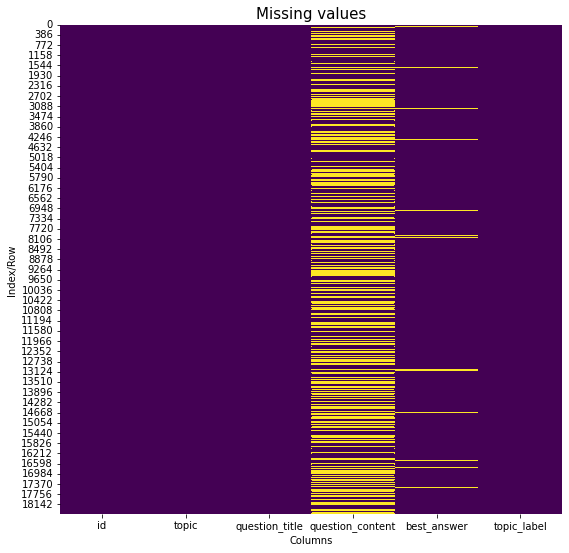

In [ ]:
# Check for empty strings in data frame by creating a heatmap
yahoo_answers_train = yahoo_answers_train.replace('', np.nan) # change empty strings to NA

# Inspect NA values
plt.figure(figsize=(9, 9))
sns.heatmap(yahoo_answers_train.isna(), cmap="viridis", cbar=False)
plt.title("Missing values", fontsize=15)
plt.ylabel("Index/Row", fontsize=10)
plt.xlabel("Columns", fontsize=10);

In [ ]:
# Check counts of variations
yahoo_answers_train.isna().value_counts()

id     topic  question_title  question_content  best_answer  topic_label
False  False  False           False             False        False          9937
                              True              False        False          8211
                              False             True         False           203
                              True              True         False           149
dtype: int64

Indeed, there are several observations that don't have any `question_content`. Additionally, for some observations, we don't have any `best_answer`. Let's look closer at some of them.

In [ ]:
# Visualize random observations that have NA values
nan_values = yahoo_answers_train[yahoo_answers_train.isna().any(axis=1)].reset_index()  
np.random.seed(42)
for i in range(3):
  random_index = nan_values.index
  random_line = np.random.choice(random_index)
  pprint(f"Title: {nan_values.iloc[random_line]['question_title']}")
  pprint(f"Content: {nan_values.iloc[random_line]['question_content']}")
  pprint(f"Best Answer: {nan_values.iloc[random_line]['best_answer']}")
  pprint(f"Label: {nan_values.iloc[random_line]['topic_label']}")
  print(50*"x")

'Title: Your most embarrassing moment ?'
'Content: nan'
('Best Answer: Back in the mid-eighties my ex-wife, children and I lived in a '
 'remote area of rural west-Texas. Our House had a large yard, and I was '
 'tilling it it up. On a Saturday morning I was having a difficult time '
 'keeping the machine running. In frustration {after yanking on the starter '
 'rope for SEVERAL minutes} I straightened up hefted a kick at the infernal '
 'thing and referred to it as a son of a bitch. Little did I know our five '
 'year son was outside and heard this. It gets better at that time I wore a '
 'full beard, none of my family had ever seen me without facial hair and my '
 "son's twin sister had been after me to shave. I did. When people would ask "
 'me why I had shaved I would tell them that I had lost control of my '
 'weed-eater. Well one Sunday a few weeks later after church My family was '
 'standing in the foyer of the church talking to our new pastor, his wife, and '
 "her parents  th

We see that questions can also be asked without additional content. How about the observations where we don't have any `best_answers`?

In [ ]:
# Visualize random observations that have NA in best_answer
nan_values = nan_values[(nan_values['best_answer'].isna())].reset_index()
np.random.seed(42)
for i in range(3):
  random_index = nan_values.index
  random_line = np.random.choice(random_index)
  pprint(f"Title: {nan_values.iloc[random_line]['question_title']}")
  pprint(f"Content: {nan_values.iloc[random_line]['question_content']}")
  pprint(f"Best Answer: {nan_values.iloc[random_line]['best_answer']}")
  pprint(f"Label: {nan_values.iloc[random_line]['topic_label']}")
  print(50*"x")

'Title: What is the moon?'
('Content: Hey if anyone has any sites or any good information please answer '
 'thank you have a great day.')
'Best Answer: nan'
'Label: Education & Reference'
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
'Title: The name of a Moffats song?'
("Content: Okay, here's the deal. A while back (at least 5 years ago) I got "
 'this caboodle boz thing from JC Penny I believe it was. It had a bunch of '
 'girly sample things in it, and it also had a CD in it. One of the songs was '
 "by the Moffats (I think) but it wasn't 'Misery' I can't for the life of me "
 "remeber how it goes and I've wasted more than enough time downloading Moffat "
 "songs. Anybody have any idea what I'm talking about?")
'Best Answer: nan'
'Label: Entertainment & Music'
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
'Title: Whats the difference beetween Muslim and Xtrine Revelation?'
('Content: Any one who knows both sides would be help alot or is you now one '
 'side in detail pleas

Inspecting the missing `best_answers` makes it not clear why there are missing values. It could be that there simply was no answer considered the best, or that a question received zero answers. Since we are interested in the whole text of a question (`question_title` + `question_content` + `best_answers`) to predict the category of a question/post, and we don't have any observations where we have NA's in all three columns, we will continue by imputing again the empty string for an NA value.

In [ ]:
# Change NA's back to empty string
yahoo_answers_train = yahoo_answers_train.replace(np.nan, '')

In [ ]:
# Check if imputation worked
yahoo_answers_train.isna().sum()

id                  0
topic               0
question_title      0
question_content    0
best_answer         0
topic_label         0
dtype: int64

Let's next continue by inspecting if we have duplicated observations.

In [ ]:
# Check for duplicates
yahoo_answers_train.duplicated().sum()

0

We don't have any duplicates in our data set. Next, we want to familiarize ourselves more with the data set before we prepare the text columns.

In [ ]:
# Visualize random lines
np.random.seed(18)
for i in range(5):
  random_index = yahoo_answers_train.index
  random_line = np.random.choice(random_index)
  pprint(f"Title: {yahoo_answers_train.iloc[random_line]['question_title']}")
  pprint(f"Content: {yahoo_answers_train.iloc[random_line]['question_content']}")
  pprint(f"Best Answer: {yahoo_answers_train.iloc[random_line]['best_answer']}")
  pprint(f"Label: {yahoo_answers_train.iloc[random_line]['topic_label']}")
  print(50*"x")

'Title: Steven Segal or Jean Claude?'
'Content: '
('Best Answer: OMG!! They both make me sick.  You can also add Richard Gere to '
 'this list too.')
'Label: Entertainment & Music'
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
'Title: what metals are in pewter,?'
'Content: '
('Best Answer: Pewter is a metal alloy, traditionally between 85 and 99 % tin, '
 'with the remainder consisting of 1-4 % copper, acting as a hardener, with '
 'the addition of lead for the lower grades of pewter and a bluish tint. There '
 'were three grades: Fine, for eatingware, with 96-99 % tin, and 1-4 % copper; '
 'Trifle, also for eating and drinking utensils but duller in appearance, with '
 '92 % tin, 1-4 % copper, and up to 4 % lead; and Lay or Ley metal, not for '
 'eating or drinking utensils, which could contain up to 15 % lead. Modern '
 'pewter mixes the tin with copper, antimony and/or bismuth, as opposed to '
 'lead. Bismuth and zinc can also be added to pewter. Pewter cannot be used to '
 'ma

Inspecting random observations, we see the following:

* A text can consist of lower- and uppercase words.
* There are special signs in the text (e.g. `-`, `!`, `?`, `%`).
* Some text have line breaks in it (`\\n`).
* The labels in our sample seem to match. However, based on the answer to the 3rd question (`what is a minority whip?`) could suggest that this question would rather belong to the `Politics & Government` label.

In general, it could be that our data is wrongly labeled. Wrongly meaning that a question would better belong to a different label. In this case, if the categories in our dataset are incorrectly labeled, it can have a significant impact on the accuracy and effectiveness of our models. To deal with this, we would have to manually review our data. However, since this would exceed the scope of this notebook, we won't check the correctness of our labels and proceed with caution to the next step and assume that a label is correct since a question was published that way.


## Data Cleaning


Let's next continue with creating our explanatory variable. We will therefore concatenate the whole text (`question_title` + `question_content` + `best_answers`) of a question and clean the text in the next step. The aim of the cleaning is to make the text comparable. Therefore, we will do the following steps:

* Remove punctuation
* Remove non-alphanumeric characters, including multiple spaces and breaks
* Lemmatize the words in the text (reduce words to their base form/dictionary representation)
* Convert all characters to lowercase
* Remove stop words

🔑 **A note on stop words:**
It is important to note that removing stop words is not always the best approach. In some cases, stop words may actually contain important meanings as they can increase the context of a text, and removing them could negatively impact the results of our model. We therefore will create a predictor variable that consists of stop words and a predictor variable that has the stop words removed. We will then evaluate the performance in the evaluation and modeling step.

In [ ]:
# Create function to clean text
def clean_text_for_preprocessing(text, stopwords_removed=True):
  """
  Cleans a text variable in order to be ready for the preprocessing.
  This includes the following:

  - Remove punctuation
  - Remove linebreaks
  - Remove non-alphanumeric characters including multiple spaces and breaks
  - Lemmatize the words in the text (reduce words to their base form/dictionary representation)
  - Convert all characters to lowercase
  - Strip text
  - Optional: Remove stopwords
  """
  
  # Remove linebreaks
  text = text.replace('\\n', ' ')

  # Lemmatize text (see: https://spacy.io/usage/linguistic-features#lemmatization)
  lemmatizer = nlp.get_pipe("lemmatizer")

  # Note: Takes around 8 minutes
  text = " ".join([token.lemma_ for token in nlp(text)])
  custom_filters = [strip_non_alphanum, strip_punctuation, strip_multiple_whitespaces]

  # Optional stop words removal
  if stopwords_removed:
    custom_filters.append(remove_stopwords)

   # Apply filters to text
  text = " ".join(preprocess_string(text, custom_filters))

  # Make text lowercase
  text = text.lower()
  
  # Strip text
  text = text.strip()

  return text

Now that we have a function that cleans our text. Let's concatenate `question_title`,  `question_content`, and `best_answers` and create our predictor variable (once without stop words and once with).

In [ ]:
# Concatenate text variables
yahoo_answers_train['whole_text'] = yahoo_answers_train['question_title'] + yahoo_answers_train['question_content'] + yahoo_answers_train['best_answer']

In [ ]:
# Apply cleaning function
yahoo_answers_train['whole_text_cleaned'] = yahoo_answers_train['whole_text'].apply(lambda x: clean_text_for_preprocessing(x, stopwords_removed=True))

# Once without removing stop words
yahoo_answers_train['whole_text_with_stopwords_cleaned'] = yahoo_answers_train['whole_text'].apply(lambda x: clean_text_for_preprocessing(x, stopwords_removed=False))


Let's explore some random samples more closely.

In [ ]:
# Visualize random cleanded text
np.random.seed(11)
for i in range(5):
  random_index = yahoo_answers_train.index
  random_line = np.random.choice(random_index)
  pprint(f"Text: \n{yahoo_answers_train.iloc[random_line]['whole_text_cleaned']}")
  print(50*"x")

('Text: \n'
 'trouble illegal alien residence sound like people right answer wrong reason '
 'people wrong answer completely stupid reason trouble prove know illegally '
 'america hard prove i add home proof accomplice prove know people enter house '
 'prove know illegal guilt association work case person sell home neighbor '
 'friend talk wal mart employee gas station attendant guilty association house '
 'suspect illegal alien proof paper require hook i like dispel allegation '
 'luvzitusa illegal felony i statement like sombody rob bank count accessory '
 'lie count accessory help person rob bank friend eat house know happen help '
 'premeditate hold accountable knowledge simple luvzitusa panacea s statement '
 'most illegal criminal i suppose illegal huh obvious i like know statistic '
 'broad generalization people group easily refute want rephrase statement i '
 'like know stat mean engage criminal activity likely drug premise broad '
 'generalization i agree drug arrest accomplic

In [ ]:
# Visualize random cleanded text without stop words
np.random.seed(11)
for i in range(5):
  random_index = yahoo_answers_train.index
  random_line = np.random.choice(random_index)
  pprint(f"Text: \n{yahoo_answers_train.iloc[random_line]['whole_text_with_stopwords_cleaned']}")
  print(50*"x")

('Text: \n'
 'can you get in trouble for be at an illegal alien residence and why sound '
 'like some people have the right answer but for the wrong reason and some '
 'people have the wrong answer for a completely stupid reason you can get in '
 'trouble if they can prove that you know they be illegally in america very '
 'hard to prove i might add be in their home be not further proof of you be an '
 'accomplice it just prove that you know the people and enter their house it '
 'do not prove that you know they be illegal guilt by association do not work '
 'either if this be the case the person that sell they the home the neighbor '
 'the friend anyone that have even talk to they wal mart employee gas station '
 'attendant etc would be guilty by the same association just be in the house '
 'would make you suspect of be an illegal alien as well once you show proof of '
 'paper whatever they may require you would be off the hook i would like to '
 'dispel am allegation by luvzitusa she

We can see that the cleaning of our text worked. When we compare the cleaned text that still has stop words with the text that has the stop words removed, we see especially in the first sample text there were many stop words removed. Let's inspect this in the data analysis part next. But before we continue with the data analysis, we will create the tokens for every text and calculate the number of tokens to get the text length of a post. We will then use the tokens in a later step again in the preprocessing when we build the vocabulary and prepare the word embeddings.

In [ ]:
# Tokenize the words
yahoo_answers_train['tokens'] = yahoo_answers_train['whole_text_cleaned'].apply(lambda x: word_tokenize(x))
yahoo_answers_train['tokens_with_stopwords'] = yahoo_answers_train['whole_text_with_stopwords_cleaned'].apply(lambda x: word_tokenize(x))

# Get text length
yahoo_answers_train['num_token'] = yahoo_answers_train['tokens'].apply(lambda x: len(x))
yahoo_answers_train['num_token_with_stopwords'] = yahoo_answers_train['tokens_with_stopwords'].apply(lambda x: len(x))


In [ ]:
# Display cleaned data frame
yahoo_answers_train.head()

id  topic                                     question_title  \
0  851713      9  My husband's brother was killed at sea in WWII...   
1  251470      9  Why Do So Many People Have a High Opinion of E...   
2  975899      0                    Did Jesus have a rational mind?   
3     194      4  Is there a way in MS Excel to have a cell be e...   
4  918296      1         What is the purpose of Bayesian Inference?   

                                    question_content  \
0  We have searched and cannot find a ship that s...   
1  Bill Clinton was an adulterer. He undermined o...   
2                                                      
3  I'm trying to make a cell that has a list of o...   
4  Hi. I know how Bayesian Statistical inference ...   

                                         best_answer            topic_label  \
0  Got an easier way for you to get the records. ...  Politics & Government   
1  The economy was up, our soldiers weren't out t...  Politics & Government   
2  I'm doubting it...\n\nNow, maybe the Mother Th...      Society & Culture   
3  Use the CONCATENATE function, with one of the ...   Computers & Internet   
4                                  Look up wikipedia  Science & Mathematics   

                                          whole_text  \
0  My husband's brother was killed at sea in WWII...   
1  Why Do So Many People Have a High Opinion of E...   
2  Did Jesus have a rational mind?I'm doubting it...   
3  Is there a way in MS Excel to have a cell be e...   
4  What is the purpose of Bayesian Inference?Hi. ...   

                                  whole_text_cleaned  \
0  husband s brother kill sea wwii ship search sh...   
1  people high opinion ex president adulterer bil...   
2  jesus rational mind m doubt maybe mother there...   
3  way ms excel cell equal multiple cell e g d3 d...   
4  purpose bayesian inference hi i know bayesian ...   

                   whole_text_with_stopwords_cleaned  \
0  my husband s brother be kill at sea in wwii ho...   
1  why do so many people have a high opinion of e...   
2  do jesus have a rational mind i m doubt it now...   
3  be there a way in ms excel to have a cell be e...   
4  what be the purpose of bayesian inference hi i...   

                                              tokens  \
0  [husband, s, brother, kill, sea, wwii, ship, s...   
1  [people, high, opinion, ex, president, adulter...   
2  [jesus, rational, mind, m, doubt, maybe, mothe...   
3  [way, ms, excel, cell, equal, multiple, cell, ...   
4  [purpose, bayesian, inference, hi, i, know, ba...   

                               tokens_with_stopwords  num_token  \
0  [my, husband, s, brother, be, kill, at, sea, i...         42   
1  [why, do, so, many, people, have, a, high, opi...         29   
2  [do, jesus, have, a, rational, mind, i, m, dou...         15   
3  [be, there, a, way, in, ms, excel, to, have, a...         50   
4  [what, be, the, purpose, of, bayesian, inferen...         25   

   num_token_with_stopwords  
0                        99  
1                        64  
2                        26  
3                        96  
4                        48

## Data Analysis

We cleaned the text in a previous step and are now ready to dive deeper into our data set. In order to get a better understanding of our data and see if we can identify any patterns or trends, we will use visualizations to look closer at how the text of a category distinguishes itself from the others. Therefore, we will do the following things:

* Inspect the distributions of the number of tokens per category.
* See if a category has notably more stop words than other categories.
* Check if the number of tokens correlates with the number of stop words used.
* Inspect the type-token ratio for the questions per category.
* Visualize the most common n-grams for every category.

### Distributions of the number of tokens per category

In [ ]:
# Visualize number of tokens per category as box plot
fig = px.box(yahoo_answers_train, y="num_token", color="topic_label",
             custom_data=["question_title"],
             title="Comparison of distribution of number of tokens between categories (without stop words)",
             template="seaborn",
             color_discrete_sequence=px.colors.qualitative.Prism)

fig.update_traces(
    hovertemplate="<br>".join([
        "Number of tokens: %{y}",
        "Question title: %{customdata[0]}"
    ])
)

fig.update_layout(
    legend_title="Category",
    yaxis_title="Number of tokens"
)
fig.show()

Inspecting the number of tokens for an observation (without stop words) per category shows that the median values per category lie between 22 (`Entertainment & Music` and `Sports`), whereas the highest median is visible in the category `Science & Mathematics` with 37 tokens. All box plots consist of multiple outliers larger than the upper whisker, which speaks for a right-skewed distribution. This means, generally posts are of shorter length, but there are multiple posts where the question, content, and best answer have substantially more words. 

Let us inspect for example the whole text of the highest outlier in the category `Sports` from the question *Show me how much you love your country ?* and see what this post initially contains in its uncleaned text. 

In [ ]:
# Show text of post with most tokens
pprint(yahoo_answers_train[yahoo_answers_train['num_token'] == 783]['whole_text'][15242])

('Show me how much you love your country ?USA USA USA USA USA USA USA USA USA '
 'USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA '
 'USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA '
 'USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA '
 'USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA '
 'USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA '
 'USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA '
 'USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA '
 'USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA '
 'USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA '
 'USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA '
 'USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA USA '
 'USA USA USA USA USA USA USA USA USA US

Well, this post consists of an answer where only the word `usa` was written several hundred times. We will deal with the multiple occurrences of words when we inspect the type-token ratio. For now, let's continue with the next highest outlier, to get one more example.

In [ ]:
# Show text of post with most tokens
pprint(yahoo_answers_train[yahoo_answers_train['num_token'] == 638]['whole_text_cleaned'][7607])

('jail speeding police officer small town stop motorist speed main street '
 'officer man begin i explain quiet snap officer i let cool heel jail chief '
 'officer i want i quiet jail hour later officer look n prisoner lucky chief s '
 'daughter s wedding good mood count answer fellow cell i groom ha ha ha ha ha '
 'ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha '
 'ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha '
 'ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha '
 'ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha '
 'ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha '
 'ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha '
 'ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha '
 'ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha '
 'ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha

The post belongs to the `Entertainment & Music` category and displays a text where the best answer almost only consists of the multiple use of `ha`. We again get it verified that we probably need a method that deals with the occurrence of multiple words in a post. However, let's next continue by inspecting the box plots per category, but this time with stop words.

In [ ]:
# Visualize with stopwords
fig_2 = px.box(yahoo_answers_train, y="num_token_with_stopwords", color="topic_label",
             custom_data=["question_title"],
             title="Comparison of distribution of number of tokens between categories (with stop words)",
             template="seaborn",
             color_discrete_sequence=px.colors.qualitative.Prism)

fig_2.update_traces(
    hovertemplate="<br>".join([
        "Number of tokens (with stop words): %{y}",
        "Question title: %{customdata[0]}"
    ])
)

fig_2.update_layout(
    legend_title="Category",
    yaxis_title="Number of tokens"
)
fig_2.show()

We see that the boxes for every category become larger.  A larger box in a box plot indicates that there is more variability in the data, which is understandable as we just added several stop words compared to our first box plots. However, what is the number of stop words compared to the length of the whole text? Let's inspect this next.

### Proportion of stop words of total words per text

In [ ]:
# Calculate median difference of tokens with stop words - number of tokens
num_stopwords = yahoo_answers_train.copy()
num_stopwords['num_stopwords'] = num_stopwords['num_token_with_stopwords'] - num_stopwords['num_token']
num_stopwords.groupby('topic_label')['num_stopwords'].median()

topic_label
Business & Finance        32.0
Computers & Internet      34.0
Education & Reference     28.0
Entertainment & Music     23.0
Family & Relationships    48.0
Health                    43.0
Politics & Government     41.0
Science & Mathematics     35.0
Society & Culture         41.0
Sports                    21.0
Name: num_stopwords, dtype: float64

Inspecting the median number of stop words for a post per category, lets us see that posts in the category `Family & Relationships` have the highest median number of stop words with 48, whereas posts in the category `Sports` have the least median number of stop words. However, it's hard to compare fixed numbers, as we don't know the average size of a post in the categories. Let's, therefore, calculate the percentages of stop words to the total number of tokens.

In [ ]:
# Calculate median % of stop words in total number of tokens per category
num_stopwords['percentage_stopwords'] = round(num_stopwords['num_stopwords'] / num_stopwords['num_token_with_stopwords'], 2)

In [ ]:
# Visualize with stopwords
fig_3 = px.box(num_stopwords, y="percentage_stopwords", color="topic_label",
             custom_data=["question_title", 'num_token_with_stopwords'],
             title="Proportion of stop words to total words per post",
             template="seaborn",
             color_discrete_sequence=px.colors.qualitative.Prism)

fig_3.update_traces(
    hovertemplate="<br>".join([
        "Percentage of stop words: %{y}",
        "Question title: %{customdata[0]}",
        "Number of tokens with stop words: %{customdata[1]}"
    ])
)

fig_3.update_layout(
    legend_title="Category",
    yaxis_title="Percentage of stop words"
)
fig_3.show()

Overall, the median post per category consists of almost the same number of stop words as normal words. That's a lot! This could already point to that stop words add a lot of variability to the posts without adding a lot of context to the text and therefore could make it harder for our model to categorize the different posts, or that the stop words could be an important aspect of our posts and are needed to get the overall meaning of a post. We will answer this question in our first models. Additionally, we see that we now have more outliers smaller than the lower whiskers. Interesting to see is that we have a post that consists only of stop words. Let's inspect this.

 

In [ ]:
# Show text of post only stop words
pprint(num_stopwords[num_stopwords['percentage_stopwords'] == 1]['whole_text'][1028])

'Where are you from?'


We see that the text only consists of four tokens. There was only a question title, but then no content and no best answer. This leads us to the question of how much stop words correlate with the total length of words in a post, and if there is a difference visible between categories. Let us take a final view at the stop words by inspecting the correlation of the number of stop words to the length of a text per category.

### Correlation between number of stop words and number of words in a post

In [ ]:
# Create scatter plot
fig_3 = px.scatter(num_stopwords,
                   x='num_stopwords', y='num_token_with_stopwords',
                   color='topic_label', facet_col='topic_label',
                   facet_col_wrap=2,
                   labels = {
                       'num_token_with_stopwords':'Number words',
                       'num_stopwords' : 'Number stop words'
                    },
                   title='Correlation number of words and number of stop words',
                   template="seaborn",
                   color_discrete_sequence=px.colors.qualitative.Prism)

fig_3.update_layout(
    legend_title="Category"

)

fig_3.update_layout(
    autosize=False,
    width=800,
    height=800)

fig_3.show()

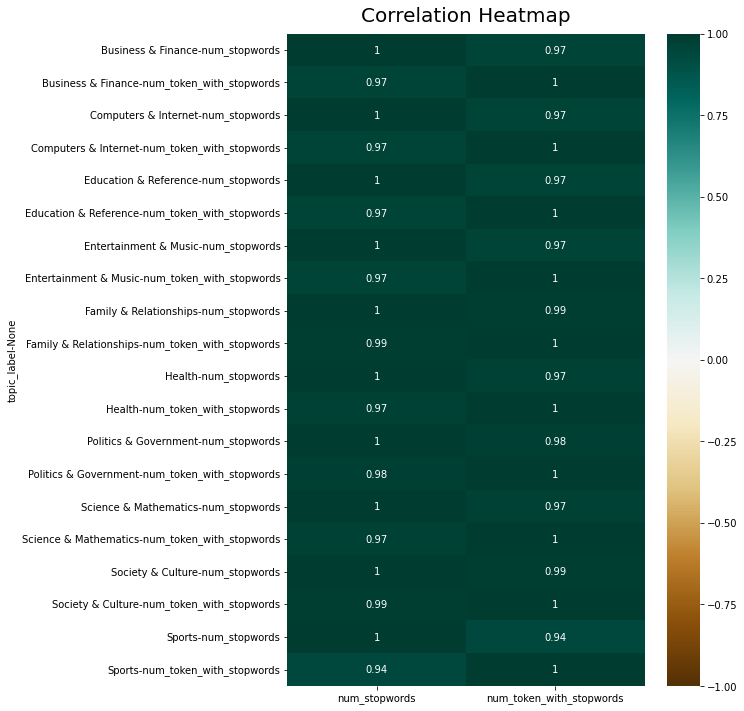

In [ ]:
plt.figure(figsize=(8, 12))

# Calculate correlation
corr = num_stopwords.groupby('topic_label')[['num_stopwords', 'num_token_with_stopwords']].corr()

# visulization
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

As we could have expected, the number of stop words highly correlates with the total amount of words that are in a text. This means the proportion of stop words increases also highly when the total number of words increases. As there are only very small differences, we note this fact and continue.

(**Remark:** This step might seem redundant, as common human sense might suggest that the number of stop words increases with the number of words in a text. However, it's important to always inspect the correlation of variables in a data set, and approach a data set without prejudice. Therefore, this step was made explicit.)

As seen in subsequent analysis sections, stop words mostly add variability to all the categories of our data without making them more distinguishable. We will therefore continue by only analyzing the text without stop words.

### Type-Token Ratio (TTR)

In one of the previous sections, we have seen that the texts that consist of the highest number of tokens consist of mostly repetitive words. In order to get a better understanding of the differences between the texts of every category, we will next take a look at the vocabulary diversity of the texts. For this, we can use the TTR, which is a measure of the lexical richness of a text. The TTR is calculated by dividing the number of unique words (types) by the total number of words (tokens) of a text.

In [ ]:
# Create vocabulary range per post
yahoo_answers_train['vocabulary_range'] = yahoo_answers_train['tokens'].apply(lambda x: len(set(x)))
# Calculate TTR
yahoo_answers_train['ttr'] = round(yahoo_answers_train['vocabulary_range'] / yahoo_answers_train['num_token'], 3)

In [ ]:
# Visualize TTR per category
fig_4 = px.box(yahoo_answers_train, y="ttr", x='topic_label',
               color="topic_label",
               custom_data=["question_title", 'vocabulary_range', 'num_token'],
               title="TTR per Category",
               template="seaborn",
               color_discrete_sequence=px.colors.qualitative.Prism)

fig_4.update_traces(
    hovertemplate="<br>".join([
        "TTR: %{y}",
        "Question title: %{customdata[0]}",
        "Vocabulary Range: %{customdata[1]}",
        "Number of words: %{customdata[2]}"
    ])
)

fig_4.update_layout(
    legend_title="Category",
    yaxis_title="TTR",
    xaxis_title=""
)
fig_4.show()

Inspecting the TTR lets us see that for every category, the majority of posts (75%) have a TTR of more than 0.64. For every category besides `Family & Relationships` we have multiple outliers at the lower end, with the most extreme observation coming from the post *Show me how much you love your country ?*, which we inspected already before. On the general side, we can however say that posts in the category `Sports` have on average the highest TTR (0.846) and represent the post with the highest lexical richness. On the other hand, we have `Science & Mathematics` with the lowest average lexical richness (0.754). We now compared the distributions of the different texts per category, but what does it look like if we create a vocabulary for every category and calculate the TTR for this? Let's do this in the next step.

In [ ]:
# Create dataframe that consists of the whole text per category
category_df = yahoo_answers_train.groupby('topic_label')['whole_text_cleaned'].apply(' '.join).reset_index()
# Calculate word length
category_df['num_token'] = category_df['whole_text_cleaned'].apply(lambda x: len(x.split()))
# Calculate vocabulary range
category_df['vocabulary_range'] = category_df['whole_text_cleaned'].apply(lambda x: len(set(x.split())))
# Calculate TTR
category_df['ttr'] = round(category_df['vocabulary_range'] / category_df['num_token'], 3)
# Normalize vocabulary size to lay between 0 and 1 (size visualisation purpose)
category_df['size_vocabulary'] = ((category_df['vocabulary_range'] - category_df['vocabulary_range'].min()) / category_df['vocabulary_range'].max())


In [ ]:
# Visulize the TTR, vocaulary range and number of words per category
fig_5 = px.scatter(category_df, y="ttr", x='num_token',
                   size='size_vocabulary',
                   size_max=25,
                   color='topic_label',
                   custom_data=['vocabulary_range'],
                   title="Comparison of TTR, vocaulary range (size) and number of words of whole text per category",
                   template="seaborn",
                   color_discrete_sequence=px.colors.qualitative.Prism)

fig_5.update_traces(
    hovertemplate="<br>".join([
        "TTR: %{y}",
        "Number of words: %{x}",
        "Vocabulary range: %{customdata[0]}"
    ])
)

fig_5.update_layout(
    legend_title="Category",
    yaxis_title="TTR",
    xaxis_title="Number of words"
)
fig_5.show()

Inspecting the plot, we see that `Entertainment & Music` as well as `Sports` are the category with the highest TTR and correspond to the categories with the highest lexical richness. Generally, it is assumed that the TTR decreases as the number of words increases. Having both, with the least number of words, supports this general characteristic. However, if we inspect the other categories we see that `Computers & Science` have the lowest TTR and vocabulary range (size) of all categories, although not being the category with the most number of words. Besides that, we see that `Science & Mathematics` has the highest number of words as well as almost the largest vocabulary range (size), but lies in the middle when it comes to the TTR. Given this information, it's still hard to distinguish the categories. Let's, therefore, take a closer look at the text itself and build n-grams of the text of the categories.

### N-grams

N-Grams are a sequence of n-consecutive words in a text. With their help, we will next take a closer look at the most common Bigrams (two consecutive words) and Trigrams (three consecutive words) in the texts of every category.

To do this, we will use `nltk` (see documentation https://www.nltk.org/api/nltk.util.html?highlight=ngrams#nltk.util.ngrams).

We will first create a function that can build n-grams per category in a data frame and return a data frame that consists of the most commonly used n-grams of the category.

In [ ]:
# Create function to get n-grams per category
def build_category_ngrams(df, n=2, n_top=10):
  """
  Creates n-grams per category in a dataframe and returns 
  a dataframe that consists of the most common used n-grams of the category.

  Args:
    df: pd.DataFrame with categories in `topic_label` and whole text of category in `whole_text_cleaned`
    n: n-gram number (default bigram)
    n_top: top n words to be returned in dataframe
  """

  category_ngram_df = pd.DataFrame()

  for categ in df['topic_label']:
    # Get text per category
    text_categ = [df[df['topic_label'] == categ].reset_index()['whole_text_cleaned'].iloc[0]]
    categ_ngrams = []

    for sample in text_categ:
      # Build ngrams based on category text
      categ_ngrams.extend(ngrams(nltk.word_tokenize(sample), n))
    
    # Get top_n ngrams for a category and append it to overall dataframe
    ngrams_df = pd.DataFrame(pd.Series(categ_ngrams).value_counts()[:n_top]).reset_index()
    ngrams_df['topic_label'] = categ
    category_ngram_df = pd.concat([category_ngram_df, ngrams_df])

  category_ngram_df.rename(columns={"index": "word", 0:'count'}, inplace=True)

  return category_ngram_df

#### Bigrams

In [ ]:
# Apply function to category_df
bigram_df = build_category_ngrams(category_df)

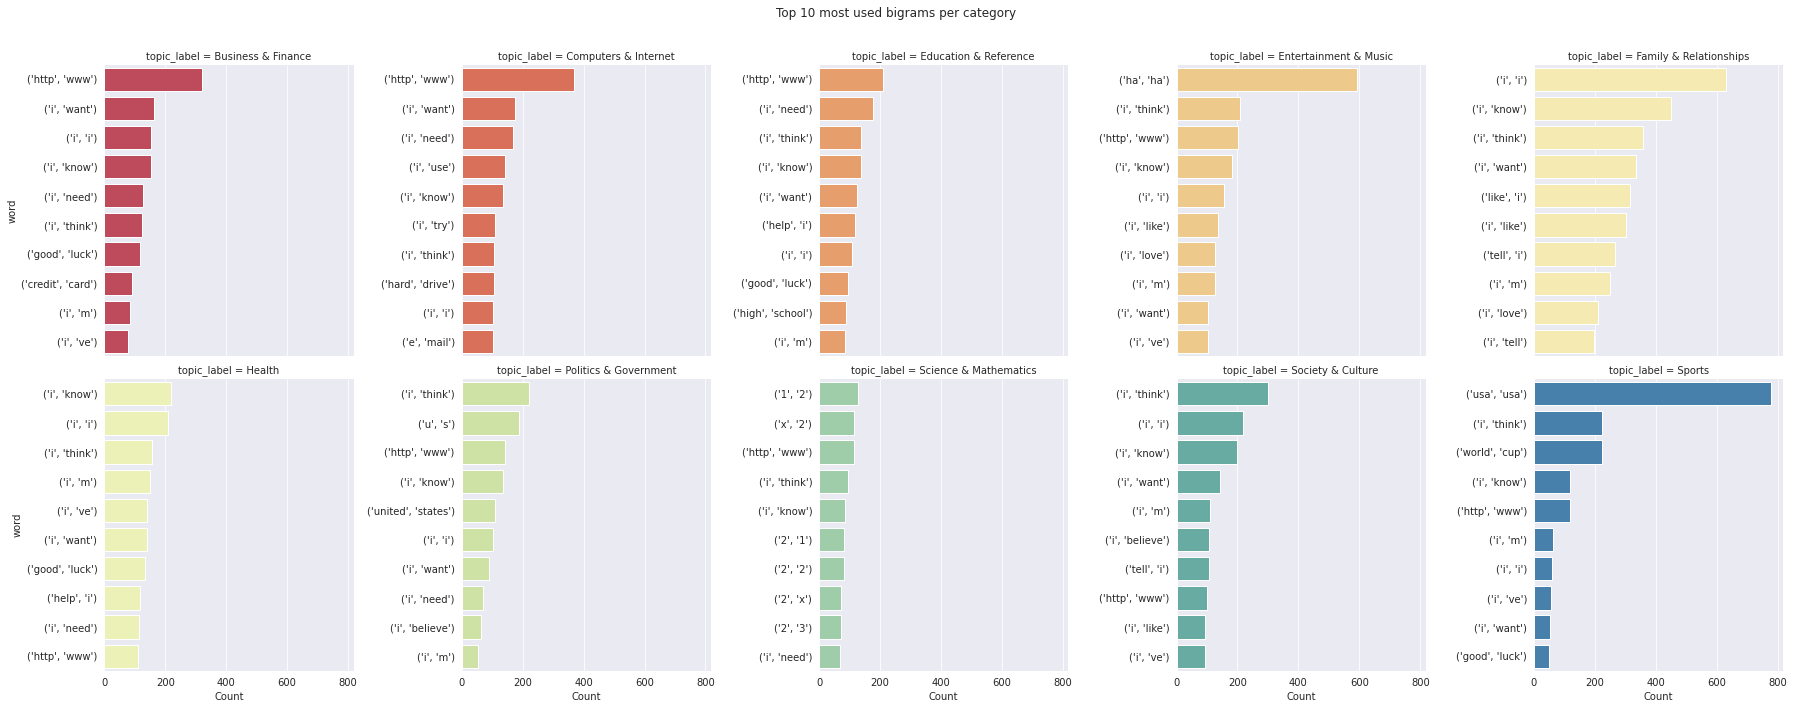

In [ ]:
# Visualize the most used bigrams per category (click on plot to make it bigger)
sns.set_style("darkgrid")

bar_plot = sns.catplot(data=bigram_df, 
                       x="count", y="word",
                       col="topic_label",
                       hue="topic_label",
                       col_wrap=5,
                       kind="bar",
                       dodge=False,
                       sharey=False,
                       palette=sns.color_palette("Spectral", 10))

bar_plot.set(xlabel="Count")
bar_plot.fig.subplots_adjust(top=0.9)
bar_plot.fig.suptitle('Top 10 most used bigrams per category');

Building the bigrams shows that almost for every category, the word `i` is present in multiple bigrams. Next, we see again the influence of our outliers, which we inspected before. For `Sports` the bigram `usa usa` and for `Entertainment & Music` the bigram `ha ha` are the most common ones, and these correspond to the words we have seen in our outliers. Besides this, we see that `world cup` for `Sports` and `united states` for `Politics & Government` are commonly used bigram, which makes sense. On the other hand, we see that for `Science & Mathematics` number combinations or numbers combined with `x` are most common, which also seems plausible. Lastly, we also see that the combination of `http www` is present in almost all categories (all but `Family & Relationship`) which points to a website that was linked in the post.

We saw that `i` was highly present in all of our bigrams, but didn't add a lot of meaning to it. Let's therefore temporarily remove all the `i` in the text and build trigrams. We will also remove the outlier words `usa` and `ha` for this.

#### Trigrams

In [ ]:
# Remove 'i' from vocabulary 
# (there are more efficient ways to do this but we will stick to this as we only want to reduce the frequency of the words)
category_df['whole_text_cleaned'] = category_df['whole_text_cleaned'].apply(lambda x: x.replace(' i ', ' ').replace('usa ', ' ').replace('ha ', ' '))

In [ ]:
# Apply our function to create trigrams
trigram_df = build_category_ngrams(category_df, n=3)

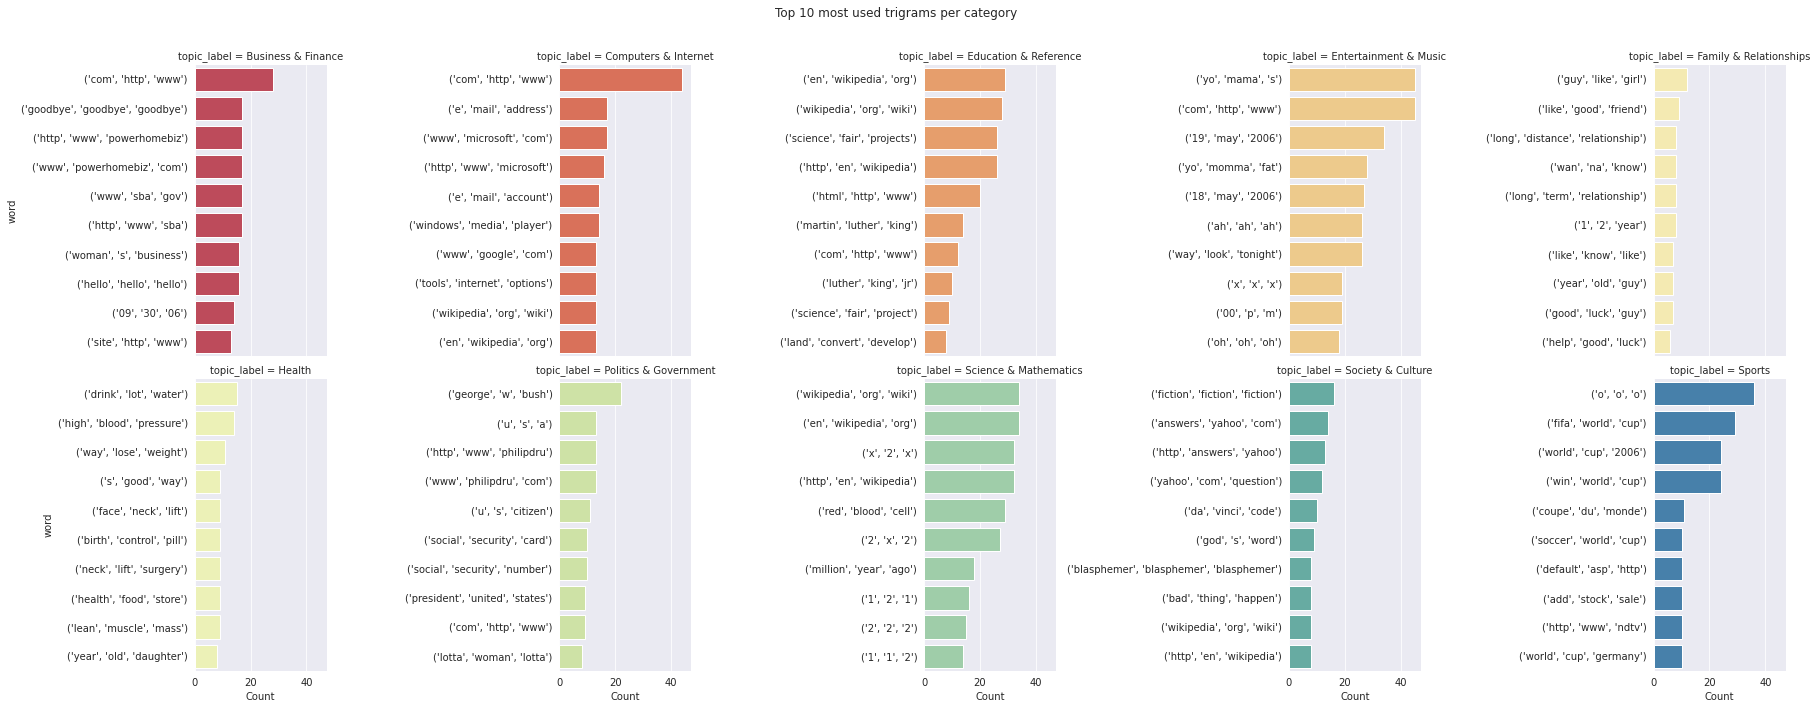

In [ ]:
# Visualize the most used trigrams per category (click on plot to make it bigger)
bar_plot = sns.catplot(data=trigram_df, 
                       x="count", y="word",
                       col="topic_label",
                       hue="topic_label",
                       col_wrap=5,
                       kind="bar",
                       dodge=False,
                       sharey=False,
                       palette=sns.color_palette("Spectral", 10))

bar_plot.set(xlabel="Count")
bar_plot.fig.subplots_adjust(top=0.9)
bar_plot.fig.suptitle('Top 10 most used trigrams per category');

Building the trigrams per category shows some very nice and understandable word combinations that match the context of the category. We for example see that `drink lot water` and `high blood pressure` are the most common trigrams for `Health`, which totally makes sense. On the other hand, we see word combinations, that could be considered to belong to another category for example `add stock sale` in `Sports` that could also be a topic in `Finance & Business` or `luther king jr` in `Education & Reference` that could also be a topic in `Society & Culture` as well as `Politics & Government. Additionally, the number of occurrences of these trigrams is low if we compare it to the overall words per category.

**🔑 Key-insigts:** We have seen that the distribution and quantitative properties of the posts (e.g number of words, TTR, vocabulary range) of the different categories are quite similar, and it's very hard to distinguish between categories by only considering these. With building n-grams, we have seen that there are still a lot of word combinations that are visible in almost every category as the high use of `i`. By removing `i` as well as the words of outliers (`usa` & `ha`), we were able to build trigrams that let us identify word combinations that are frequently used in the posts of a category and make sense to us. Additionally, we saw that the texts consist of a high share of stop words that increase the variability in our texts. Overall, the classification task seems to be hard at this point. However, we will create several models in the next parts and see how well they perform.

## Preprocessing

Let's continue with the preprocessing. The goal of preprocessing is to transform our data into a format that we can use for training our models. Additionally, we will split our train dataset into a train and validation data set. As stated at the start of this notebook, we will consider the test dataset as currently unknown data that we will first get in the future, namely after we have trained our model and want to test it. We, therefore, need to write functions that enable us to transform new data into the form that we need for our model. Additionally, we want to test if we get better performance if we keep stop words included in our data. We will therefore create two train and validation splits. One with stop words and one without.



In [ ]:
# First set the seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

We will now create the test and validation split with the help of `.train_test_split()` from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). We will first afterward split the data sets into sets with and without stop words, as we want to have the same observations in both data sets.

In [ ]:
# Assign X and y to needed variables
X = yahoo_answers_train[['tokens', 'tokens_with_stopwords']]
y = yahoo_answers_train['topic']

# test size
TEST_SIZE = 3500/18500

# Create train and validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [ ]:
# Inspect data
X_train.head(3), X_val.head(3), y_train.head(3), y_val.head(3)

(                                                 tokens  \
 7180  [anybody, opinion, stress, eraser, sold, http,...   
 9937  [downside, foreclosure, home, buying, probably...   
 8425  [s, man, cosby, man, house, bill, cosby, actor...   
 
                                   tokens_with_stopwords  
 7180  [do, anybody, have, an, opinion, about, the, s...  
 9937  [what, be, the, downside, of, foreclosure, hom...  
 8425  [what, s, the, name, of, the, man, on, the, co...  ,
                                                   tokens  \
 3434   [soccer, good, sport, think, isyes, yes, yes, ...   
 8628   [s, weight, kilogram, pound, 127, divide, 127,...   
 10934  [good, rock, roll, band, time, the, beatles, c...   
 
                                    tokens_with_stopwords  
 3434   [be, not, soccer, the, good, sport, i, think, ...  
 8628   [what, s, the, weight, in, kilogram, if, the, ...  
 10934  [who, be, the, good, rock, and, roll, band, of...  ,
 7180    2
 9937    6
 8425    6
 

In [ ]:
# Check length of split
len(X_train), len(X_val), len(y_train), len(y_val)

(15000, 3500, 15000, 3500)

The split into train and validation worked. We have now 15'000 posts in our train set and 3'500 posts in our validation set. The final data format that we want, should be stored in a list of dictionaries, where we have one dictionary of the tokens indexes and the category as a number per post. We will set the max length of the tokens to 64 in order to reduce memory usage and speed up training later. In a real word scenario, it's important to evaluate more on setting a maximum number of tokens, as important information might get lost from the data. However, due to the scope of this notebook, we will continue with the maximum token length of 64. Let's, therefore, create a function that can also later be applied to our test data set. Additionally, we will now create a train and validation data set with stop words and one without.

In [ ]:
# Create function to create needed data structure
def preprocess_data_to_dataformat(X, y):
  """
  Transforms data in a dataframe column to list of dicts.
  Tokens as a list and the category as a number stored in a dictionary.
  Additionally, tokens are reduced to max 64 tokens.
  """

  df = pd.concat([X, y], axis=1)

  df.rename(columns = {list(df)[0]: 'tokens', list(df)[1]: 'category'}, inplace = True)

  df['tokens'] = df['tokens'].apply(lambda x: x[:64])

  data_list = df.to_dict('records')

  return data_list

In [ ]:
# Apply function to create data sets

# without stop words
train_data = preprocess_data_to_dataformat(X_train['tokens'], y_train)
val_data = preprocess_data_to_dataformat(X_val['tokens'], y_val)

# with stop words
train_data_with_stopwords = preprocess_data_to_dataformat(X_train['tokens_with_stopwords'], y_train)
val_data_with_stopwords = preprocess_data_to_dataformat(X_val['tokens_with_stopwords'], y_val)

In [ ]:
# Check if max tokens are set correctly
for sample in train_data:
  if len(sample['tokens']) > 64:
    print(sample, len(sample['tokens']))

for sample in val_data:
  if len(sample['tokens']) > 64:
    print(sample, len(sample['tokens']))

for sample in train_data_with_stopwords:
  if len(sample['tokens']) > 64:
    print(sample, len(sample['tokens']))     

for sample in val_data_with_stopwords:
  if len(sample['tokens']) > 64:
    print(sample, len(sample['tokens'])) 

In [ ]:
# Check sample
train_data[0] #, val_data[0], train_data_with_stopwords[0], val_data_with_stopwords[0]

{'tokens': ['anybody',
  'opinion',
  'stress',
  'eraser',
  'sold',
  'http',
  'stresseraser',
  'com',
  'follow',
  'biofeedback',
  'principle',
  'prove',
  'relieve',
  'stress',
  'train',
  'body',
  'relax',
  'watch',
  'physiological',
  'reaction',
  'stress',
  'i',
  'actually',
  'psychologist',
  'physician',
  'biofeedback',
  'fork',
  '300'],
 'category': 2}

Now that we have our training and validation data ready, we can build the vocabulary to later prepare the word embeddings. In order to not get a too large vocabulary, we will count the number of occurrences of a word and then add it to the vocabulary, if it occurred in the text more than once. Additionally, we will only create the vocabulary based on the train data, as this will be the data that the models should use to learn the patterns in the data. The validation set should represent the first unseen data to the model (before we evaluate on the test data). Therefore, using the validation data as well would lead to data leakage, which we want to prevent.

In [ ]:
# Build vocabulary - without stop words
vocabulary = set()
vocabulary_dict = {}
for sample in train_data:
  for token in sample['tokens']:
    if token in vocabulary_dict.keys():
      vocabulary_dict[token] += 1
    else:
      vocabulary_dict[token] = 1

for token, number in vocabulary_dict.items():
  if number > 1:
    vocabulary.add(token)
  else:
    continue
  
print(f"Vocabulary without stop words: {len(vocabulary)}")

Vocabulary without stop words: 19185


In [ ]:
# Build vocabulary - with stop words
vocabulary_with_stopwords = set()
vocabulary_with_stopwords_dict = {}

for sample in train_data_with_stopwords:
  for token in sample['tokens']:
    if token in vocabulary_with_stopwords_dict.keys():
      vocabulary_with_stopwords_dict[token] += 1
    else:
      vocabulary_with_stopwords_dict[token] = 1

for token, number in vocabulary_with_stopwords_dict.items():
  if number > 1:
    vocabulary_with_stopwords.add(token)
  else:
    continue
  
print(f"Vocabulary with stop words: {len(vocabulary_with_stopwords)}")

Vocabulary with stop words: 15869


We were able to build the vocabulary for our train data sets. For the train data without stop words, we get a vocabulary of 19'185 words and for the train data with stop words, we get a vocabulary of 15'869 words. We are now ready to build the word embedding matrix.

### Embedding

Next, we create the embedding matrix for our data. Word embedding is a technique that represents words in a continuous vector space and is used in natural language processing to encode text input as numerical data. Due to the numerical representation, our model can then potentially capture the context and meaning of words and therefore learn from a large amount of data efficiently. Before we create the embeddings, we first have to assign indexes to our words and create dictionaries where we can look up indexes and words for their index. Here we have to add `_PAD_` in order to pad our tokens all to the same length later and `_UNK_` in order to deal with words that are not in our vocabulary.


In [ ]:
# Create word to index mapping - without stop words
word2index = {'_PAD_': 0, '_UNK_': 1}
for word in vocabulary:
  word2index[word] = len(word2index)
index2word = {idx:word for word, idx in word2index.items()}

word2index, index2word

({'_PAD_': 0,
  '_UNK_': 1,
  'quietly': 2,
  'reconnect': 3,
  'overboard': 4,
  'saturated': 5,
  'shake': 6,
  '50': 7,
  'client': 8,
  'volleyball': 9,
  'befor': 10,
  'thestressblog': 11,
  'angelina': 12,
  'sperm': 13,
  'rebirth': 14,
  'astronomy': 15,
  'multiple': 16,
  'siberian': 17,
  'phillips': 18,
  'smoothie': 19,
  'indication': 20,
  'emancipate': 21,
  'psych': 22,
  'indesign': 23,
  'socks': 24,
  'terry': 25,
  'harris': 26,
  'bail': 27,
  '126': 28,
  'monarchy': 29,
  'penalize': 30,
  'pu': 31,
  'imitate': 32,
  'hygd': 33,
  'reliability': 34,
  'fanny': 35,
  'cm': 36,
  'stp': 37,
  'classmate': 38,
  'write': 39,
  'regulate': 40,
  'offensive': 41,
  'compliment': 42,
  'lack': 43,
  'ideogram': 44,
  'yer': 45,
  'gaea': 46,
  'by': 47,
  'hallucinogenic': 48,
  'julius': 49,
  'primate': 50,
  'affair': 51,
  'ids': 52,
  'nickname': 53,
  'emploi': 54,
  'easton': 55,
  'where': 56,
  'apostle': 57,
  'unistrut': 58,
  'beloved': 59,
  '137': 60,


In [ ]:
# Create word to index mapping - with stop words
word2index_with_stopwords = {'_PAD_': 0, '_UNK_': 1}
for word in vocabulary_with_stopwords:
  word2index_with_stopwords[word] = len(word2index_with_stopwords)
index2word_with_stopwords = {idx:word for word, idx in word2index_with_stopwords.items()}

word2index_with_stopwords, index2word_with_stopwords

({'_PAD_': 0,
  '_UNK_': 1,
  'reconnect': 2,
  'overboard': 3,
  'saturated': 4,
  '50': 5,
  'shake': 6,
  'client': 7,
  'volleyball': 8,
  'befor': 9,
  'thestressblog': 10,
  'angelina': 11,
  'sperm': 12,
  'rebirth': 13,
  'siberian': 14,
  'multiple': 15,
  'astronomy': 16,
  'phillips': 17,
  'indication': 18,
  'psych': 19,
  'socks': 20,
  'harris': 21,
  'bail': 22,
  '126': 23,
  'monarchy': 24,
  'penalize': 25,
  'imitate': 26,
  'hygd': 27,
  'fanny': 28,
  'cm': 29,
  'classmate': 30,
  'write': 31,
  'regulate': 32,
  'offensive': 33,
  'compliment': 34,
  'lack': 35,
  'yer': 36,
  'gaea': 37,
  'by': 38,
  'easton': 39,
  'julius': 40,
  'ids': 41,
  'affair': 42,
  'emploi': 43,
  'nickname': 44,
  'where': 45,
  'apostle': 46,
  'unistrut': 47,
  'beloved': 48,
  '137': 49,
  'near': 50,
  'cornfield': 51,
  'alzheimer': 52,
  'add': 53,
  'tung': 54,
  'plywood': 55,
  'remotely': 56,
  'geologist': 57,
  'parker': 58,
  'ceaser': 59,
  'kingman': 60,
  'lib': 61

In [ ]:
# Check length of created word2index dictionaries
len(word2index), len(word2index_with_stopwords)

(19187, 15871)

We now have created the word-to-index and index-to-word mapping. We will now continue with creating the word2vec matrix. For this, we will use a pre-trained word2vec model, as creating our own word2vec model that is good [would need much more data as we have in our train data set](https://code.google.com/archive/p/word2vec/). Additionally, using a pre-trained model saves us time and resources, but provides us already with very well-trained word vectors. For this, we will use the `glove-wiki-gigaword-100` that was trained on Wikipedia 2014 and Gigaword 5, and should have the representations of our categories well represented in the embedding space.

In [ ]:
# Load Glove word2vec model
word2vec = api.load("glove-wiki-gigaword-100")

In [ ]:
# Create word embedding matrix and copy from word2vec embeddings - without stopwords

WORD_DIM = 100 # Word represented in a vector of length 100

# Random intialization
word_embeddings = np.random.rand(len(word2index), WORD_DIM)

# Set _PAD_ to zeros
word_embeddings[word2index['_PAD_']] = np.zeros(WORD_DIM)

# Copy embeddings from word2vec to our words
for word in vocabulary:
  if word in word2vec:
    word_embeddings[word2index[word], :] = word2vec[word]
word_embeddings.shape

(19187, 100)

In [ ]:
# Create word embedding matrix and copy from word2vec embeddings - with stopwords

WORD_DIM = 100 # Word represented in a vector of length 100

# Random intialization
word_embeddings_with_stopwords = np.random.rand(len(word2index_with_stopwords), WORD_DIM)

# Set _PAD_ to zeros
word_embeddings_with_stopwords[word2index_with_stopwords['_PAD_']] = np.zeros(WORD_DIM)

# Copy embeddings from word2vec to our words
for word in vocabulary_with_stopwords:
  if word in word2vec:
    word_embeddings_with_stopwords[word2index_with_stopwords[word], :] = word2vec[word]
word_embeddings_with_stopwords.shape

(15871, 100)

We now assigned the word embeddings to the words in our vocabulary, by copying them from the pre-trained word2vec model. Inspecting the shape shows that each word in the vocabulary is represented by a 100-dimensional vector.

### Deal with unknown words and pad tokens

Now that we have created our word embeddings. We can finalize our data for the modeling. In order to be ready for modeling, we need to do the following things:

* Assign the related word index to every word in our data in order to get the corresponding word embedding for a word
* Set the `_UNK_` token if a word is not represented in our vocabulary
* Pad all posts in the data set to 64 tokens (we set the max size before to 64, but posts with fewer tokens need to be padded to 64)

In order to do this and also be able to apply this afterward quickly to new data (our test data), we will create a function that does the mentioned steps.

In [ ]:
# Create function
def assign_embedding_pad_token(data, word2index_dict):
  """
  Assigns the related word index to every word
  Sets `_UNK_` token if a word is not in the vocabulary
  Pads all posts in the data set to 64 tokens
  """
  PAD_LENGTH = 64

  # Assign word indexes
  for post in data:
    post['word_index'] = []
    for token in post['tokens']:
        post['word_index'].append(word2index_dict[token] if token in word2index_dict else word2index_dict['_UNK_'])

  # Pad tokens to 64
  for post in data:
    while len(post['word_index']) < PAD_LENGTH:
        post['word_index'].append(word2index_dict['_PAD_'])

    # Pop tokens
    post.pop('tokens')



Now that we have created the function, we can apply it to our two different train and validation data sets.

In [ ]:
# Apply function for train data - without stopwords
assign_embedding_pad_token(train_data, word2index)
# Apply function for validation data - without stopwords
assign_embedding_pad_token(val_data, word2index)


# Apply function for train data - with stopwords
assign_embedding_pad_token(train_data_with_stopwords, word2index_with_stopwords)
# Apply function for validation data - with stopwords
assign_embedding_pad_token(val_data_with_stopwords, word2index_with_stopwords)

# Show samples
train_data_with_stopwords[42], len(train_data_with_stopwords[42]['word_index']), val_data_with_stopwords[42], len(val_data_with_stopwords[42]['word_index'])

({'category': 8,
  'word_index': [7015,
   15727,
   9969,
   5858,
   3848,
   15585,
   14262,
   13955,
   12719,
   15166,
   6376,
   2732,
   5237,
   126,
   4005,
   2732,
   1,
   14262,
   3889,
   126,
   2732,
   8906,
   90,
   12188,
   15858,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]},
 64,
 {'category': 9,
  'word_index': [14881,
   2821,
   4511,
   425,
   7888,
   9702,
   6058,
   15516,
   90,
   3335,
   5202,
   13955,
   5858,
   2732,
   95,
   12591,
   7831,
   2642,
   12647,
   1063,
   10405,
   511,
   13955,
   1279,
   13955,
   5858,
   13936,
   15166,
   6286,
   3939,
   10544,
   7831,
   1,
   8103,
   7831,
   425,
   7888,
   2690,
   12882,
   5858,
   13190,
   6859,
   4476,
   6859,
   2690,
   4511,
   2642,
   1771,
   1,
   1524,
   2732,
   15166,
 

This already looks good. All the tokens in our posts have now their related index assigned. Additionally, they are all padded to a length of 64. However, to create the final data for our model, we will create a tuple of the values from every post and then create the data loaders in order to create the batches in tensor format. For this, we will create batches of 256 which is generally a reasonable default choice. 

In [ ]:
# Convert dictionaries into tuples of values - without stop words
train_data = [(v['category'], v['word_index']) for v in train_data]
val_data = [(v['category'], v['word_index']) for v in val_data]

# Convert dictionaries into tuples of values - with stop words
train_data_with_stopwords = [(v['category'], v['word_index']) for v in train_data_with_stopwords]
val_data_with_stopwords = [(v['category'], v['word_index']) for v in val_data_with_stopwords]

In [ ]:
# Create train and test dataloader
def vectorize_batch(batch):
    Y, X = list(zip(*batch))

    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y)


# Dataset without stop words
train_loader = DataLoader(train_data, batch_size=256, collate_fn=vectorize_batch, shuffle=True)
val_loader  = DataLoader(val_data , batch_size=256, collate_fn=vectorize_batch)

# Dataset with stop words
train_loader_with_stopwords = DataLoader(train_data_with_stopwords, batch_size=256, collate_fn=vectorize_batch, shuffle=True)
val_loader_with_stopwords  = DataLoader(val_data_with_stopwords , batch_size=256, collate_fn=vectorize_batch)

In [ ]:
# Show a sample of a batch
for batch in train_loader:
  print(batch)
  break

(tensor([[ 5430,  7995, 17280,  ...,     0,     0,     0],
        [ 6321,     1,  2651,  ...,     0,     0,     0],
        [15753,  7455, 17112,  ...,     0,     0,     0],
        ...,
        [15727,  9884,  4920,  ...,     0,     0,     0],
        [ 9383,  1935,  7045,  ...,     0,     0,     0],
        [ 9644, 19175,  6815,  ...,     0,     0,     0]], dtype=torch.int32), tensor([4, 5, 1, 3, 3, 4, 3, 8, 1, 4, 9, 8, 0, 6, 6, 9, 0, 7, 8, 3, 7, 9, 2, 6,
        3, 9, 6, 5, 3, 4, 4, 3, 1, 4, 9, 9, 7, 6, 3, 8, 5, 9, 1, 4, 5, 5, 6, 9,
        6, 1, 2, 6, 9, 0, 2, 6, 1, 7, 7, 2, 0, 8, 3, 9, 5, 0, 6, 8, 0, 2, 2, 4,
        8, 8, 9, 5, 0, 6, 8, 4, 5, 2, 9, 8, 5, 6, 6, 2, 2, 4, 4, 6, 0, 6, 3, 8,
        2, 2, 3, 6, 7, 8, 0, 8, 4, 5, 3, 7, 4, 7, 6, 9, 2, 9, 0, 4, 3, 5, 9, 7,
        1, 8, 0, 1, 8, 0, 3, 4, 1, 6, 6, 5, 0, 4, 5, 2, 8, 0, 9, 5, 5, 4, 8, 2,
        7, 0, 6, 0, 7, 9, 3, 2, 0, 1, 0, 6, 6, 8, 2, 6, 0, 1, 6, 7, 2, 8, 1, 5,
        5, 4, 8, 4, 1, 9, 5, 5, 2, 2, 6, 8, 4, 4, 0, 3, 2

In [ ]:
# Check shapes of train loader sample
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([256, 64]) torch.Size([256])


In [ ]:
# Check sample of val loader
for X, Y in val_loader:
    print(X, Y)
    break

tensor([[17682, 13488, 16875,  ...,     0,     0,     0],
        [ 3989, 17311,  1060,  ...,     0,     0,     0],
        [13488,  4469,  3793,  ...,     0,     0,     0],
        ...,
        [18162,     1,     1,  ..., 13373, 18162,  2964],
        [  829,  2361, 13599,  ...,     0,     0,     0],
        [14872,  9644,  1460,  ...,     0,     0,     0]], dtype=torch.int32) tensor([5, 1, 7, 2, 1, 3, 1, 3, 6, 8, 2, 7, 1, 7, 5, 5, 4, 3, 3, 6, 9, 0, 1, 1,
        8, 9, 5, 9, 3, 5, 5, 3, 2, 9, 6, 4, 7, 9, 9, 9, 8, 0, 9, 9, 0, 2, 6, 3,
        4, 5, 3, 6, 5, 0, 4, 7, 9, 7, 6, 7, 8, 1, 6, 8, 6, 7, 5, 5, 3, 0, 7, 2,
        3, 2, 6, 2, 5, 8, 2, 8, 4, 5, 4, 9, 0, 6, 0, 1, 7, 3, 3, 3, 3, 4, 2, 7,
        1, 8, 5, 3, 8, 1, 0, 3, 5, 5, 4, 5, 3, 8, 6, 6, 9, 3, 5, 8, 5, 2, 2, 7,
        3, 2, 1, 1, 5, 6, 6, 7, 9, 7, 7, 4, 5, 1, 0, 7, 3, 1, 6, 4, 1, 4, 2, 0,
        8, 5, 6, 4, 4, 1, 0, 3, 9, 2, 0, 5, 8, 2, 7, 1, 4, 2, 1, 5, 3, 0, 1, 3,
        8, 9, 5, 2, 9, 1, 1, 9, 9, 3, 2, 6, 3, 3, 6, 7, 2, 

A batch consists now of 256 posts with 64 word indexes each and a category that belongs to a post.

**Summary:** As this section may seem a bit complicated, here is a summary of what we did to our two different data sets (the one without stop words and the one without):

* Transformed our data from a data frame to a list where every post is represented as a dictionary containing of the category, and the word indexes.

* We reduced the number of tokens of a post to a maximum of 64.

* Created our vocabulary, where words were included if they occurred more than once in the train set.

* Assigned indexes to the words in our vocabulary and added a token for `_PAD_` and `_UNK_`.

* Loaded a pre-trained glove word2vec model, where a word is represented in an embedding space of 100 (100-dimensional vector).

* We assigned these vectors to the words in our vocabulary and padded our tokens to be of length 64.

* We converted our train and validation data into tuples that only consist of the word indexes and the category number and created the batches in the form of a dataloader.

* Additionally, we created functions to apply related preprocessing steps to new data in the future (our test_data later).


With these steps done, we are finally ready to enter the modeling phase 🚀 

## Modelling

We will create the models with [PyTorch](https://pytorch.org/docs/stable/index.html) and will closely use the documentation for it. First, we will try to establish a simple baseline model that we will try to beat with later models. The baseline model will be a recurrent neural network (RNN), where we will build one for our data with stop words and one without. After this step, we will try to improve the baseline model and evaluate, afterward, on which data a model performs better and only continue with the data set that performed better. Later, we will then create and compare an LSTM (Long short-term memory), GRU (Gated recurrent unit), and a transfer learning model. 

**Models**:
1. Baseline model: RNN
2. RNN with parameter tuning (after this we will evaluate with which data we will continue)
3. LSTM
4. GRU
5. Transfer Learning Model

### Building our baseline RNN model

For our baseline model, we want to start simple. We will therefore create an RNN model that only consists of one RNN layer. First, the data should be passed to an embedding layer. Here, our pre-trained embeddings will be assigned to the index of our data. After that, we will add a dropout layer. A dropout layer is used for regularization. In the layer, a randomly selected subset of neurons is "dropped out," or temporarily removed from the network, during training, which helps to prevent overfitting and improve generalization to new data. After this comes the RNN layer, which will consist of 128 hidden dimensions, which correspond to the number of units or neurons with a hidden state. After this, we will add an activation layer with the hyperbolic tangent (tanh) function. Tanh will map input values to the range [-1, 1] which helps to stabilize the hidden state and prevent the vanishing or exploding gradient problem that can occur with other activation functions when training deep RNNs. Lastly, another dropout layer will be added and our last layer consists of a linear layer that has an output size of 10. Where a value represents the probability of a category in our data, where the highest value will be the prediction of our RNN.


So, let's first build the architecture.

In [ ]:
# Create RNN baseline model
hidden_dim = 128
n_layers=1
embed_len = 100

class RNNClassifier(nn.Module):
    def __init__(self, embeddings, n_layers):
        super(RNNClassifier, self).__init__()

        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.n_layers = n_layers
        self.weights = torch.FloatTensor(embeddings)
        self.embedding_layer = nn.Embedding.from_pretrained(self.weights) # see: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, 
                          num_layers=self.n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 10)

        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.4)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        embeddings = self.dropout(embeddings)

        output, hidden = self.rnn(embeddings, torch.randn(self.n_layers, len(X_batch), hidden_dim))
        
        output = self.activation(output)
        output = self.dropout(output)

        return self.linear(output[:,-1])
        

Let's now create a sample network.

In [ ]:
# Create sample network
rnn_classifier = RNNClassifier(word_embeddings, 1)

rnn_classifier

RNNClassifier(
  (embedding_layer): Embedding(19187, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
  (activation): Tanh()
  (dropout): Dropout(p=0.4, inplace=False)
)

In [ ]:
# Display the different layer options
for layer in rnn_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(19187, 100)
Parameters : 
torch.Size([19187, 100])

Layer : RNN(100, 128, batch_first=True)
Parameters : 
torch.Size([128, 100])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128])

Layer : Linear(in_features=128, out_features=10, bias=True)
Parameters : 
torch.Size([10, 128])
torch.Size([10])

Layer : Tanh()
Parameters : 

Layer : Dropout(p=0.4, inplace=False)
Parameters : 



In [ ]:
# Display the output size
out = rnn_classifier(torch.randint(0, len(word2index), (64, 64)))

out.shape

torch.Size([64, 10])

Inspecting the layers in our RNN, we can see the different parameters to be tuned during training. First, we have the embedding layer, which consists of 19'187 (vocabulary range) x 100 (embedding for word). During training, we do not want to train the embedding layer, so we will have to disable this later. The output of the embedding layer is then moved to the RNN which takes an input of 100 (word embedding) and has an output of 128 (hidden states in RNN) the 128 outputs are then passed to the linear layer which will result in an output of size 10 (our 10 categories). Before we build our first model and move on to training, we have to create a training function. Concretely, we will create two functions, one that trains a model and one that calculates the validation loss and accuracy.

In [ ]:
# Create validation evaluation function
def calc_val_loss_accuracy(model, loss_fn, val_loader, val_losses_list, val_accuracy_list):
  """
  Calculates the validation loss and accuracy during training.
  Adds the calculated validation loss and accuracy to a predefined list.
  """

  model.eval()

  with torch.no_grad():

      Y_shuffled = []
      Y_preds = []
      losses = []

      for X, Y in val_loader:

          preds = model(X)
          loss = loss_fn(preds, Y)
          losses.append(loss.item())

          Y_shuffled.append(Y)
          Y_preds.append(preds.argmax(dim=-1))

      Y_shuffled = torch.cat(Y_shuffled)
      Y_preds = torch.cat(Y_preds)
      val_accuracy = accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())

      print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
      print("Valid Acc  : {:.3f}".format(val_accuracy))

      val_losses_list.append(np.array(losses).mean())
      val_accuracy_list.append(val_accuracy)

In [ ]:
# Create training function
def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
  """
  Trains a model for a given set of epochs, with a given loss function and optimizer.
  Returns a dictionary consisting of the train loss and accuracy per epoch 
  and val loss and accuracy per epoch.
  """

  model.train()

  train_losses = []
  train_accuracy = []
  val_losses = []
  val_accuracy = []
  Y_shuffled_list = []
  Y_preds_list = []

  for i in range(1, epochs+1):
    print(f"EPOCH {i}")
    losses = []
    for X, Y in tqdm(train_loader):
      
      preds = model(X)
      
      loss = loss_fn(preds, Y)
      losses.append(loss.item())

      Y_shuffled_list.append(Y)
      Y_preds_list.append(preds.argmax(dim=-1))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    Y_shuffled = torch.cat(Y_shuffled_list)
    Y_preds = torch.cat(Y_preds_list)
    train_accuracy_score = accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())

    print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
    print("Train Acc  : {:.3f}".format(train_accuracy_score))
    calc_val_loss_accuracy(model, loss_fn, val_loader, val_losses, val_accuracy)
    
    # Save training history
    train_losses.append(np.array(losses).mean())
    train_accuracy.append(train_accuracy_score)
      
  # Create results
  results = {'train_loss': train_losses,
              'train_acc': train_accuracy,
              'val_loss': val_losses,
              'val_acc': val_accuracy}

  return results

##### RNN without stop words

Now we are ready for training. Let's create our first model and train it for 50 epochs. We will use `CrossEntropyLoss` as the loss function and `Adam` as the optimizer. Additionally, we will set the learning rate to 0.0001 and set a weight decay of 0.00001.

In [ ]:
epochs = 50
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_classifier = RNNClassifier(word_embeddings, n_layers=1)
#rnn_classifier = rnn_classifier.to(device)
rnn_classifier.embedding_layer.weight.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate, weight_decay=1e-5)

results_rnn = train_model(rnn_classifier, loss_fn, optimizer, train_loader, val_loader, epochs)

EPOCH 1


100%|██████████| 59/59 [00:04<00:00, 13.18it/s]


Train Loss : 2.307
Train Acc  : 0.102
Valid Loss : 2.297
Valid Acc  : 0.099
EPOCH 2


100%|██████████| 59/59 [00:03<00:00, 17.57it/s]


Train Loss : 2.294
Train Acc  : 0.108
Valid Loss : 2.289
Valid Acc  : 0.129
EPOCH 3


100%|██████████| 59/59 [00:03<00:00, 17.15it/s]


Train Loss : 2.283
Train Acc  : 0.116
Valid Loss : 2.278
Valid Acc  : 0.140
EPOCH 4


100%|██████████| 59/59 [00:03<00:00, 17.22it/s]


Train Loss : 2.250
Train Acc  : 0.128
Valid Loss : 2.168
Valid Acc  : 0.197
EPOCH 5


100%|██████████| 59/59 [00:03<00:00, 17.14it/s]


Train Loss : 2.152
Train Acc  : 0.144
Valid Loss : 2.140
Valid Acc  : 0.206
EPOCH 6


100%|██████████| 59/59 [00:03<00:00, 17.56it/s]


Train Loss : 2.210
Train Acc  : 0.151
Valid Loss : 2.198
Valid Acc  : 0.179
EPOCH 7


100%|██████████| 59/59 [00:03<00:00, 17.45it/s]


Train Loss : 2.151
Train Acc  : 0.159
Valid Loss : 2.135
Valid Acc  : 0.205
EPOCH 8


100%|██████████| 59/59 [00:03<00:00, 17.43it/s]


Train Loss : 2.118
Train Acc  : 0.166
Valid Loss : 2.130
Valid Acc  : 0.203
EPOCH 9


100%|██████████| 59/59 [00:03<00:00, 17.27it/s]


Train Loss : 2.121
Train Acc  : 0.171
Valid Loss : 2.133
Valid Acc  : 0.206
EPOCH 10


100%|██████████| 59/59 [00:03<00:00, 17.22it/s]


Train Loss : 2.147
Train Acc  : 0.174
Valid Loss : 2.217
Valid Acc  : 0.183
EPOCH 11


100%|██████████| 59/59 [00:03<00:00, 17.45it/s]


Train Loss : 2.130
Train Acc  : 0.178
Valid Loss : 2.132
Valid Acc  : 0.209
EPOCH 12


100%|██████████| 59/59 [00:03<00:00, 17.45it/s]


Train Loss : 2.111
Train Acc  : 0.181
Valid Loss : 2.120
Valid Acc  : 0.213
EPOCH 13


100%|██████████| 59/59 [00:03<00:00, 17.26it/s]


Train Loss : 2.095
Train Acc  : 0.184
Valid Loss : 2.101
Valid Acc  : 0.215
EPOCH 14


100%|██████████| 59/59 [00:03<00:00, 17.80it/s]


Train Loss : 2.088
Train Acc  : 0.186
Valid Loss : 2.100
Valid Acc  : 0.214
EPOCH 15


100%|██████████| 59/59 [00:03<00:00, 17.75it/s]


Train Loss : 2.085
Train Acc  : 0.189
Valid Loss : 2.103
Valid Acc  : 0.213
EPOCH 16


100%|██████████| 59/59 [00:03<00:00, 17.85it/s]


Train Loss : 2.087
Train Acc  : 0.191
Valid Loss : 2.095
Valid Acc  : 0.220
EPOCH 17


100%|██████████| 59/59 [00:03<00:00, 18.14it/s]


Train Loss : 2.074
Train Acc  : 0.193
Valid Loss : 2.086
Valid Acc  : 0.221
EPOCH 18


100%|██████████| 59/59 [00:03<00:00, 17.90it/s]


Train Loss : 2.067
Train Acc  : 0.194
Valid Loss : 2.095
Valid Acc  : 0.214
EPOCH 19


100%|██████████| 59/59 [00:03<00:00, 17.77it/s]


Train Loss : 2.087
Train Acc  : 0.196
Valid Loss : 2.090
Valid Acc  : 0.219
EPOCH 20


100%|██████████| 59/59 [00:03<00:00, 17.74it/s]


Train Loss : 2.071
Train Acc  : 0.198
Valid Loss : 2.086
Valid Acc  : 0.219
EPOCH 21


100%|██████████| 59/59 [00:03<00:00, 16.92it/s]


Train Loss : 2.074
Train Acc  : 0.199
Valid Loss : 2.078
Valid Acc  : 0.221
EPOCH 22


100%|██████████| 59/59 [00:03<00:00, 17.25it/s]


Train Loss : 2.060
Train Acc  : 0.200
Valid Loss : 2.076
Valid Acc  : 0.222
EPOCH 23


100%|██████████| 59/59 [00:03<00:00, 17.21it/s]


Train Loss : 2.055
Train Acc  : 0.202
Valid Loss : 2.070
Valid Acc  : 0.222
EPOCH 24


100%|██████████| 59/59 [00:03<00:00, 17.57it/s]


Train Loss : 2.053
Train Acc  : 0.203
Valid Loss : 2.072
Valid Acc  : 0.223
EPOCH 25


100%|██████████| 59/59 [00:03<00:00, 17.85it/s]


Train Loss : 2.070
Train Acc  : 0.204
Valid Loss : 2.073
Valid Acc  : 0.227
EPOCH 26


100%|██████████| 59/59 [00:03<00:00, 17.50it/s]


Train Loss : 2.056
Train Acc  : 0.205
Valid Loss : 2.076
Valid Acc  : 0.216
EPOCH 27


100%|██████████| 59/59 [00:03<00:00, 17.45it/s]


Train Loss : 2.045
Train Acc  : 0.207
Valid Loss : 2.058
Valid Acc  : 0.235
EPOCH 28


100%|██████████| 59/59 [00:03<00:00, 17.52it/s]


Train Loss : 2.039
Train Acc  : 0.208
Valid Loss : 2.056
Valid Acc  : 0.229
EPOCH 29


100%|██████████| 59/59 [00:03<00:00, 17.36it/s]


Train Loss : 1.956
Train Acc  : 0.211
Valid Loss : 1.930
Valid Acc  : 0.304
EPOCH 30


100%|██████████| 59/59 [00:03<00:00, 17.96it/s]


Train Loss : 1.896
Train Acc  : 0.215
Valid Loss : 1.900
Valid Acc  : 0.319
EPOCH 31


100%|██████████| 59/59 [00:03<00:00, 17.71it/s]


Train Loss : 1.868
Train Acc  : 0.219
Valid Loss : 1.880
Valid Acc  : 0.328
EPOCH 32


100%|██████████| 59/59 [00:03<00:00, 17.63it/s]


Train Loss : 1.853
Train Acc  : 0.223
Valid Loss : 1.881
Valid Acc  : 0.323
EPOCH 33


100%|██████████| 59/59 [00:03<00:00, 17.95it/s]


Train Loss : 1.844
Train Acc  : 0.227
Valid Loss : 1.850
Valid Acc  : 0.347
EPOCH 34


100%|██████████| 59/59 [00:03<00:00, 17.63it/s]


Train Loss : 1.828
Train Acc  : 0.231
Valid Loss : 1.847
Valid Acc  : 0.347
EPOCH 35


100%|██████████| 59/59 [00:03<00:00, 16.76it/s]


Train Loss : 1.820
Train Acc  : 0.234
Valid Loss : 1.840
Valid Acc  : 0.348
EPOCH 36


100%|██████████| 59/59 [00:03<00:00, 17.65it/s]


Train Loss : 1.808
Train Acc  : 0.238
Valid Loss : 1.812
Valid Acc  : 0.366
EPOCH 37


100%|██████████| 59/59 [00:03<00:00, 17.34it/s]


Train Loss : 1.805
Train Acc  : 0.242
Valid Loss : 1.813
Valid Acc  : 0.371
EPOCH 38


100%|██████████| 59/59 [00:03<00:00, 17.01it/s]


Train Loss : 1.792
Train Acc  : 0.246
Valid Loss : 1.822
Valid Acc  : 0.358
EPOCH 39


100%|██████████| 59/59 [00:03<00:00, 17.02it/s]


Train Loss : 1.791
Train Acc  : 0.249
Valid Loss : 1.813
Valid Acc  : 0.365
EPOCH 40


100%|██████████| 59/59 [00:03<00:00, 17.07it/s]


Train Loss : 1.782
Train Acc  : 0.253
Valid Loss : 1.800
Valid Acc  : 0.373
EPOCH 41


100%|██████████| 59/59 [00:03<00:00, 14.91it/s]


Train Loss : 1.772
Train Acc  : 0.256
Valid Loss : 1.802
Valid Acc  : 0.373
EPOCH 42


100%|██████████| 59/59 [00:08<00:00,  6.81it/s]


Train Loss : 1.765
Train Acc  : 0.259
Valid Loss : 1.799
Valid Acc  : 0.364
EPOCH 43


100%|██████████| 59/59 [00:06<00:00,  8.74it/s]


Train Loss : 1.763
Train Acc  : 0.262
Valid Loss : 1.784
Valid Acc  : 0.376
EPOCH 44


100%|██████████| 59/59 [00:06<00:00,  9.00it/s]


Train Loss : 1.755
Train Acc  : 0.265
Valid Loss : 1.775
Valid Acc  : 0.378
EPOCH 45


100%|██████████| 59/59 [00:03<00:00, 17.33it/s]


Train Loss : 1.743
Train Acc  : 0.268
Valid Loss : 1.765
Valid Acc  : 0.394
EPOCH 46


100%|██████████| 59/59 [00:03<00:00, 17.21it/s]


Train Loss : 1.735
Train Acc  : 0.272
Valid Loss : 1.725
Valid Acc  : 0.411
EPOCH 47


100%|██████████| 59/59 [00:03<00:00, 17.53it/s]


Train Loss : 1.687
Train Acc  : 0.275
Valid Loss : 1.692
Valid Acc  : 0.445
EPOCH 48


100%|██████████| 59/59 [00:03<00:00, 17.57it/s]


Train Loss : 1.661
Train Acc  : 0.279
Valid Loss : 1.670
Valid Acc  : 0.445
EPOCH 49


100%|██████████| 59/59 [00:03<00:00, 17.08it/s]


Train Loss : 1.653
Train Acc  : 0.282
Valid Loss : 1.686
Valid Acc  : 0.452
EPOCH 50


100%|██████████| 59/59 [00:03<00:00, 16.57it/s]


Train Loss : 1.638
Train Acc  : 0.286
Valid Loss : 1.657
Valid Acc  : 0.450


Nice, we have trained our first model for 50 epochs and can see the progress during training. Our model got a final validation accuracy of 45%, which is already better than guessing or the no information rate (guessing always the majority class).

However, it's kind of hard to compare the progress during training. Let's, therefore, create a plotting function that plots the train and validation loss and accuracy.

In [ ]:
# Plot loss curves of a model
def plot_loss_curves(results, title):
  """
  Plots training curves of a results dictionary.
  """

  loss = results["train_loss"]
  val_loss = results["val_loss"]

  accuracy = results["train_acc"]
  val_accuracy = results["val_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title(f"Loss - {title}")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title(f"Accuracy - {title}")
  plt.xlabel("Epochs")
  plt.legend()

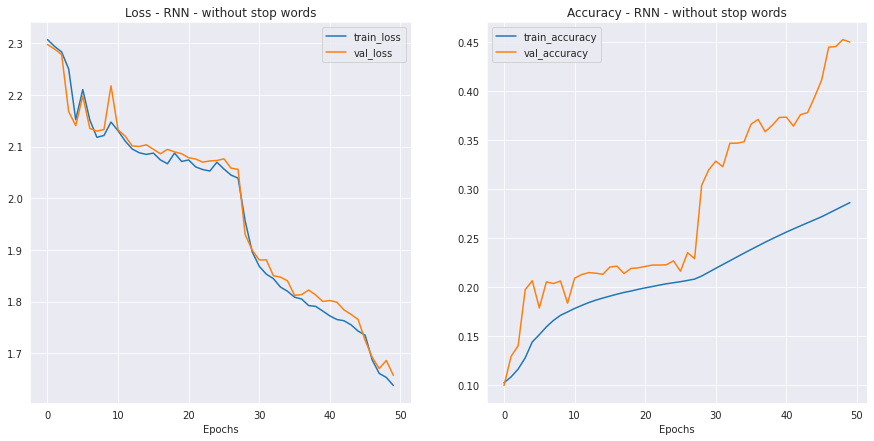

In [ ]:
# Apply function to our results
plot_loss_curves(results_rnn, "RNN - without stop words")

Inspecting the loss curves, we see a decreasing trend, which increases towards the middle. The decrease indicates that our model learns. However, we see a slight oscillating pattern, which might indicate there might be instability in our training. Additionally, the validation and training loss are close to each other, we can therefore assume that we are not overfitting on the training data. Furthermore, the training and validation accuracy of our model keep on increasing with some slight oscillating pattern in the validation accuracy. Since the accuracy still seems to increase towards the end and the loss to decrease, we even might train for a bit longer to improve our model even more. Evaluating our model on the validation dataset shows that it can generalize well and results in a higher validation accuracy than training accuracy. 

Let's next create the RNN with stop words and compare.

##### RNN with stop words

In [ ]:
epochs = 50
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_classifier_stopwords = RNNClassifier(word_embeddings_with_stopwords, n_layers=1)
#rnn_classifier = rnn_classifier.to(device)
rnn_classifier_stopwords.embedding_layer.weight.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(rnn_classifier_stopwords.parameters(), lr=learning_rate, weight_decay=1e-5)

results_rnn_stopwords = train_model(rnn_classifier_stopwords, loss_fn, optimizer, train_loader_with_stopwords, val_loader_with_stopwords, epochs)

EPOCH 1


100%|██████████| 59/59 [00:04<00:00, 13.44it/s]


Train Loss : 2.310
Train Acc  : 0.101
Valid Loss : 2.295
Valid Acc  : 0.113
EPOCH 2


100%|██████████| 59/59 [00:03<00:00, 17.16it/s]


Train Loss : 2.285
Train Acc  : 0.119
Valid Loss : 2.282
Valid Acc  : 0.148
EPOCH 3


100%|██████████| 59/59 [00:03<00:00, 17.48it/s]


Train Loss : 2.270
Train Acc  : 0.132
Valid Loss : 2.269
Valid Acc  : 0.166
EPOCH 4


100%|██████████| 59/59 [00:03<00:00, 17.35it/s]


Train Loss : 2.254
Train Acc  : 0.143
Valid Loss : 2.250
Valid Acc  : 0.188
EPOCH 5


100%|██████████| 59/59 [00:05<00:00, 11.13it/s]


Train Loss : 2.185
Train Acc  : 0.158
Valid Loss : 2.137
Valid Acc  : 0.251
EPOCH 6


100%|██████████| 59/59 [00:05<00:00, 10.86it/s]


Train Loss : 2.052
Train Acc  : 0.179
Valid Loss : 2.025
Valid Acc  : 0.311
EPOCH 7


100%|██████████| 59/59 [00:06<00:00,  9.57it/s]


Train Loss : 1.990
Train Acc  : 0.198
Valid Loss : 1.995
Valid Acc  : 0.304
EPOCH 8


100%|██████████| 59/59 [00:03<00:00, 16.96it/s]


Train Loss : 1.958
Train Acc  : 0.214
Valid Loss : 1.955
Valid Acc  : 0.321
EPOCH 9


100%|██████████| 59/59 [00:06<00:00,  9.50it/s]


Train Loss : 1.933
Train Acc  : 0.227
Valid Loss : 1.944
Valid Acc  : 0.327
EPOCH 10


100%|██████████| 59/59 [00:03<00:00, 17.27it/s]


Train Loss : 1.913
Train Acc  : 0.238
Valid Loss : 1.904
Valid Acc  : 0.332
EPOCH 11


100%|██████████| 59/59 [00:03<00:00, 17.39it/s]


Train Loss : 1.888
Train Acc  : 0.248
Valid Loss : 1.894
Valid Acc  : 0.341
EPOCH 12


100%|██████████| 59/59 [00:04<00:00, 13.34it/s]


Train Loss : 1.872
Train Acc  : 0.257
Valid Loss : 1.875
Valid Acc  : 0.362
EPOCH 13


100%|██████████| 59/59 [00:05<00:00, 10.28it/s]


Train Loss : 1.853
Train Acc  : 0.265
Valid Loss : 1.860
Valid Acc  : 0.370
EPOCH 14


100%|██████████| 59/59 [00:03<00:00, 17.54it/s]


Train Loss : 1.843
Train Acc  : 0.273
Valid Loss : 1.847
Valid Acc  : 0.367
EPOCH 15


100%|██████████| 59/59 [00:04<00:00, 14.33it/s]


Train Loss : 1.819
Train Acc  : 0.280
Valid Loss : 1.820
Valid Acc  : 0.390
EPOCH 16


100%|██████████| 59/59 [00:05<00:00, 10.92it/s]


Train Loss : 1.790
Train Acc  : 0.288
Valid Loss : 1.822
Valid Acc  : 0.381
EPOCH 17


100%|██████████| 59/59 [00:06<00:00,  9.37it/s]


Train Loss : 1.762
Train Acc  : 0.295
Valid Loss : 1.772
Valid Acc  : 0.405
EPOCH 18


100%|██████████| 59/59 [00:05<00:00, 10.58it/s]


Train Loss : 1.742
Train Acc  : 0.303
Valid Loss : 1.739
Valid Acc  : 0.430
EPOCH 19


100%|██████████| 59/59 [00:03<00:00, 15.12it/s]


Train Loss : 1.716
Train Acc  : 0.310
Valid Loss : 1.717
Valid Acc  : 0.428
EPOCH 20


100%|██████████| 59/59 [00:03<00:00, 17.51it/s]


Train Loss : 1.687
Train Acc  : 0.316
Valid Loss : 1.681
Valid Acc  : 0.439
EPOCH 21


100%|██████████| 59/59 [00:03<00:00, 17.60it/s]


Train Loss : 1.660
Train Acc  : 0.323
Valid Loss : 1.661
Valid Acc  : 0.452
EPOCH 22


100%|██████████| 59/59 [00:03<00:00, 17.61it/s]


Train Loss : 1.651
Train Acc  : 0.329
Valid Loss : 1.673
Valid Acc  : 0.444
EPOCH 23


100%|██████████| 59/59 [00:03<00:00, 17.48it/s]


Train Loss : 1.629
Train Acc  : 0.334
Valid Loss : 1.646
Valid Acc  : 0.450
EPOCH 24


100%|██████████| 59/59 [00:03<00:00, 17.73it/s]


Train Loss : 1.614
Train Acc  : 0.340
Valid Loss : 1.616
Valid Acc  : 0.458
EPOCH 25


100%|██████████| 59/59 [00:03<00:00, 17.51it/s]


Train Loss : 1.601
Train Acc  : 0.345
Valid Loss : 1.628
Valid Acc  : 0.460
EPOCH 26


100%|██████████| 59/59 [00:03<00:00, 17.56it/s]


Train Loss : 1.587
Train Acc  : 0.350
Valid Loss : 1.615
Valid Acc  : 0.467
EPOCH 27


100%|██████████| 59/59 [00:05<00:00, 11.35it/s]


Train Loss : 1.585
Train Acc  : 0.355
Valid Loss : 1.596
Valid Acc  : 0.472
EPOCH 28


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Train Loss : 1.567
Train Acc  : 0.359
Valid Loss : 1.578
Valid Acc  : 0.483
EPOCH 29


100%|██████████| 59/59 [00:03<00:00, 16.82it/s]


Train Loss : 1.566
Train Acc  : 0.364
Valid Loss : 1.582
Valid Acc  : 0.482
EPOCH 30


100%|██████████| 59/59 [00:03<00:00, 17.13it/s]


Train Loss : 1.562
Train Acc  : 0.368
Valid Loss : 1.574
Valid Acc  : 0.477
EPOCH 31


100%|██████████| 59/59 [00:04<00:00, 14.17it/s]


Train Loss : 1.552
Train Acc  : 0.372
Valid Loss : 1.581
Valid Acc  : 0.483
EPOCH 32


100%|██████████| 59/59 [00:03<00:00, 17.41it/s]


Train Loss : 1.547
Train Acc  : 0.376
Valid Loss : 1.567
Valid Acc  : 0.482
EPOCH 33


100%|██████████| 59/59 [00:04<00:00, 14.02it/s]


Train Loss : 1.547
Train Acc  : 0.379
Valid Loss : 1.562
Valid Acc  : 0.482
EPOCH 34


100%|██████████| 59/59 [00:03<00:00, 16.33it/s]


Train Loss : 1.537
Train Acc  : 0.383
Valid Loss : 1.579
Valid Acc  : 0.483
EPOCH 35


100%|██████████| 59/59 [00:03<00:00, 17.16it/s]


Train Loss : 1.537
Train Acc  : 0.386
Valid Loss : 1.583
Valid Acc  : 0.474
EPOCH 36


100%|██████████| 59/59 [00:03<00:00, 16.92it/s]


Train Loss : 1.534
Train Acc  : 0.389
Valid Loss : 1.558
Valid Acc  : 0.484
EPOCH 37


100%|██████████| 59/59 [00:03<00:00, 17.02it/s]


Train Loss : 1.529
Train Acc  : 0.392
Valid Loss : 1.566
Valid Acc  : 0.483
EPOCH 38


100%|██████████| 59/59 [00:03<00:00, 17.47it/s]


Train Loss : 1.529
Train Acc  : 0.395
Valid Loss : 1.538
Valid Acc  : 0.491
EPOCH 39


100%|██████████| 59/59 [00:03<00:00, 17.56it/s]


Train Loss : 1.522
Train Acc  : 0.398
Valid Loss : 1.572
Valid Acc  : 0.482
EPOCH 40


100%|██████████| 59/59 [00:03<00:00, 17.53it/s]


Train Loss : 1.522
Train Acc  : 0.400
Valid Loss : 1.564
Valid Acc  : 0.484
EPOCH 41


100%|██████████| 59/59 [00:03<00:00, 17.59it/s]


Train Loss : 1.515
Train Acc  : 0.403
Valid Loss : 1.556
Valid Acc  : 0.490
EPOCH 42


100%|██████████| 59/59 [00:03<00:00, 17.47it/s]


Train Loss : 1.518
Train Acc  : 0.405
Valid Loss : 1.531
Valid Acc  : 0.499
EPOCH 43


100%|██████████| 59/59 [00:03<00:00, 17.50it/s]


Train Loss : 1.510
Train Acc  : 0.407
Valid Loss : 1.551
Valid Acc  : 0.489
EPOCH 44


100%|██████████| 59/59 [00:03<00:00, 16.74it/s]


Train Loss : 1.502
Train Acc  : 0.410
Valid Loss : 1.542
Valid Acc  : 0.500
EPOCH 45


100%|██████████| 59/59 [00:05<00:00, 11.59it/s]


Train Loss : 1.503
Train Acc  : 0.412
Valid Loss : 1.550
Valid Acc  : 0.490
EPOCH 46


100%|██████████| 59/59 [00:05<00:00, 10.85it/s]


Train Loss : 1.502
Train Acc  : 0.414
Valid Loss : 1.529
Valid Acc  : 0.491
EPOCH 47


100%|██████████| 59/59 [00:04<00:00, 12.77it/s]


Train Loss : 1.498
Train Acc  : 0.416
Valid Loss : 1.540
Valid Acc  : 0.499
EPOCH 48


100%|██████████| 59/59 [00:03<00:00, 17.13it/s]


Train Loss : 1.507
Train Acc  : 0.418
Valid Loss : 1.555
Valid Acc  : 0.491
EPOCH 49


100%|██████████| 59/59 [00:03<00:00, 17.83it/s]


Train Loss : 1.494
Train Acc  : 0.420
Valid Loss : 1.535
Valid Acc  : 0.496
EPOCH 50


100%|██████████| 59/59 [00:03<00:00, 17.14it/s]


Train Loss : 1.497
Train Acc  : 0.422
Valid Loss : 1.532
Valid Acc  : 0.498


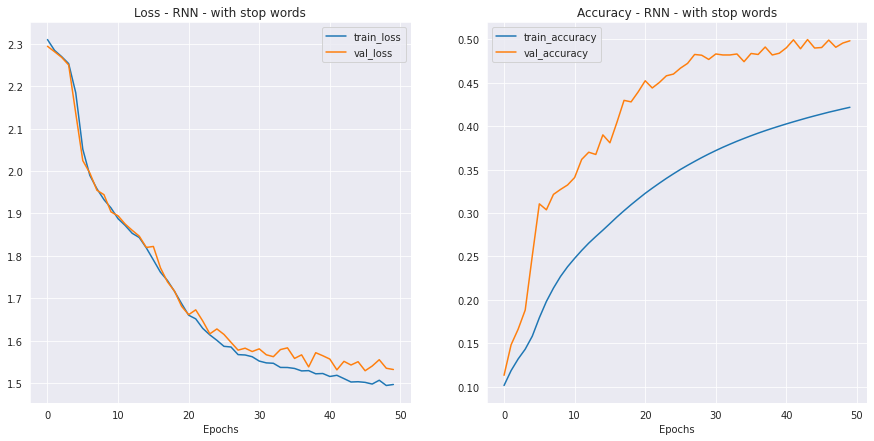

In [ ]:
plot_loss_curves(results_rnn_stopwords, "RNN - with stop words")

For the RNN with stop words, we already see that we get a higher validation accuracy than the RNN without stop words. This might indicate that a model with stop words might perform better, as stop words help with the contextualization of the text in our posts. Additionally, we see much better loss curves than our RNN without stop words. The training and validation losses are decreasing constantly, with only a slight oscillating pattern. However, towards the end we see a gap between the validation and training curve, this might indicate that we could be overfitting and our model might therefore not be generalizing well to new, unseen data. Inspecting the accuracy curves, we see that they keep on increasing. Generally, this means that we even could train our model for longer to increase the accuracy even more. However, we will continue with the evaluation of the two models in the next step.

#### Evaluation

Now that we have created our first two models, let's evaluate them.

Up to now, we handled our test dataset to be something that we can only touch in the future and should act as a real-world example for evaluating our model. Now is the future 😉 So, let's first preprocess our test data.

In [ ]:
# Display test data
yahoo_answers_test.head(3)

id  topic                                     question_title  \
0   3493      4  Is the registered version of  REGISTRY MECHANI...   
1  57546      4                  what is better windows xp or mac?   
2   8815      3  What is the name of the current president of t...   

                                    question_content  \
0               Or is  the free version good enough?   
1                                                      
2  What is the name of the current president of t...   

                                         best_answer            topic_label  
0  D E F I N I T E L Y !!! I happened across Regi...   Computers & Internet  
1                              Definitely windows xp   Computers & Internet  
2  George W. Bush is the current president and Ri...  Education & Reference

In [ ]:
# Concatenate text variables
yahoo_answers_test['whole_text'] = yahoo_answers_test['question_title'] + yahoo_answers_test['question_content'] + yahoo_answers_test['best_answer']

# Clean the text
yahoo_answers_test['whole_text_cleaned'] = yahoo_answers_test['whole_text'].apply(lambda x: clean_text_for_preprocessing(x, stopwords_removed=True))

# Tokenize the words
yahoo_answers_test['tokens'] = yahoo_answers_test['whole_text_cleaned'].apply(lambda x: word_tokenize(x))

# Preprocess to dataformat
test_data = preprocess_data_to_dataformat(yahoo_answers_test['tokens'], yahoo_answers_test['topic'])
test_data_with_stopwords = preprocess_data_to_dataformat(yahoo_answers_test['tokens'], yahoo_answers_test['topic'])

# Assign embeddings and pad tokens
assign_embedding_pad_token(test_data, word2index)
assign_embedding_pad_token(test_data_with_stopwords, word2index_with_stopwords)

# Convert dictionaries into tuples of values
test_data = [(v['category'], v['word_index']) for v in test_data]
test_data_with_stopwords = [(v['category'], v['word_index']) for v in test_data_with_stopwords]

# Create loader object
test_loader  = DataLoader(test_data , batch_size=256, collate_fn=vectorize_batch)
test_loader_with_stopwords  = DataLoader(test_data_with_stopwords , batch_size=256, collate_fn=vectorize_batch)

Now that we have preprocessed our test data for evaluation, we can test our model. Since this will be a task that we will do for every model, we will create a function that can be used to make predictions and a function that will plot the confusion matrix of the results.

In [ ]:
# Create prediction function
def make_predictions(model, loader, target_classes):
  """
  Predicts data from loader on a model.
  Prints and returns accuracy, classification report and confussion matrix.
  Additionally, Y_preds and Y_actual are returned.
  """
  Y_shuffled = []
  Y_preds = []

  # Predict
  for X, Y in loader:
      preds = model(X)
      Y_preds.append(preds)
      Y_shuffled.append(Y)
  gc.collect()
  Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

  Y_actual = Y_shuffled.detach().numpy()
  Y_preds = F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()
  
  # Metrics and reports
  accuracy = accuracy_score(Y_actual, Y_preds)
  class_rep = classification_report(Y_actual, Y_preds, target_names=target_classes)
  class_rep_dict = classification_report(Y_actual, Y_preds, target_names=target_classes, output_dict=True)
  conf_mat = confusion_matrix(Y_actual, Y_preds)

  print(f"Test Accuracy : {accuracy:.3f}".format(accuracy))
  print("\nClassification Report: ")
  print(class_rep)
  print("\nConfusion Matrix: ")
  print(conf_mat)

  return accuracy, class_rep_dict, conf_mat, Y_actual, Y_preds

In [ ]:
# Create function to create confusion matrix
def create_confusion_matrix(Y_actual, Y_preds, categories):
  """
  Create confusion matrix of predition scores
  """
  skplt.metrics.plot_confusion_matrix([categories[i] for i in Y_actual], [categories[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="RdYlGn",
                                    hide_zeros=True,
                                    figsize=(8, 8)
                                    );
  plt.xticks(rotation=90);


We are now ready to evaluate our model on the test set. Let's do this!

In [ ]:
# Create categories dict
categories = list(topic_dict.values())

# Evaluate rnn_classifier
accuracy_rnn, class_rep_rnn, conf_mat_rnn, Y_actual_rnn, Y_preds_rnn = make_predictions(rnn_classifier, test_loader, categories)

Test Accuracy : 0.462

Classification Report: 
                        precision    recall  f1-score   support

     Society & Culture       0.45      0.15      0.22       378
 Science & Mathematics       0.57      0.65      0.61       353
                Health       0.52      0.54      0.53       351
 Education & Reference       0.15      0.01      0.02       315
  Computers & Internet       0.59      0.79      0.68       370
                Sports       0.55      0.76      0.64       329
    Business & Finance       0.37      0.23      0.28       355
 Entertainment & Music       0.46      0.23      0.31       341
Family & Relationships       0.36      0.59      0.44       344
 Politics & Government       0.34      0.64      0.45       364

              accuracy                           0.46      3500
             macro avg       0.44      0.46      0.42      3500
          weighted avg       0.44      0.46      0.42      3500


Confusion Matrix: 
[[ 55  10  31   2  13  17   8  16 

In [ ]:
# Evaluate rnn_classifier_stopwords
accuracy_rnn_stopwords, class_rep_rnn_stopwords, conf_mat_rnn_stopwords, Y_actual_rnn_stopwords, Y_preds_rnn_stopwords = make_predictions(rnn_classifier_stopwords, test_loader_with_stopwords, categories)

Test Accuracy : 0.499

Classification Report: 
                        precision    recall  f1-score   support

     Society & Culture       0.53      0.20      0.30       378
 Science & Mathematics       0.61      0.60      0.61       353
                Health       0.61      0.66      0.63       351
 Education & Reference       0.26      0.12      0.16       315
  Computers & Internet       0.58      0.82      0.68       370
                Sports       0.58      0.76      0.66       329
    Business & Finance       0.44      0.26      0.32       355
 Entertainment & Music       0.30      0.57      0.40       341
Family & Relationships       0.45      0.39      0.42       344
 Politics & Government       0.58      0.59      0.58       364

              accuracy                           0.50      3500
             macro avg       0.49      0.50      0.48      3500
          weighted avg       0.50      0.50      0.48      3500


Confusion Matrix: 
[[ 77  13  19   7  30  18  14  85 

Testing our models on the test data shows that the model with stop words performs better and achieves an accuracy of 49.9% whereas our model without stop words archives an accuracy of 46.2.%. Furthermore, we can inspect the precision, recall, and f1-scores of both models. 



Precision represents the proportion of positive predictions that are actually correct. Precision is calculated the following way: `Precision = (True Positives) / (True Positives + False Positives)`. Inspecting the precision for both models, we see that the precision for some classes is not very good. Both models seem to have problems with posts from `Education & Reference`. On the other hand, `Computers & Internet` seem to have the highest precision for our model without stop words, and `Science & Mathematics` as well as `Health` for our model with stop words. These categories have therefore the lowest false positive rates in the model.



Recall represents the proportion of actual positive examples that were correctly classified. Recall is calculated the following way: `Recall = (True Positives) / (True Positives + False Negatives)`. Inspecting the recall for both models, we see that the recall for some classes is not very good as well. Both models seem to have problems with again posts from `Education & Reference`. On the other hand, `Computers & Internet` and `Sport` seem to have the highest recalls in both models, and both models are therefore to correctly identify and classify a high proportion of the posts that belong to these categories.



The combination of recall and precision is then seen in the f1-score. The f1-score is calculated the followng way: `F1 = 2 * (Precision * Recall) / (Precision + Recall)`. For both models, the f1-score is the highest for `Computers & Internet`, meaning that both models perform the best on this category.

Let's next plot the confusion matrixes for both models. A confusion matrix helps to visualize the performance of a classification model and provides counts of the true positive, true negative, false positive, and false negative predictions made by the model. With the help of it, we can, for example, see which categories were mostly classified for false predictions.

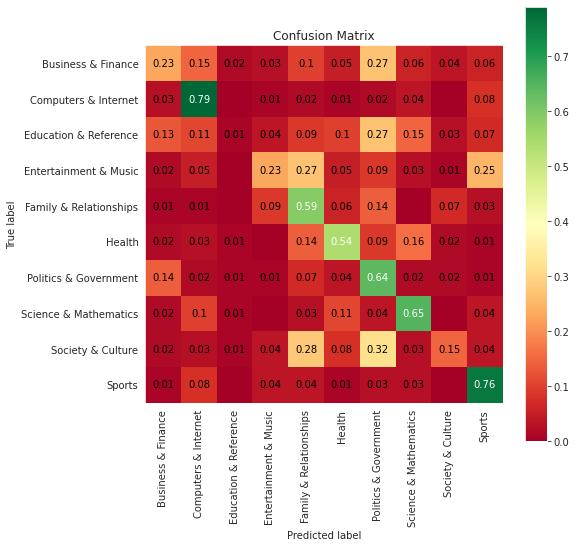

In [ ]:
# Plot RNN without stop words
create_confusion_matrix(Y_actual_rnn, Y_preds_rnn, categories)

We see that the model performed best on `Computers & Internet` and `Sport`. Additionally, we see that around 10%  of `Science & Mathematics`  posts were classified as the category `Computers & Internet`. This characteristic can also be seen in the 32% of posts of `Society & Culture` that were classified to belong to `Politics & Government`.

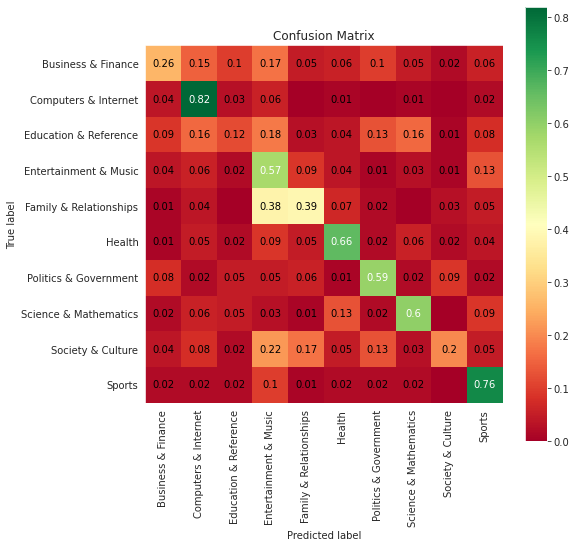

In [ ]:
# Plot RNN with stop words
create_confusion_matrix(Y_actual_rnn_stopwords, Y_preds_rnn_stopwords, categories)

For our RNN with stop words, we see that many of the posts of `Family & Relationships` were classified as `Entertainment & Music`. Additionally,  to `Family & Relationship`, the model performed not very well on `Business & Finance`, `Education & Reference`, and `Society & Culture` by classifying less than 50% of the posts correctly.

### Adjust our RNN - Add more layers

Now that we have built our baseline model, let's tune it a bit. We will therefore create another model, but this time we will increase the RNN layers to 3. After this, we will then evaluate which dataset is delivering better results and continue only with the related dataset for our other models.

#### RNN without stop words - 3 layer RNN

In [ ]:
epochs = 50
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_classifier_2 = RNNClassifier(word_embeddings, n_layers=3)
#rnn_classifier = rnn_classifier.to(device)
rnn_classifier_2.embedding_layer.weight.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(rnn_classifier_2.parameters(), lr=learning_rate, weight_decay=1e-5)

results_rnn_2 = train_model(rnn_classifier_2, loss_fn, optimizer, train_loader, val_loader, epochs)

EPOCH 1


100%|██████████| 59/59 [00:10<00:00,  5.86it/s]


Train Loss : 2.300
Train Acc  : 0.105
Valid Loss : 2.290
Valid Acc  : 0.131
EPOCH 2


100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


Train Loss : 2.270
Train Acc  : 0.125
Valid Loss : 2.179
Valid Acc  : 0.201
EPOCH 3


100%|██████████| 59/59 [00:14<00:00,  4.18it/s]


Train Loss : 2.122
Train Acc  : 0.150
Valid Loss : 2.107
Valid Acc  : 0.191
EPOCH 4


100%|██████████| 59/59 [00:14<00:00,  4.19it/s]


Train Loss : 2.042
Train Acc  : 0.172
Valid Loss : 1.987
Valid Acc  : 0.280
EPOCH 5


100%|██████████| 59/59 [00:13<00:00,  4.34it/s]


Train Loss : 1.938
Train Acc  : 0.200
Valid Loss : 1.981
Valid Acc  : 0.302
EPOCH 6


100%|██████████| 59/59 [00:13<00:00,  4.46it/s]


Train Loss : 1.982
Train Acc  : 0.213
Valid Loss : 1.964
Valid Acc  : 0.296
EPOCH 7


100%|██████████| 59/59 [00:09<00:00,  6.20it/s]


Train Loss : 1.966
Train Acc  : 0.224
Valid Loss : 1.956
Valid Acc  : 0.293
EPOCH 8


100%|██████████| 59/59 [00:09<00:00,  6.23it/s]


Train Loss : 1.936
Train Acc  : 0.233
Valid Loss : 1.977
Valid Acc  : 0.289
EPOCH 9


100%|██████████| 59/59 [00:09<00:00,  6.32it/s]


Train Loss : 1.933
Train Acc  : 0.242
Valid Loss : 1.918
Valid Acc  : 0.303
EPOCH 10


100%|██████████| 59/59 [00:10<00:00,  5.65it/s]


Train Loss : 1.915
Train Acc  : 0.249
Valid Loss : 1.892
Valid Acc  : 0.316
EPOCH 11


100%|██████████| 59/59 [00:09<00:00,  6.15it/s]


Train Loss : 1.889
Train Acc  : 0.256
Valid Loss : 1.887
Valid Acc  : 0.319
EPOCH 12


100%|██████████| 59/59 [00:09<00:00,  6.17it/s]


Train Loss : 1.921
Train Acc  : 0.261
Valid Loss : 1.974
Valid Acc  : 0.286
EPOCH 13


100%|██████████| 59/59 [00:09<00:00,  6.30it/s]


Train Loss : 1.907
Train Acc  : 0.265
Valid Loss : 1.894
Valid Acc  : 0.299
EPOCH 14


100%|██████████| 59/59 [00:09<00:00,  6.24it/s]


Train Loss : 1.871
Train Acc  : 0.270
Valid Loss : 1.874
Valid Acc  : 0.317
EPOCH 15


100%|██████████| 59/59 [00:10<00:00,  5.58it/s]


Train Loss : 1.882
Train Acc  : 0.273
Valid Loss : 1.915
Valid Acc  : 0.305
EPOCH 16


100%|██████████| 59/59 [00:09<00:00,  6.26it/s]


Train Loss : 1.880
Train Acc  : 0.277
Valid Loss : 1.865
Valid Acc  : 0.334
EPOCH 17


100%|██████████| 59/59 [00:09<00:00,  6.26it/s]


Train Loss : 1.871
Train Acc  : 0.280
Valid Loss : 1.867
Valid Acc  : 0.325
EPOCH 18


100%|██████████| 59/59 [00:09<00:00,  6.32it/s]


Train Loss : 1.834
Train Acc  : 0.284
Valid Loss : 1.895
Valid Acc  : 0.296
EPOCH 19


100%|██████████| 59/59 [00:11<00:00,  5.23it/s]


Train Loss : 1.879
Train Acc  : 0.286
Valid Loss : 1.854
Valid Acc  : 0.312
EPOCH 20


100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


Train Loss : 1.819
Train Acc  : 0.288
Valid Loss : 1.834
Valid Acc  : 0.335
EPOCH 21


100%|██████████| 59/59 [00:09<00:00,  6.28it/s]


Train Loss : 1.849
Train Acc  : 0.290
Valid Loss : 1.855
Valid Acc  : 0.330
EPOCH 22


100%|██████████| 59/59 [00:09<00:00,  6.33it/s]


Train Loss : 1.816
Train Acc  : 0.293
Valid Loss : 1.841
Valid Acc  : 0.319
EPOCH 23


100%|██████████| 59/59 [00:09<00:00,  6.30it/s]


Train Loss : 1.888
Train Acc  : 0.293
Valid Loss : 1.863
Valid Acc  : 0.319
EPOCH 24


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Train Loss : 1.897
Train Acc  : 0.293
Valid Loss : 1.843
Valid Acc  : 0.336
EPOCH 25


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Train Loss : 1.819
Train Acc  : 0.296
Valid Loss : 1.840
Valid Acc  : 0.333
EPOCH 26


100%|██████████| 59/59 [00:09<00:00,  6.26it/s]


Train Loss : 1.865
Train Acc  : 0.297
Valid Loss : 2.138
Valid Acc  : 0.206
EPOCH 27


100%|██████████| 59/59 [00:09<00:00,  6.26it/s]


Train Loss : 2.039
Train Acc  : 0.296
Valid Loss : 1.996
Valid Acc  : 0.288
EPOCH 28


100%|██████████| 59/59 [00:09<00:00,  6.30it/s]


Train Loss : 1.909
Train Acc  : 0.297
Valid Loss : 1.906
Valid Acc  : 0.307
EPOCH 29


100%|██████████| 59/59 [00:09<00:00,  6.30it/s]


Train Loss : 1.879
Train Acc  : 0.298
Valid Loss : 1.900
Valid Acc  : 0.307
EPOCH 30


100%|██████████| 59/59 [00:10<00:00,  5.82it/s]


Train Loss : 1.888
Train Acc  : 0.299
Valid Loss : 1.903
Valid Acc  : 0.307
EPOCH 31


100%|██████████| 59/59 [00:10<00:00,  5.46it/s]


Train Loss : 1.885
Train Acc  : 0.299
Valid Loss : 1.910
Valid Acc  : 0.305
EPOCH 32


100%|██████████| 59/59 [00:09<00:00,  6.42it/s]


Train Loss : 1.881
Train Acc  : 0.300
Valid Loss : 1.893
Valid Acc  : 0.315
EPOCH 33


100%|██████████| 59/59 [00:09<00:00,  6.25it/s]


Train Loss : 1.887
Train Acc  : 0.301
Valid Loss : 1.917
Valid Acc  : 0.300
EPOCH 34


100%|██████████| 59/59 [00:09<00:00,  6.21it/s]


Train Loss : 1.888
Train Acc  : 0.302
Valid Loss : 1.896
Valid Acc  : 0.313
EPOCH 35


100%|██████████| 59/59 [00:09<00:00,  6.29it/s]


Train Loss : 1.876
Train Acc  : 0.302
Valid Loss : 1.889
Valid Acc  : 0.313
EPOCH 36


100%|██████████| 59/59 [00:09<00:00,  6.18it/s]


Train Loss : 1.869
Train Acc  : 0.303
Valid Loss : 1.894
Valid Acc  : 0.321
EPOCH 37


100%|██████████| 59/59 [00:09<00:00,  6.44it/s]


Train Loss : 1.883
Train Acc  : 0.304
Valid Loss : 1.874
Valid Acc  : 0.325
EPOCH 38


100%|██████████| 59/59 [00:09<00:00,  6.21it/s]


Train Loss : 1.876
Train Acc  : 0.305
Valid Loss : 1.964
Valid Acc  : 0.296
EPOCH 39


100%|██████████| 59/59 [00:09<00:00,  6.48it/s]


Train Loss : 1.905
Train Acc  : 0.305
Valid Loss : 1.891
Valid Acc  : 0.320
EPOCH 40


100%|██████████| 59/59 [00:09<00:00,  6.39it/s]


Train Loss : 1.877
Train Acc  : 0.306
Valid Loss : 1.883
Valid Acc  : 0.326
EPOCH 41


100%|██████████| 59/59 [00:09<00:00,  6.22it/s]


Train Loss : 1.851
Train Acc  : 0.307
Valid Loss : 1.897
Valid Acc  : 0.324
EPOCH 42


100%|██████████| 59/59 [00:09<00:00,  6.18it/s]


Train Loss : 1.872
Train Acc  : 0.307
Valid Loss : 1.873
Valid Acc  : 0.329
EPOCH 43


100%|██████████| 59/59 [00:09<00:00,  6.34it/s]


Train Loss : 1.847
Train Acc  : 0.308
Valid Loss : 1.849
Valid Acc  : 0.333
EPOCH 44


100%|██████████| 59/59 [00:09<00:00,  6.29it/s]


Train Loss : 2.010
Train Acc  : 0.307
Valid Loss : 2.046
Valid Acc  : 0.234
EPOCH 45


100%|██████████| 59/59 [00:09<00:00,  6.39it/s]


Train Loss : 2.020
Train Acc  : 0.305
Valid Loss : 2.036
Valid Acc  : 0.252
EPOCH 46


100%|██████████| 59/59 [00:09<00:00,  6.34it/s]


Train Loss : 2.006
Train Acc  : 0.304
Valid Loss : 1.985
Valid Acc  : 0.256
EPOCH 47


100%|██████████| 59/59 [00:09<00:00,  6.28it/s]


Train Loss : 1.993
Train Acc  : 0.304
Valid Loss : 2.123
Valid Acc  : 0.221
EPOCH 48


100%|██████████| 59/59 [00:10<00:00,  5.40it/s]


Train Loss : 1.948
Train Acc  : 0.304
Valid Loss : 1.959
Valid Acc  : 0.313
EPOCH 49


100%|██████████| 59/59 [00:09<00:00,  6.19it/s]


Train Loss : 1.933
Train Acc  : 0.304
Valid Loss : 1.987
Valid Acc  : 0.295
EPOCH 50


100%|██████████| 59/59 [00:09<00:00,  6.38it/s]


Train Loss : 1.946
Train Acc  : 0.304
Valid Loss : 1.953
Valid Acc  : 0.299


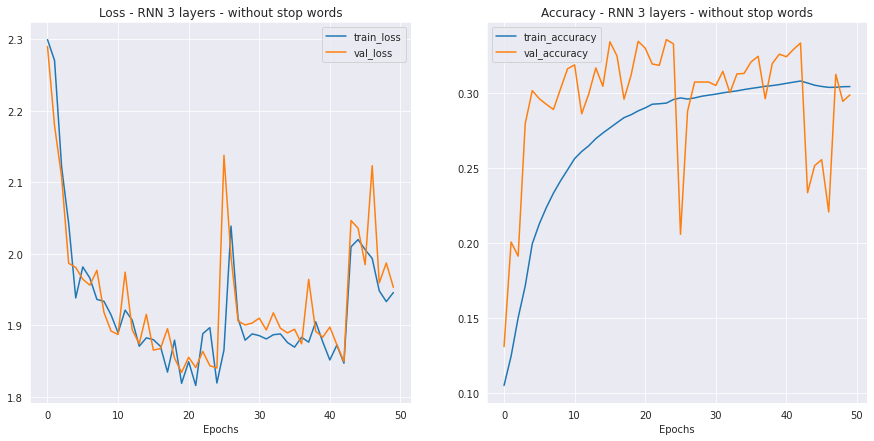

In [ ]:
# Plot curves
plot_loss_curves(results_rnn_2, "RNN 3 layers - without stop words")

Compared to the first model, we see a much higher oscillating pattern in the loss curves. Additionally, the accuracy seems to flatten at the end and even decrease again. This for sure does not look like a good model for the posts without stop words. Our model is probably too complex for the data.

How about the new RNN model for our data with stop words?

#### RNN with stop words - 3 layer RNN

In [ ]:
epochs = 50
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_classifier_stopwords_2 = RNNClassifier(word_embeddings_with_stopwords, n_layers=3)
#rnn_classifier = rnn_classifier.to(device)
rnn_classifier_stopwords_2.embedding_layer.weight.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(rnn_classifier_stopwords_2.parameters(), lr=learning_rate, weight_decay=1e-5)

results_rnn_stopwords_2 = train_model(rnn_classifier_stopwords_2, loss_fn, optimizer, train_loader_with_stopwords, val_loader_with_stopwords, epochs)

EPOCH 1


100%|██████████| 59/59 [00:10<00:00,  5.58it/s]


Train Loss : 2.299
Train Acc  : 0.117
Valid Loss : 2.284
Valid Acc  : 0.132
EPOCH 2


100%|██████████| 59/59 [00:09<00:00,  6.22it/s]


Train Loss : 2.269
Train Acc  : 0.139
Valid Loss : 2.246
Valid Acc  : 0.181
EPOCH 3


100%|██████████| 59/59 [00:09<00:00,  6.29it/s]


Train Loss : 2.178
Train Acc  : 0.156
Valid Loss : 2.132
Valid Acc  : 0.217
EPOCH 4


100%|██████████| 59/59 [00:09<00:00,  6.33it/s]


Train Loss : 2.072
Train Acc  : 0.178
Valid Loss : 2.022
Valid Acc  : 0.277
EPOCH 5


100%|██████████| 59/59 [00:09<00:00,  6.39it/s]


Train Loss : 1.950
Train Acc  : 0.202
Valid Loss : 1.944
Valid Acc  : 0.309
EPOCH 6


100%|██████████| 59/59 [00:09<00:00,  6.34it/s]


Train Loss : 1.873
Train Acc  : 0.223
Valid Loss : 1.861
Valid Acc  : 0.336
EPOCH 7


100%|██████████| 59/59 [00:09<00:00,  6.33it/s]


Train Loss : 1.829
Train Acc  : 0.241
Valid Loss : 1.847
Valid Acc  : 0.359
EPOCH 8


100%|██████████| 59/59 [00:09<00:00,  6.25it/s]


Train Loss : 1.806
Train Acc  : 0.255
Valid Loss : 1.790
Valid Acc  : 0.361
EPOCH 9


100%|██████████| 59/59 [00:09<00:00,  6.45it/s]


Train Loss : 1.760
Train Acc  : 0.269
Valid Loss : 1.746
Valid Acc  : 0.398
EPOCH 10


100%|██████████| 59/59 [00:09<00:00,  6.39it/s]


Train Loss : 1.737
Train Acc  : 0.282
Valid Loss : 1.768
Valid Acc  : 0.394
EPOCH 11


100%|██████████| 59/59 [00:09<00:00,  6.30it/s]


Train Loss : 1.696
Train Acc  : 0.295
Valid Loss : 1.702
Valid Acc  : 0.419
EPOCH 12


100%|██████████| 59/59 [00:09<00:00,  6.33it/s]


Train Loss : 1.671
Train Acc  : 0.306
Valid Loss : 1.660
Valid Acc  : 0.438
EPOCH 13


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Train Loss : 1.641
Train Acc  : 0.317
Valid Loss : 1.640
Valid Acc  : 0.444
EPOCH 14


100%|██████████| 59/59 [00:09<00:00,  6.38it/s]


Train Loss : 1.610
Train Acc  : 0.327
Valid Loss : 1.626
Valid Acc  : 0.455
EPOCH 15


100%|██████████| 59/59 [00:10<00:00,  5.38it/s]


Train Loss : 1.596
Train Acc  : 0.336
Valid Loss : 1.609
Valid Acc  : 0.452
EPOCH 16


100%|██████████| 59/59 [00:09<00:00,  6.41it/s]


Train Loss : 1.596
Train Acc  : 0.344
Valid Loss : 1.608
Valid Acc  : 0.458
EPOCH 17


100%|██████████| 59/59 [00:09<00:00,  6.29it/s]


Train Loss : 1.568
Train Acc  : 0.352
Valid Loss : 1.580
Valid Acc  : 0.469
EPOCH 18


100%|██████████| 59/59 [00:09<00:00,  6.41it/s]


Train Loss : 1.551
Train Acc  : 0.359
Valid Loss : 1.574
Valid Acc  : 0.473
EPOCH 19


100%|██████████| 59/59 [00:09<00:00,  6.45it/s]


Train Loss : 1.548
Train Acc  : 0.365
Valid Loss : 1.530
Valid Acc  : 0.490
EPOCH 20


100%|██████████| 59/59 [00:09<00:00,  6.30it/s]


Train Loss : 1.531
Train Acc  : 0.371
Valid Loss : 1.553
Valid Acc  : 0.480
EPOCH 21


100%|██████████| 59/59 [00:09<00:00,  6.29it/s]


Train Loss : 1.541
Train Acc  : 0.377
Valid Loss : 1.571
Valid Acc  : 0.466
EPOCH 22


100%|██████████| 59/59 [00:15<00:00,  3.83it/s]


Train Loss : 1.531
Train Acc  : 0.382
Valid Loss : 1.537
Valid Acc  : 0.487
EPOCH 23


100%|██████████| 59/59 [00:09<00:00,  6.30it/s]


Train Loss : 1.514
Train Acc  : 0.387
Valid Loss : 1.522
Valid Acc  : 0.494
EPOCH 24


100%|██████████| 59/59 [00:09<00:00,  6.33it/s]


Train Loss : 1.501
Train Acc  : 0.392
Valid Loss : 1.548
Valid Acc  : 0.471
EPOCH 25


100%|██████████| 59/59 [00:09<00:00,  6.34it/s]


Train Loss : 1.513
Train Acc  : 0.396
Valid Loss : 1.524
Valid Acc  : 0.495
EPOCH 26


100%|██████████| 59/59 [00:09<00:00,  6.44it/s]


Train Loss : 1.497
Train Acc  : 0.400
Valid Loss : 1.501
Valid Acc  : 0.499
EPOCH 27


100%|██████████| 59/59 [00:09<00:00,  6.32it/s]


Train Loss : 1.486
Train Acc  : 0.404
Valid Loss : 1.513
Valid Acc  : 0.497
EPOCH 28


100%|██████████| 59/59 [00:09<00:00,  6.39it/s]


Train Loss : 1.483
Train Acc  : 0.408
Valid Loss : 1.509
Valid Acc  : 0.495
EPOCH 29


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Train Loss : 1.482
Train Acc  : 0.411
Valid Loss : 1.488
Valid Acc  : 0.501
EPOCH 30


100%|██████████| 59/59 [00:09<00:00,  6.31it/s]


Train Loss : 1.483
Train Acc  : 0.414
Valid Loss : 1.491
Valid Acc  : 0.495
EPOCH 31


100%|██████████| 59/59 [00:09<00:00,  6.47it/s]


Train Loss : 1.475
Train Acc  : 0.417
Valid Loss : 1.502
Valid Acc  : 0.500
EPOCH 32


100%|██████████| 59/59 [00:16<00:00,  3.53it/s]


Train Loss : 1.484
Train Acc  : 0.420
Valid Loss : 1.512
Valid Acc  : 0.497
EPOCH 33


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Train Loss : 1.471
Train Acc  : 0.423
Valid Loss : 1.471
Valid Acc  : 0.511
EPOCH 34


100%|██████████| 59/59 [00:09<00:00,  6.27it/s]


Train Loss : 1.456
Train Acc  : 0.426
Valid Loss : 1.489
Valid Acc  : 0.503
EPOCH 35


100%|██████████| 59/59 [00:09<00:00,  6.41it/s]


Train Loss : 1.455
Train Acc  : 0.428
Valid Loss : 1.556
Valid Acc  : 0.481
EPOCH 36


100%|██████████| 59/59 [00:11<00:00,  5.24it/s]


Train Loss : 1.450
Train Acc  : 0.431
Valid Loss : 1.469
Valid Acc  : 0.508
EPOCH 37


100%|██████████| 59/59 [00:10<00:00,  5.45it/s]


Train Loss : 1.444
Train Acc  : 0.433
Valid Loss : 1.447
Valid Acc  : 0.520
EPOCH 38


100%|██████████| 59/59 [00:09<00:00,  6.33it/s]


Train Loss : 1.434
Train Acc  : 0.436
Valid Loss : 1.461
Valid Acc  : 0.511
EPOCH 39


100%|██████████| 59/59 [00:11<00:00,  4.92it/s]


Train Loss : 1.432
Train Acc  : 0.438
Valid Loss : 1.431
Valid Acc  : 0.527
EPOCH 40


100%|██████████| 59/59 [00:10<00:00,  5.44it/s]


Train Loss : 1.423
Train Acc  : 0.441
Valid Loss : 1.453
Valid Acc  : 0.515
EPOCH 41


100%|██████████| 59/59 [00:09<00:00,  6.28it/s]


Train Loss : 1.421
Train Acc  : 0.443
Valid Loss : 1.445
Valid Acc  : 0.519
EPOCH 42


100%|██████████| 59/59 [00:09<00:00,  6.41it/s]


Train Loss : 1.407
Train Acc  : 0.445
Valid Loss : 1.420
Valid Acc  : 0.532
EPOCH 43


100%|██████████| 59/59 [00:13<00:00,  4.34it/s]


Train Loss : 1.407
Train Acc  : 0.447
Valid Loss : 1.433
Valid Acc  : 0.525
EPOCH 44


100%|██████████| 59/59 [00:09<00:00,  6.21it/s]


Train Loss : 1.400
Train Acc  : 0.449
Valid Loss : 1.434
Valid Acc  : 0.520
EPOCH 45


100%|██████████| 59/59 [00:09<00:00,  6.35it/s]


Train Loss : 1.403
Train Acc  : 0.451
Valid Loss : 1.415
Valid Acc  : 0.531
EPOCH 46


100%|██████████| 59/59 [00:09<00:00,  6.35it/s]


Train Loss : 1.400
Train Acc  : 0.453
Valid Loss : 1.414
Valid Acc  : 0.536
EPOCH 47


100%|██████████| 59/59 [00:10<00:00,  5.48it/s]


Train Loss : 1.395
Train Acc  : 0.455
Valid Loss : 1.430
Valid Acc  : 0.524
EPOCH 48


100%|██████████| 59/59 [00:08<00:00,  6.57it/s]


Train Loss : 1.396
Train Acc  : 0.457
Valid Loss : 1.489
Valid Acc  : 0.500
EPOCH 49


100%|██████████| 59/59 [00:09<00:00,  6.39it/s]


Train Loss : 1.397
Train Acc  : 0.458
Valid Loss : 1.410
Valid Acc  : 0.529
EPOCH 50


100%|██████████| 59/59 [00:09<00:00,  6.50it/s]


Train Loss : 1.401
Train Acc  : 0.460
Valid Loss : 1.428
Valid Acc  : 0.517


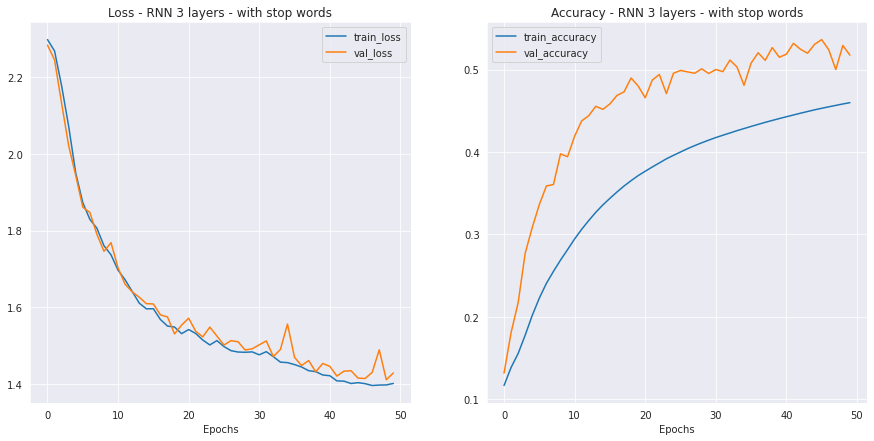

In [ ]:
# Plot curves
plot_loss_curves(results_rnn_stopwords_2, "RNN 3 layers - with stop words")

For the new RNN with stop words, we see that the validation loss is oscillating more than our first model. Nevertheless, the curves look good as they keep on decreasing and point to that our model is learning. On the other hand, the accuracy seems again to increase, with somewhat of a visible plateau in the validation accuracy that could be reached after the last couple of epochs. Generally, we observe again the higher validation accuracy as the training accuracy. This can come from the dropout layers that we use on the training set, and therefore result in a different behavior for training and validation ([see discussion](https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras)). 

Let's next evaluate both models on the test data.


#### Evaluation

In [ ]:
# Evaluate rnn_classifier_2
accuracy_rnn_2, class_rep_rnn_2, conf_mat_rnn_2, Y_actual_rnn_2, Y_preds_rnn_2 = make_predictions(rnn_classifier_2, test_loader, categories)

Test Accuracy : 0.302

Classification Report: 
                        precision    recall  f1-score   support

     Society & Culture       0.21      0.10      0.14       378
 Science & Mathematics       0.35      0.72      0.47       353
                Health       0.25      0.24      0.24       351
 Education & Reference       0.00      0.00      0.00       315
  Computers & Internet       0.38      0.75      0.51       370
                Sports       0.28      0.66      0.39       329
    Business & Finance       0.12      0.01      0.03       355
 Entertainment & Music       0.00      0.00      0.00       341
Family & Relationships       0.25      0.45      0.32       344
 Politics & Government       0.38      0.06      0.10       364

              accuracy                           0.30      3500
             macro avg       0.22      0.30      0.22      3500
          weighted avg       0.23      0.30      0.22      3500


Confusion Matrix: 
[[ 39  45  47   0  25  73   9   0 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [ ]:
# Evaluate rnn_classifier_stopwords_2
accuracy_rnn_stopwords_2, class_rep_rnn_stopwords_2, conf_mat_rnn_stopwords_2, Y_actual_rnn_stopwords_2, Y_preds_rnn_stopwords_2 = make_predictions(rnn_classifier_stopwords_2, test_loader_with_stopwords, categories)

Test Accuracy : 0.522

Classification Report: 
                        precision    recall  f1-score   support

     Society & Culture       0.57      0.36      0.44       378
 Science & Mathematics       0.67      0.43      0.53       353
                Health       0.50      0.74      0.59       351
 Education & Reference       0.29      0.20      0.23       315
  Computers & Internet       0.83      0.60      0.70       370
                Sports       0.71      0.71      0.71       329
    Business & Finance       0.33      0.47      0.39       355
 Entertainment & Music       0.42      0.54      0.47       341
Family & Relationships       0.51      0.57      0.54       344
 Politics & Government       0.58      0.59      0.58       364

              accuracy                           0.52      3500
             macro avg       0.54      0.52      0.52      3500
          weighted avg       0.54      0.52      0.52      3500


Confusion Matrix: 
[[136   8  26  29   4   5  40  44 

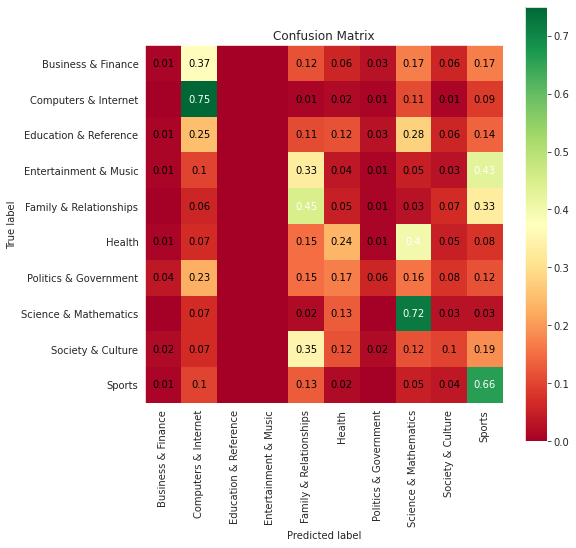

In [ ]:
# Plot RNN_2 without stop words
create_confusion_matrix(Y_actual_rnn_2, Y_preds_rnn_2, categories)

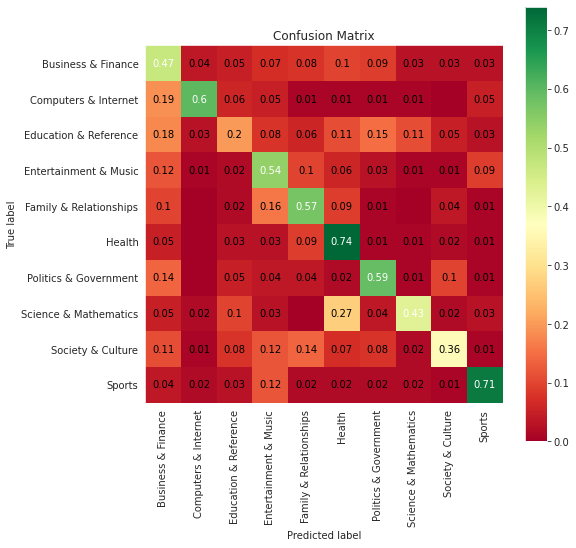

In [ ]:
# Plot RNN_2 with stop words
create_confusion_matrix(Y_actual_rnn_stopwords_2, Y_preds_rnn_stopwords_2, categories)

As already seen in the loss and accuracy curves of the new RNN trained on the data without stop words, the model even performs worse and only reaches an accuracy of 30.2%. It now only has an f1-score of more than 50% for the category `Computers & Internet`. On the other hand, our new RNN, trained on the data with stop words achieved an accuracy of 52.2% on the test data. This is already good. Again we see the same patterns that many of the posts of `Family & Relationships` were classified as `Entertainment & Music` and that the model performed not very well on `Business & Finance`, `Education & Reference`, and `Society & Culture` by classifying less than 50% of the posts correctly.


**🔑 Key-insight:** Given our models, we have seen that we can create much better models when we keep the stop words in our text. This could mean that the stop words are giving context to the other words in the text and therefore help achieve better classifications in our models. We will therefore continue by only creating models that are trained on the text with stop words.

Let's continue therefore by creating a model with a GRU layer.

### GRU

Compared to a normal RNN, [GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit) is a type of recurrent neural network that uses gating mechanisms to control the flow of information through the network. We can create a GRU layer by exchanging our `nn.RNN()`-layer with the `nn.GRU()`-layer. Additionally, we will lower the `hidden_dim` to 64 to not have a too complex model.

In [ ]:
# Create GRU model
hidden_dim = 64
n_layers=1
embed_len = 100

class GRUClassifier(nn.Module):
    def __init__(self, embeddings, n_layers):
        super(GRUClassifier, self).__init__()

        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.n_layers = n_layers
        self.weights = torch.FloatTensor(embeddings)
        self.embedding_layer = nn.Embedding.from_pretrained(self.weights) # see: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        self.gru = nn.GRU(input_size=embed_len, hidden_size=hidden_dim, 
                          num_layers=self.n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 10)

        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.4)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        embeddings = self.dropout(embeddings)

        output, hidden = self.gru(embeddings, torch.randn(self.n_layers, len(X_batch), hidden_dim))
        
        output = self.activation(output)
        output = self.dropout(output)

        return self.linear(output[:,-1])
        

In [ ]:
epochs = 50
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gru_classifier = GRUClassifier(word_embeddings_with_stopwords, n_layers=1)
#gru_classifier = gru_classifier.to(device)
gru_classifier.embedding_layer.weight.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(gru_classifier.parameters(), lr=learning_rate, weight_decay=1e-5)

results_gru_classifier = train_model(gru_classifier, loss_fn, optimizer, train_loader_with_stopwords, val_loader_with_stopwords, epochs)

EPOCH 1


100%|██████████| 59/59 [00:05<00:00, 10.75it/s]


Train Loss : 2.314
Train Acc  : 0.104
Valid Loss : 2.295
Valid Acc  : 0.121
EPOCH 2


100%|██████████| 59/59 [00:04<00:00, 12.54it/s]


Train Loss : 2.288
Train Acc  : 0.119
Valid Loss : 2.282
Valid Acc  : 0.157
EPOCH 3


100%|██████████| 59/59 [00:04<00:00, 11.95it/s]


Train Loss : 2.276
Train Acc  : 0.134
Valid Loss : 2.273
Valid Acc  : 0.175
EPOCH 4


100%|██████████| 59/59 [00:04<00:00, 12.41it/s]


Train Loss : 2.265
Train Acc  : 0.144
Valid Loss : 2.262
Valid Acc  : 0.187
EPOCH 5


100%|██████████| 59/59 [00:04<00:00, 12.37it/s]


Train Loss : 2.254
Train Acc  : 0.151
Valid Loss : 2.250
Valid Acc  : 0.197
EPOCH 6


100%|██████████| 59/59 [00:04<00:00, 12.64it/s]


Train Loss : 2.237
Train Acc  : 0.159
Valid Loss : 2.228
Valid Acc  : 0.204
EPOCH 7


100%|██████████| 59/59 [00:04<00:00, 12.36it/s]


Train Loss : 2.202
Train Acc  : 0.165
Valid Loss : 2.180
Valid Acc  : 0.203
EPOCH 8


100%|██████████| 59/59 [00:04<00:00, 12.47it/s]


Train Loss : 2.147
Train Acc  : 0.170
Valid Loss : 2.137
Valid Acc  : 0.218
EPOCH 9


100%|██████████| 59/59 [00:04<00:00, 12.36it/s]


Train Loss : 2.089
Train Acc  : 0.178
Valid Loss : 2.070
Valid Acc  : 0.260
EPOCH 10


100%|██████████| 59/59 [00:04<00:00, 12.38it/s]


Train Loss : 2.023
Train Acc  : 0.188
Valid Loss : 2.034
Valid Acc  : 0.266
EPOCH 11


100%|██████████| 59/59 [00:04<00:00, 12.39it/s]


Train Loss : 1.985
Train Acc  : 0.197
Valid Loss : 1.986
Valid Acc  : 0.302
EPOCH 12


100%|██████████| 59/59 [00:04<00:00, 12.48it/s]


Train Loss : 1.954
Train Acc  : 0.205
Valid Loss : 1.959
Valid Acc  : 0.325
EPOCH 13


100%|██████████| 59/59 [00:04<00:00, 12.57it/s]


Train Loss : 1.919
Train Acc  : 0.215
Valid Loss : 1.924
Valid Acc  : 0.335
EPOCH 14


100%|██████████| 59/59 [00:04<00:00, 12.57it/s]


Train Loss : 1.878
Train Acc  : 0.224
Valid Loss : 1.873
Valid Acc  : 0.353
EPOCH 15


100%|██████████| 59/59 [00:04<00:00, 12.37it/s]


Train Loss : 1.839
Train Acc  : 0.232
Valid Loss : 1.840
Valid Acc  : 0.357
EPOCH 16


100%|██████████| 59/59 [00:04<00:00, 12.30it/s]


Train Loss : 1.809
Train Acc  : 0.240
Valid Loss : 1.811
Valid Acc  : 0.359
EPOCH 17


100%|██████████| 59/59 [00:04<00:00, 12.54it/s]


Train Loss : 1.783
Train Acc  : 0.248
Valid Loss : 1.792
Valid Acc  : 0.374
EPOCH 18


100%|██████████| 59/59 [00:04<00:00, 12.20it/s]


Train Loss : 1.765
Train Acc  : 0.255
Valid Loss : 1.780
Valid Acc  : 0.376
EPOCH 19


100%|██████████| 59/59 [00:04<00:00, 11.90it/s]


Train Loss : 1.750
Train Acc  : 0.262
Valid Loss : 1.761
Valid Acc  : 0.384
EPOCH 20


100%|██████████| 59/59 [00:04<00:00, 12.31it/s]


Train Loss : 1.737
Train Acc  : 0.269
Valid Loss : 1.750
Valid Acc  : 0.397
EPOCH 21


100%|██████████| 59/59 [00:04<00:00, 11.84it/s]


Train Loss : 1.718
Train Acc  : 0.275
Valid Loss : 1.741
Valid Acc  : 0.394
EPOCH 22


100%|██████████| 59/59 [00:06<00:00,  9.40it/s]


Train Loss : 1.707
Train Acc  : 0.281
Valid Loss : 1.717
Valid Acc  : 0.403
EPOCH 23


100%|██████████| 59/59 [00:07<00:00,  7.76it/s]


Train Loss : 1.693
Train Acc  : 0.287
Valid Loss : 1.709
Valid Acc  : 0.409
EPOCH 24


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Train Loss : 1.682
Train Acc  : 0.292
Valid Loss : 1.695
Valid Acc  : 0.413
EPOCH 25


100%|██████████| 59/59 [00:08<00:00,  6.67it/s]


Train Loss : 1.665
Train Acc  : 0.297
Valid Loss : 1.691
Valid Acc  : 0.420
EPOCH 26


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Train Loss : 1.657
Train Acc  : 0.302
Valid Loss : 1.679
Valid Acc  : 0.427
EPOCH 27


100%|██████████| 59/59 [00:08<00:00,  7.34it/s]


Train Loss : 1.646
Train Acc  : 0.307
Valid Loss : 1.658
Valid Acc  : 0.432
EPOCH 28


100%|██████████| 59/59 [00:06<00:00,  8.79it/s]


Train Loss : 1.636
Train Acc  : 0.312
Valid Loss : 1.653
Valid Acc  : 0.428
EPOCH 29


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Train Loss : 1.624
Train Acc  : 0.317
Valid Loss : 1.647
Valid Acc  : 0.441
EPOCH 30


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Train Loss : 1.618
Train Acc  : 0.321
Valid Loss : 1.638
Valid Acc  : 0.445
EPOCH 31


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Train Loss : 1.601
Train Acc  : 0.325
Valid Loss : 1.622
Valid Acc  : 0.439
EPOCH 32


100%|██████████| 59/59 [00:08<00:00,  7.22it/s]


Train Loss : 1.589
Train Acc  : 0.330
Valid Loss : 1.618
Valid Acc  : 0.453
EPOCH 33


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Train Loss : 1.583
Train Acc  : 0.334
Valid Loss : 1.595
Valid Acc  : 0.464
EPOCH 34


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Train Loss : 1.572
Train Acc  : 0.337
Valid Loss : 1.589
Valid Acc  : 0.467
EPOCH 35


100%|██████████| 59/59 [00:06<00:00,  9.15it/s]


Train Loss : 1.562
Train Acc  : 0.341
Valid Loss : 1.578
Valid Acc  : 0.472
EPOCH 36


100%|██████████| 59/59 [00:04<00:00, 12.15it/s]


Train Loss : 1.548
Train Acc  : 0.345
Valid Loss : 1.573
Valid Acc  : 0.471
EPOCH 37


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Train Loss : 1.546
Train Acc  : 0.349
Valid Loss : 1.560
Valid Acc  : 0.473
EPOCH 38


100%|██████████| 59/59 [00:06<00:00,  9.81it/s]


Train Loss : 1.534
Train Acc  : 0.352
Valid Loss : 1.564
Valid Acc  : 0.476
EPOCH 39


100%|██████████| 59/59 [00:04<00:00, 12.23it/s]


Train Loss : 1.522
Train Acc  : 0.356
Valid Loss : 1.542
Valid Acc  : 0.479
EPOCH 40


100%|██████████| 59/59 [00:04<00:00, 12.01it/s]


Train Loss : 1.520
Train Acc  : 0.359
Valid Loss : 1.535
Valid Acc  : 0.487
EPOCH 41


100%|██████████| 59/59 [00:04<00:00, 12.19it/s]


Train Loss : 1.513
Train Acc  : 0.363
Valid Loss : 1.532
Valid Acc  : 0.487
EPOCH 42


100%|██████████| 59/59 [00:04<00:00, 12.19it/s]


Train Loss : 1.502
Train Acc  : 0.366
Valid Loss : 1.521
Valid Acc  : 0.490
EPOCH 43


100%|██████████| 59/59 [00:04<00:00, 12.20it/s]


Train Loss : 1.495
Train Acc  : 0.369
Valid Loss : 1.516
Valid Acc  : 0.498
EPOCH 44


100%|██████████| 59/59 [00:04<00:00, 12.14it/s]


Train Loss : 1.482
Train Acc  : 0.372
Valid Loss : 1.513
Valid Acc  : 0.500
EPOCH 45


100%|██████████| 59/59 [00:04<00:00, 12.25it/s]


Train Loss : 1.482
Train Acc  : 0.375
Valid Loss : 1.499
Valid Acc  : 0.495
EPOCH 46


100%|██████████| 59/59 [00:04<00:00, 12.24it/s]


Train Loss : 1.474
Train Acc  : 0.378
Valid Loss : 1.501
Valid Acc  : 0.497
EPOCH 47


100%|██████████| 59/59 [00:04<00:00, 12.34it/s]


Train Loss : 1.469
Train Acc  : 0.381
Valid Loss : 1.497
Valid Acc  : 0.495
EPOCH 48


100%|██████████| 59/59 [00:04<00:00, 12.05it/s]


Train Loss : 1.460
Train Acc  : 0.384
Valid Loss : 1.488
Valid Acc  : 0.509
EPOCH 49


100%|██████████| 59/59 [00:05<00:00, 10.69it/s]


Train Loss : 1.445
Train Acc  : 0.386
Valid Loss : 1.469
Valid Acc  : 0.512
EPOCH 50


100%|██████████| 59/59 [00:04<00:00, 12.49it/s]


Train Loss : 1.446
Train Acc  : 0.389
Valid Loss : 1.464
Valid Acc  : 0.515


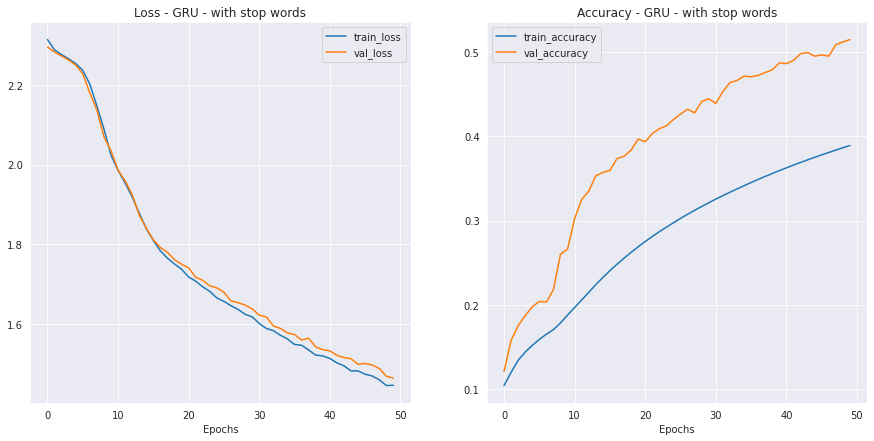

In [ ]:
# Plot curves
plot_loss_curves(results_gru_classifier, "GRU - with stop words")

The curves from our GRU model look nice. The loss functions keep on increasing without lot of oscilation. However, there is a gap in the loss curves visible from epoch 15 that however seems to remain small. The accuracy curves seem both seem to increase (again with the difference coming from the dropout in training), indicating that we even could train our model for more epochs. Let's evaluate the performance of our GRU model.

#### Evaluation

In [ ]:
# Evaluate gru_classifier
accuracy_gru, class_rep_gru, conf_mat_gru, Y_actual_gru, Y_preds_gru = make_predictions(gru_classifier, test_loader_with_stopwords, categories)

Test Accuracy : 0.479

Classification Report: 
                        precision    recall  f1-score   support

     Society & Culture       0.41      0.07      0.12       378
 Science & Mathematics       0.59      0.68      0.63       353
                Health       0.64      0.64      0.64       351
 Education & Reference       0.30      0.09      0.13       315
  Computers & Internet       0.70      0.80      0.75       370
                Sports       0.53      0.78      0.63       329
    Business & Finance       0.49      0.10      0.16       355
 Entertainment & Music       0.27      0.64      0.37       341
Family & Relationships       0.48      0.32      0.39       344
 Politics & Government       0.43      0.67      0.53       364

              accuracy                           0.48      3500
             macro avg       0.48      0.48      0.44      3500
          weighted avg       0.49      0.48      0.44      3500


Confusion Matrix: 
[[ 26   7  18  10  19  23  10 166 

Our model achieves an accuracy of 47.9% which is good. We observe that the f1-score for the category `Computers & Internet` is the highest, and for `Society & Culture` as well as `Education & Reference` to be among the lowest. Let's inspect the confusion matrix to get a better understanding of where our model classifies not correctly.

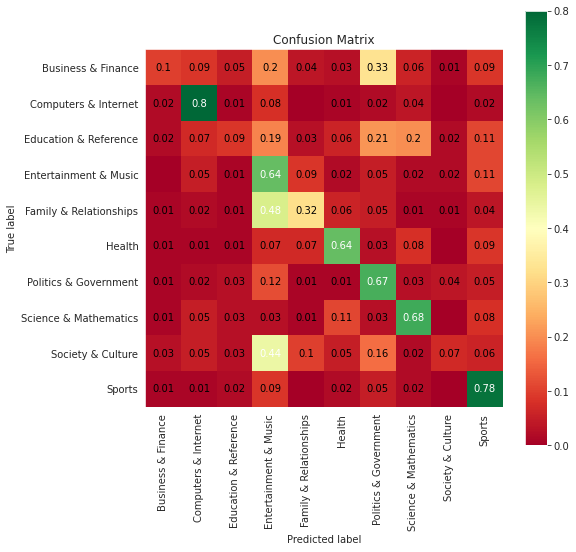

In [ ]:
# Plot gru with stop words
create_confusion_matrix(Y_actual_gru, Y_preds_gru, categories)

We see that a lot of posts that belong to `Society & Culture` (44%) were classified as `Entertainment & Music`. This is also the case for `Family & Relationship` (48%). For `Education & Reference` on the other hand, posts were mostly considered to belong to `Politics & Government`. This pattern is also the case for the posts from `Business & Finance`, where around 33% of the posts were wrongly classified to belong to `Politics & Government`. Overall, the GRU model seems to perform a bit worse than our second RNN with 3 RNN layers. 

Let's next exchange the GRU layer with an LSTM layer.

### LSTM

Compared to a normal RNN, [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) is a type of recurrent neural network that is capable of learning long-term dependencies in sequential data by using memory cells to store and access past information. We can create a LSTM layer by exchanging our `nn.RNN()`-layer with the `nn.LSTM()`-layer. Again, we will here only use a `hidden_dim` of 64 as with the GRU.

In [ ]:
# LSTM model
hidden_dim = 64
n_layers=1
embed_len = 100

class LSTMClassifier(nn.Module):
    def __init__(self, embeddings, n_layers):
        super(LSTMClassifier, self).__init__()

        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.n_layers = n_layers
        self.weights = torch.FloatTensor(embeddings)
        self.embedding_layer = nn.Embedding.from_pretrained(self.weights) # see: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        self.lstm = nn.LSTM(input_size=embed_len, hidden_size=hidden_dim, 
                            num_layers=self.n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 10)

        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.4)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        embeddings = self.dropout(embeddings)

        output, (hidden, cell) = self.lstm(embeddings, (torch.randn(self.n_layers, len(X_batch), hidden_dim),
                                                        torch.randn(self.n_layers, len(X_batch), hidden_dim)))
        
        output = self.activation(output)
        output = self.dropout(output)

        return self.linear(output[:,-1])
        

In [ ]:
epochs = 50
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_classifier = LSTMClassifier(word_embeddings_with_stopwords, n_layers=1)
#lstm_classifier = lstm_classifier.to(device)
lstm_classifier.embedding_layer.weight.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(lstm_classifier.parameters(), lr=learning_rate, weight_decay=1e-5)

results_lstm_classifier = train_model(lstm_classifier, loss_fn, optimizer, train_loader_with_stopwords, val_loader_with_stopwords, epochs)

EPOCH 1


100%|██████████| 59/59 [00:06<00:00,  9.00it/s]


Train Loss : 2.305
Train Acc  : 0.100
Valid Loss : 2.300
Valid Acc  : 0.103
EPOCH 2


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Train Loss : 2.297
Train Acc  : 0.104
Valid Loss : 2.293
Valid Acc  : 0.125
EPOCH 3


100%|██████████| 59/59 [00:05<00:00, 10.24it/s]


Train Loss : 2.288
Train Acc  : 0.112
Valid Loss : 2.286
Valid Acc  : 0.131
EPOCH 4


100%|██████████| 59/59 [00:05<00:00, 10.24it/s]


Train Loss : 2.278
Train Acc  : 0.118
Valid Loss : 2.275
Valid Acc  : 0.143
EPOCH 5


100%|██████████| 59/59 [00:05<00:00, 10.10it/s]


Train Loss : 2.260
Train Acc  : 0.127
Valid Loss : 2.244
Valid Acc  : 0.188
EPOCH 6


100%|██████████| 59/59 [00:05<00:00, 10.11it/s]


Train Loss : 2.200
Train Acc  : 0.139
Valid Loss : 2.178
Valid Acc  : 0.215
EPOCH 7


100%|██████████| 59/59 [00:05<00:00, 10.06it/s]


Train Loss : 2.145
Train Acc  : 0.152
Valid Loss : 2.132
Valid Acc  : 0.238
EPOCH 8


100%|██████████| 59/59 [00:05<00:00, 10.22it/s]


Train Loss : 2.099
Train Acc  : 0.165
Valid Loss : 2.088
Valid Acc  : 0.251
EPOCH 9


100%|██████████| 59/59 [00:05<00:00, 10.34it/s]


Train Loss : 2.063
Train Acc  : 0.176
Valid Loss : 2.055
Valid Acc  : 0.259
EPOCH 10


100%|██████████| 59/59 [00:05<00:00, 10.37it/s]


Train Loss : 2.030
Train Acc  : 0.187
Valid Loss : 2.026
Valid Acc  : 0.287
EPOCH 11


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Train Loss : 1.995
Train Acc  : 0.198
Valid Loss : 1.998
Valid Acc  : 0.296
EPOCH 12


100%|██████████| 59/59 [00:09<00:00,  6.37it/s]


Train Loss : 1.968
Train Acc  : 0.208
Valid Loss : 1.970
Valid Acc  : 0.310
EPOCH 13


100%|██████████| 59/59 [00:05<00:00, 10.27it/s]


Train Loss : 1.943
Train Acc  : 0.217
Valid Loss : 1.945
Valid Acc  : 0.320
EPOCH 14


100%|██████████| 59/59 [00:06<00:00,  8.92it/s]


Train Loss : 1.921
Train Acc  : 0.226
Valid Loss : 1.933
Valid Acc  : 0.329
EPOCH 15


100%|██████████| 59/59 [00:05<00:00, 10.22it/s]


Train Loss : 1.894
Train Acc  : 0.234
Valid Loss : 1.912
Valid Acc  : 0.341
EPOCH 16


100%|██████████| 59/59 [00:05<00:00, 10.04it/s]


Train Loss : 1.870
Train Acc  : 0.243
Valid Loss : 1.874
Valid Acc  : 0.359
EPOCH 17


100%|██████████| 59/59 [00:05<00:00, 10.13it/s]


Train Loss : 1.843
Train Acc  : 0.250
Valid Loss : 1.853
Valid Acc  : 0.371
EPOCH 18


100%|██████████| 59/59 [00:05<00:00, 10.26it/s]


Train Loss : 1.810
Train Acc  : 0.259
Valid Loss : 1.810
Valid Acc  : 0.392
EPOCH 19


100%|██████████| 59/59 [00:05<00:00, 10.12it/s]


Train Loss : 1.778
Train Acc  : 0.267
Valid Loss : 1.789
Valid Acc  : 0.413
EPOCH 20


100%|██████████| 59/59 [00:05<00:00, 10.21it/s]


Train Loss : 1.747
Train Acc  : 0.275
Valid Loss : 1.760
Valid Acc  : 0.423
EPOCH 21


100%|██████████| 59/59 [00:05<00:00, 10.32it/s]


Train Loss : 1.709
Train Acc  : 0.283
Valid Loss : 1.706
Valid Acc  : 0.461
EPOCH 22


100%|██████████| 59/59 [00:05<00:00, 10.35it/s]


Train Loss : 1.661
Train Acc  : 0.292
Valid Loss : 1.670
Valid Acc  : 0.473
EPOCH 23


100%|██████████| 59/59 [00:05<00:00, 10.40it/s]


Train Loss : 1.642
Train Acc  : 0.300
Valid Loss : 1.649
Valid Acc  : 0.481
EPOCH 24


100%|██████████| 59/59 [00:05<00:00, 10.38it/s]


Train Loss : 1.615
Train Acc  : 0.308
Valid Loss : 1.609
Valid Acc  : 0.499
EPOCH 25


100%|██████████| 59/59 [00:05<00:00, 10.20it/s]


Train Loss : 1.587
Train Acc  : 0.316
Valid Loss : 1.598
Valid Acc  : 0.496
EPOCH 26


100%|██████████| 59/59 [00:05<00:00, 10.31it/s]


Train Loss : 1.575
Train Acc  : 0.323
Valid Loss : 1.586
Valid Acc  : 0.498
EPOCH 27


100%|██████████| 59/59 [00:06<00:00,  8.91it/s]


Train Loss : 1.550
Train Acc  : 0.330
Valid Loss : 1.575
Valid Acc  : 0.507
EPOCH 28


100%|██████████| 59/59 [00:11<00:00,  5.18it/s]


Train Loss : 1.537
Train Acc  : 0.337
Valid Loss : 1.559
Valid Acc  : 0.507
EPOCH 29


100%|██████████| 59/59 [00:05<00:00,  9.94it/s]


Train Loss : 1.520
Train Acc  : 0.343
Valid Loss : 1.532
Valid Acc  : 0.521
EPOCH 30


100%|██████████| 59/59 [00:06<00:00,  8.77it/s]


Train Loss : 1.499
Train Acc  : 0.349
Valid Loss : 1.509
Valid Acc  : 0.527
EPOCH 31


100%|██████████| 59/59 [00:05<00:00, 10.20it/s]


Train Loss : 1.486
Train Acc  : 0.355
Valid Loss : 1.487
Valid Acc  : 0.538
EPOCH 32


100%|██████████| 59/59 [00:05<00:00, 10.24it/s]


Train Loss : 1.478
Train Acc  : 0.361
Valid Loss : 1.495
Valid Acc  : 0.534
EPOCH 33


100%|██████████| 59/59 [00:05<00:00, 10.20it/s]


Train Loss : 1.460
Train Acc  : 0.366
Valid Loss : 1.480
Valid Acc  : 0.536
EPOCH 34


100%|██████████| 59/59 [00:05<00:00, 10.17it/s]


Train Loss : 1.446
Train Acc  : 0.371
Valid Loss : 1.463
Valid Acc  : 0.535
EPOCH 35


100%|██████████| 59/59 [00:05<00:00, 10.09it/s]


Train Loss : 1.439
Train Acc  : 0.376
Valid Loss : 1.452
Valid Acc  : 0.535
EPOCH 36


100%|██████████| 59/59 [00:05<00:00, 10.22it/s]


Train Loss : 1.430
Train Acc  : 0.381
Valid Loss : 1.439
Valid Acc  : 0.548
EPOCH 37


100%|██████████| 59/59 [00:05<00:00, 10.17it/s]


Train Loss : 1.420
Train Acc  : 0.385
Valid Loss : 1.432
Valid Acc  : 0.548
EPOCH 38


100%|██████████| 59/59 [00:05<00:00, 10.31it/s]


Train Loss : 1.409
Train Acc  : 0.390
Valid Loss : 1.419
Valid Acc  : 0.547
EPOCH 39


100%|██████████| 59/59 [00:07<00:00,  7.66it/s]


Train Loss : 1.397
Train Acc  : 0.394
Valid Loss : 1.406
Valid Acc  : 0.551
EPOCH 40


100%|██████████| 59/59 [00:08<00:00,  6.85it/s]


Train Loss : 1.385
Train Acc  : 0.398
Valid Loss : 1.406
Valid Acc  : 0.555
EPOCH 41


100%|██████████| 59/59 [00:05<00:00, 10.16it/s]


Train Loss : 1.377
Train Acc  : 0.402
Valid Loss : 1.413
Valid Acc  : 0.553
EPOCH 42


100%|██████████| 59/59 [00:05<00:00, 10.14it/s]


Train Loss : 1.369
Train Acc  : 0.406
Valid Loss : 1.394
Valid Acc  : 0.556
EPOCH 43


100%|██████████| 59/59 [00:05<00:00, 10.18it/s]


Train Loss : 1.362
Train Acc  : 0.410
Valid Loss : 1.391
Valid Acc  : 0.557
EPOCH 44


100%|██████████| 59/59 [00:05<00:00, 10.13it/s]


Train Loss : 1.358
Train Acc  : 0.414
Valid Loss : 1.372
Valid Acc  : 0.561
EPOCH 45


100%|██████████| 59/59 [00:05<00:00, 10.28it/s]


Train Loss : 1.350
Train Acc  : 0.417
Valid Loss : 1.374
Valid Acc  : 0.561
EPOCH 46


100%|██████████| 59/59 [00:05<00:00, 10.19it/s]


Train Loss : 1.345
Train Acc  : 0.421
Valid Loss : 1.377
Valid Acc  : 0.565
EPOCH 47


100%|██████████| 59/59 [00:05<00:00, 10.30it/s]


Train Loss : 1.336
Train Acc  : 0.424
Valid Loss : 1.372
Valid Acc  : 0.564
EPOCH 48


100%|██████████| 59/59 [00:05<00:00, 10.14it/s]


Train Loss : 1.331
Train Acc  : 0.427
Valid Loss : 1.364
Valid Acc  : 0.566
EPOCH 49


100%|██████████| 59/59 [00:05<00:00, 10.27it/s]


Train Loss : 1.325
Train Acc  : 0.430
Valid Loss : 1.365
Valid Acc  : 0.563
EPOCH 50


100%|██████████| 59/59 [00:05<00:00, 10.37it/s]


Train Loss : 1.318
Train Acc  : 0.433
Valid Loss : 1.345
Valid Acc  : 0.572


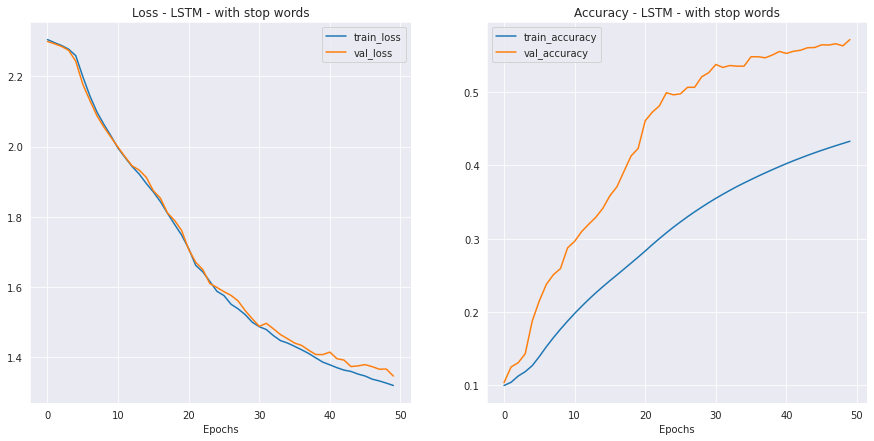

In [ ]:
# Plot curves
plot_loss_curves(results_lstm_classifier, "LSTM - with stop words")

The loss curves for our LSTM look very good. Both curves are close together and keep decreasing. However, there is still a small gap visible in the loss curves towards the end. The accuracy curves on the other hand keep on increasing with few oscillations in the validation accuracy curve. The curve seems furthermore to flatten a little, but since it seems to still increase a bit, we even might train for a few more epochs.

Let's next evaluate the performance of our LSTM on our test data.

#### Evaluation

In [ ]:
# Evaluate gru_classifier
accuracy_lstm, class_rep_lstm, conf_mat_lstm, Y_actual_lstm, Y_preds_lstm = make_predictions(lstm_classifier, test_loader_with_stopwords, categories)

Test Accuracy : 0.530

Classification Report: 
                        precision    recall  f1-score   support

     Society & Culture       0.61      0.33      0.43       378
 Science & Mathematics       0.60      0.69      0.65       353
                Health       0.56      0.70      0.63       351
 Education & Reference       0.23      0.11      0.15       315
  Computers & Internet       0.71      0.80      0.75       370
                Sports       0.58      0.83      0.68       329
    Business & Finance       0.44      0.35      0.39       355
 Entertainment & Music       0.31      0.56      0.40       341
Family & Relationships       0.54      0.38      0.45       344
 Politics & Government       0.69      0.51      0.59       364

              accuracy                           0.53      3500
             macro avg       0.53      0.53      0.51      3500
          weighted avg       0.53      0.53      0.52      3500


Confusion Matrix: 
[[126  22  28  16  14  16  16  85 

Our LSTM model achieves an accuracy of 53% which is the highest score we got so far. We observe again that the f1-score for the category `Computers & Internet` is the highest. On the other hand, we get the lowest f1-score for `Education & Reference`. Let's inspect the confusion matrix to get a better understanding of where our model classifies not correctly.

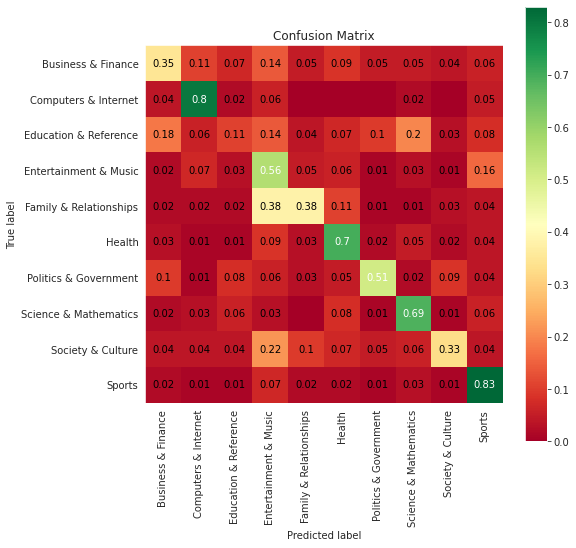

In [ ]:
# Plot LSTM with stop words
create_confusion_matrix(Y_actual_lstm, Y_preds_lstm, categories)

We see that around 18% of posts that belong to `Education & Reference` were classified as `Business & Finance`. On the other hand around 38% of posts of `Family & Relationship` were wrongly classified as `Entertainment & Music`. Overall, posts of the category `Sports` with 83% and `Computers & Internet` with 80% achieved the best results.

Conclusively, the LSTM model seems to perform better than the GRU model. Therefore, let's create another LSTM model, but this time again with 2 LSTM layers. 

### LSTM - with 2 hidden layers

In [ ]:
epochs = 50
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_classifier_2 = LSTMClassifier(word_embeddings_with_stopwords, n_layers=2)
#lstm_classifier = lstm_classifier.to(device)
lstm_classifier_2.embedding_layer.weight.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(lstm_classifier_2.parameters(), lr=learning_rate, weight_decay=1e-5)

results_lstm_classifier_2 = train_model(lstm_classifier_2, loss_fn, optimizer, train_loader_with_stopwords, val_loader_with_stopwords, epochs)

EPOCH 1


100%|██████████| 59/59 [00:11<00:00,  5.22it/s]


Train Loss : 2.302
Train Acc  : 0.106
Valid Loss : 2.300
Valid Acc  : 0.131
EPOCH 2


100%|██████████| 59/59 [00:11<00:00,  5.02it/s]


Train Loss : 2.295
Train Acc  : 0.112
Valid Loss : 2.292
Valid Acc  : 0.119
EPOCH 3


100%|██████████| 59/59 [00:10<00:00,  5.58it/s]


Train Loss : 2.279
Train Acc  : 0.117
Valid Loss : 2.262
Valid Acc  : 0.158
EPOCH 4


100%|██████████| 59/59 [00:10<00:00,  5.63it/s]


Train Loss : 2.218
Train Acc  : 0.133
Valid Loss : 2.186
Valid Acc  : 0.179
EPOCH 5


100%|██████████| 59/59 [00:10<00:00,  5.63it/s]


Train Loss : 2.141
Train Acc  : 0.150
Valid Loss : 2.113
Valid Acc  : 0.231
EPOCH 6


100%|██████████| 59/59 [00:10<00:00,  5.55it/s]


Train Loss : 2.066
Train Acc  : 0.170
Valid Loss : 2.048
Valid Acc  : 0.277
EPOCH 7


100%|██████████| 59/59 [00:10<00:00,  5.60it/s]


Train Loss : 2.010
Train Acc  : 0.187
Valid Loss : 2.024
Valid Acc  : 0.290
EPOCH 8


100%|██████████| 59/59 [00:10<00:00,  5.63it/s]


Train Loss : 1.971
Train Acc  : 0.203
Valid Loss : 1.972
Valid Acc  : 0.308
EPOCH 9


100%|██████████| 59/59 [00:10<00:00,  5.59it/s]


Train Loss : 1.943
Train Acc  : 0.216
Valid Loss : 1.937
Valid Acc  : 0.327
EPOCH 10


100%|██████████| 59/59 [00:10<00:00,  5.56it/s]


Train Loss : 1.902
Train Acc  : 0.228
Valid Loss : 1.882
Valid Acc  : 0.358
EPOCH 11


100%|██████████| 59/59 [00:10<00:00,  5.65it/s]


Train Loss : 1.828
Train Acc  : 0.242
Valid Loss : 1.799
Valid Acc  : 0.400
EPOCH 12


100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss : 1.766
Train Acc  : 0.255
Valid Loss : 1.772
Valid Acc  : 0.403
EPOCH 13


100%|██████████| 59/59 [00:14<00:00,  4.14it/s]


Train Loss : 1.737
Train Acc  : 0.268
Valid Loss : 1.751
Valid Acc  : 0.405
EPOCH 14


100%|██████████| 59/59 [00:10<00:00,  5.56it/s]


Train Loss : 1.734
Train Acc  : 0.279
Valid Loss : 1.721
Valid Acc  : 0.412
EPOCH 15


100%|██████████| 59/59 [00:10<00:00,  5.64it/s]


Train Loss : 1.684
Train Acc  : 0.289
Valid Loss : 1.700
Valid Acc  : 0.428
EPOCH 16


100%|██████████| 59/59 [00:10<00:00,  5.57it/s]


Train Loss : 1.663
Train Acc  : 0.299
Valid Loss : 1.663
Valid Acc  : 0.443
EPOCH 17


100%|██████████| 59/59 [00:11<00:00,  4.97it/s]


Train Loss : 1.646
Train Acc  : 0.308
Valid Loss : 1.665
Valid Acc  : 0.437
EPOCH 18


100%|██████████| 59/59 [00:10<00:00,  5.48it/s]


Train Loss : 1.635
Train Acc  : 0.316
Valid Loss : 1.664
Valid Acc  : 0.445
EPOCH 19


100%|██████████| 59/59 [00:10<00:00,  5.57it/s]


Train Loss : 1.614
Train Acc  : 0.324
Valid Loss : 1.625
Valid Acc  : 0.455
EPOCH 20


100%|██████████| 59/59 [00:10<00:00,  5.61it/s]


Train Loss : 1.594
Train Acc  : 0.331
Valid Loss : 1.605
Valid Acc  : 0.458
EPOCH 21


100%|██████████| 59/59 [00:10<00:00,  5.61it/s]


Train Loss : 1.577
Train Acc  : 0.338
Valid Loss : 1.592
Valid Acc  : 0.467
EPOCH 22


100%|██████████| 59/59 [00:10<00:00,  5.61it/s]


Train Loss : 1.568
Train Acc  : 0.344
Valid Loss : 1.582
Valid Acc  : 0.467
EPOCH 23


100%|██████████| 59/59 [00:14<00:00,  4.04it/s]


Train Loss : 1.555
Train Acc  : 0.350
Valid Loss : 1.574
Valid Acc  : 0.473
EPOCH 24


100%|██████████| 59/59 [00:10<00:00,  5.48it/s]


Train Loss : 1.540
Train Acc  : 0.356
Valid Loss : 1.556
Valid Acc  : 0.483
EPOCH 25


100%|██████████| 59/59 [00:11<00:00,  5.02it/s]


Train Loss : 1.526
Train Acc  : 0.361
Valid Loss : 1.541
Valid Acc  : 0.486
EPOCH 26


100%|██████████| 59/59 [00:10<00:00,  5.50it/s]


Train Loss : 1.510
Train Acc  : 0.367
Valid Loss : 1.534
Valid Acc  : 0.483
EPOCH 27


100%|██████████| 59/59 [00:10<00:00,  5.44it/s]


Train Loss : 1.500
Train Acc  : 0.372
Valid Loss : 1.517
Valid Acc  : 0.492
EPOCH 28


100%|██████████| 59/59 [00:10<00:00,  5.47it/s]


Train Loss : 1.487
Train Acc  : 0.377
Valid Loss : 1.522
Valid Acc  : 0.497
EPOCH 29


100%|██████████| 59/59 [00:11<00:00,  5.05it/s]


Train Loss : 1.480
Train Acc  : 0.381
Valid Loss : 1.498
Valid Acc  : 0.504
EPOCH 30


100%|██████████| 59/59 [00:13<00:00,  4.30it/s]


Train Loss : 1.466
Train Acc  : 0.386
Valid Loss : 1.487
Valid Acc  : 0.508
EPOCH 31


100%|██████████| 59/59 [00:10<00:00,  5.50it/s]


Train Loss : 1.464
Train Acc  : 0.390
Valid Loss : 1.480
Valid Acc  : 0.510
EPOCH 32


100%|██████████| 59/59 [00:11<00:00,  4.99it/s]


Train Loss : 1.454
Train Acc  : 0.394
Valid Loss : 1.474
Valid Acc  : 0.509
EPOCH 33


100%|██████████| 59/59 [00:10<00:00,  5.54it/s]


Train Loss : 1.441
Train Acc  : 0.398
Valid Loss : 1.471
Valid Acc  : 0.517
EPOCH 34


100%|██████████| 59/59 [00:10<00:00,  5.58it/s]


Train Loss : 1.429
Train Acc  : 0.402
Valid Loss : 1.448
Valid Acc  : 0.527
EPOCH 35


100%|██████████| 59/59 [00:10<00:00,  5.46it/s]


Train Loss : 1.415
Train Acc  : 0.406
Valid Loss : 1.445
Valid Acc  : 0.529
EPOCH 36


100%|██████████| 59/59 [00:10<00:00,  5.47it/s]


Train Loss : 1.409
Train Acc  : 0.410
Valid Loss : 1.447
Valid Acc  : 0.529
EPOCH 37


100%|██████████| 59/59 [00:10<00:00,  5.50it/s]


Train Loss : 1.403
Train Acc  : 0.413
Valid Loss : 1.425
Valid Acc  : 0.532
EPOCH 38


100%|██████████| 59/59 [00:10<00:00,  5.48it/s]


Train Loss : 1.396
Train Acc  : 0.417
Valid Loss : 1.429
Valid Acc  : 0.533
EPOCH 39


100%|██████████| 59/59 [00:10<00:00,  5.53it/s]


Train Loss : 1.391
Train Acc  : 0.420
Valid Loss : 1.411
Valid Acc  : 0.537
EPOCH 40


100%|██████████| 59/59 [00:10<00:00,  5.53it/s]


Train Loss : 1.385
Train Acc  : 0.424
Valid Loss : 1.399
Valid Acc  : 0.547
EPOCH 41


100%|██████████| 59/59 [00:10<00:00,  5.49it/s]


Train Loss : 1.368
Train Acc  : 0.427
Valid Loss : 1.392
Valid Acc  : 0.547
EPOCH 42


100%|██████████| 59/59 [00:10<00:00,  5.45it/s]


Train Loss : 1.366
Train Acc  : 0.430
Valid Loss : 1.388
Valid Acc  : 0.545
EPOCH 43


100%|██████████| 59/59 [00:17<00:00,  3.46it/s]


Train Loss : 1.357
Train Acc  : 0.433
Valid Loss : 1.381
Valid Acc  : 0.551
EPOCH 44


100%|██████████| 59/59 [00:10<00:00,  5.46it/s]


Train Loss : 1.354
Train Acc  : 0.436
Valid Loss : 1.405
Valid Acc  : 0.542
EPOCH 45


100%|██████████| 59/59 [00:10<00:00,  5.43it/s]


Train Loss : 1.350
Train Acc  : 0.439
Valid Loss : 1.374
Valid Acc  : 0.551
EPOCH 46


100%|██████████| 59/59 [00:16<00:00,  3.61it/s]


Train Loss : 1.340
Train Acc  : 0.442
Valid Loss : 1.370
Valid Acc  : 0.555
EPOCH 47


100%|██████████| 59/59 [00:10<00:00,  5.47it/s]


Train Loss : 1.334
Train Acc  : 0.444
Valid Loss : 1.378
Valid Acc  : 0.552
EPOCH 48


100%|██████████| 59/59 [00:16<00:00,  3.63it/s]


Train Loss : 1.329
Train Acc  : 0.447
Valid Loss : 1.353
Valid Acc  : 0.560
EPOCH 49


100%|██████████| 59/59 [00:12<00:00,  4.62it/s]


Train Loss : 1.317
Train Acc  : 0.450
Valid Loss : 1.355
Valid Acc  : 0.557
EPOCH 50


100%|██████████| 59/59 [00:13<00:00,  4.45it/s]


Train Loss : 1.320
Train Acc  : 0.452
Valid Loss : 1.364
Valid Acc  : 0.559


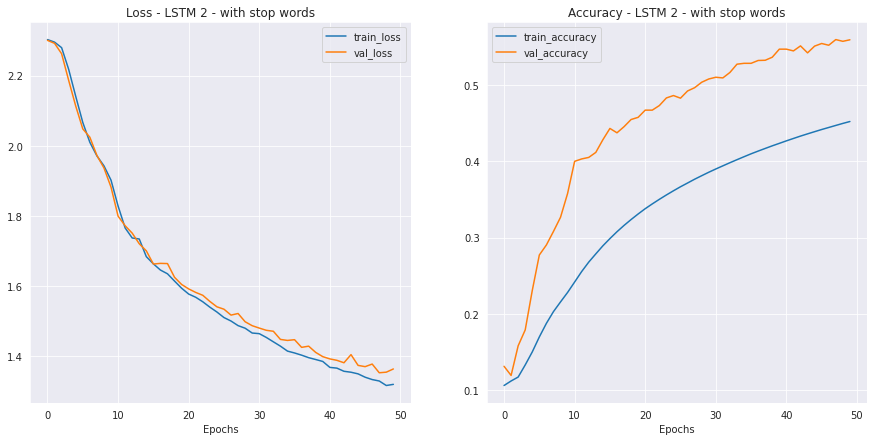

In [ ]:
# Plot curves
plot_loss_curves(results_lstm_classifier_2, "LSTM 2 - with stop words")

The loss curves for our LSTM look again very good. Both curves are close together and keep decreasing. However, the gap in the loss curves starts to become visible earlier compared to our first LSTM model. The accuracy curves on the other hand keep on increasing again with few oscillations in the validation accuracy curve. Again, as the loss curves might seem to still decrease and the accuracy curves to increase, we could try to train for a couple more epochs.

Let's see how the second LSTM model performs on the test data.

#### Evaluation

In [ ]:
# Evaluate lstm_classifier_2
accuracy_lstm_2, class_rep_lstm_2, conf_mat_lstm_2, Y_actual_lstm_2, Y_preds_lstm_2 = make_predictions(lstm_classifier_2, test_loader_with_stopwords, categories)

Test Accuracy : 0.531

Classification Report: 
                        precision    recall  f1-score   support

     Society & Culture       0.37      0.34      0.36       378
 Science & Mathematics       0.59      0.71      0.64       353
                Health       0.64      0.65      0.64       351
 Education & Reference       0.23      0.23      0.23       315
  Computers & Internet       0.75      0.79      0.77       370
                Sports       0.64      0.78      0.71       329
    Business & Finance       0.51      0.27      0.35       355
 Entertainment & Music       0.39      0.57      0.46       341
Family & Relationships       0.54      0.41      0.47       344
 Politics & Government       0.61      0.55      0.58       364

              accuracy                           0.53      3500
             macro avg       0.53      0.53      0.52      3500
          weighted avg       0.53      0.53      0.52      3500


Confusion Matrix: 
[[128  19  22  31   9   8  16  63 

Our second LSTM model achieves an accuracy of 53.1% which is 0.01% more than our first LSTM model. We observe again that the f1-score for the category `Computers & Internet` is the highest. On the other hand, we also get the lowest f1-score for `Education & Reference` again, but this time at 0.23 instead of 0.15 as in our first LSTM model. Let's inspect the confusion matrix to get a better understanding of the classifications.

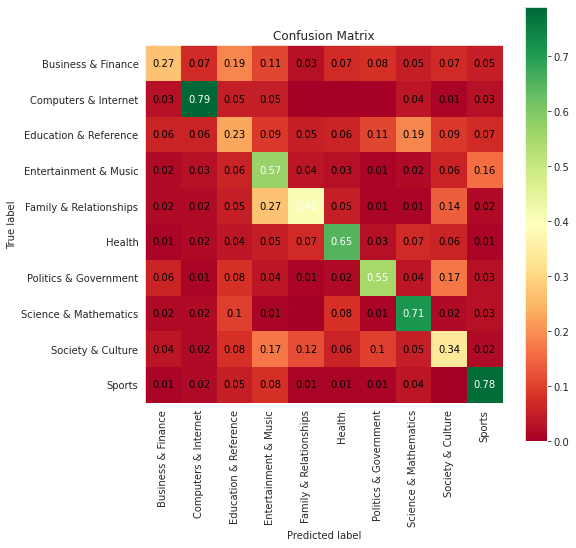

In [ ]:
# Plot LSTM with stop words
create_confusion_matrix(Y_actual_lstm_2, Y_preds_lstm_2, categories)

Overall, the scores for `Computers & Internet` (from 80% to 79%) and `Sports` (from 83% to 78%) seem to be lower than in our first LSTM model.

We see that only 6% of the posts that belong to `Education & Reference` were now classified as `Business & Finance` (18% in the first LSTM model). However, 19% of the category were classified as `Science & Mathematics`. Furthermore, around 27% of posts of `Family & Relationship` were again wrongly classified as `Entertainment & Music`.

Conclusively, our second LSTM model seems to perform a marginal bit better than our first LSTM model. It performs a bit worse on our best classes so far, but performs better on the worst classes. 

### Transfer Learning

As the last step, let us try to use a transfer learning method. Transfer learning is a way to use a pre-trained model on a related task. We can do this with the help of the `transformers` package from [Hugging Face](https://huggingface.co/docs/transformers/training). The model that we will use is [BERT](https://en.wikipedia.org/wiki/BERT_(language_model) (Bidirectional Encoder Representations from Transformers). BERT is a natural language processing model that uses pre-trained transformer architectures to process and understand human language in context. For this, we will start with our initial loaded data set and follow closely the [Hugging Face documentation](https://huggingface.co/docs/transformers/training). Let's start by getting our train and test data again.

In [ ]:
# Get the data again as datasets.arrow_dataset.Dataset
yahoo_answers_train = yahoo_answers['train'].shuffle(seed=42).select(range(15000)) # no validation set as we only evaluate on the test set later
yahoo_answers_test = yahoo_answers['test'].shuffle(seed=42).select(range(3500))

Next, we can load the pre-trained tokenizer, create a function that tokenizes our relevant columns and apply it to the data set.

In [ ]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [ ]:
# Create tokenize function
def tokenize_function(post):
  """
  Tokenizes post in dataset.
  """
  return tokenizer(post['question_title'], post['question_content'], post['best_answer'],
                   padding="max_length", truncation=True)

In [ ]:
# Tokenize datasets
tokenized_train = yahoo_answers_train.map(tokenize_function, batched=True)
tokenized_test = yahoo_answers_test.map(tokenize_function, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
# Show sample
tokenized_train[1]

{'id': 251470,
 'topic': 9,
 'question_title': 'Why Do So Many People Have a High Opinion of Ex-President Adulterer Bill Clinton?',
 'question_content': 'Bill Clinton was an adulterer. He undermined our copyright laws until 2019.',
 'best_answer': "The economy was up, our soldiers weren't out there creating terrorists, other countries respected us, and our freedoms were intact. I don't give a tinker's damn if he got some action off the clock.",
 'input_ids': [101,
  2009,
  2091,
  1573,
  2408,
  2563,
  4373,
  170,
  1693,
  9126,
  4729,
  1320,
  1104,
  16409,
  118,
  1697,
  11635,
  22113,
  2617,
  6652,
  136,
  102,
  2617,
  6652,
  1108,
  1126,
  4457,
  22113,
  119,
  1124,
  1223,
  15842,
  1412,
  11409,
  3892,
  1235,
  10351,
  119,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

From the sample, we see that the tokenization worked. Before we can continue, we have to remove the columns that we don't need anymore and rename our `topic` column to `labels` as this variable name is expected in the model.

In [ ]:
# Remove not needed columns
tokenized_train = tokenized_train.remove_columns(['id', 'question_title', 'question_content', 'best_answer', 'labels'])
tokenized_test = tokenized_test.remove_columns(['id', 'question_title', 'question_content', 'best_answer', 'labels'])

In [ ]:
# Rename topic column to labels as this is expected in model
tokenized_train = tokenized_train.rename_column('topic', 'labels')
tokenized_test = tokenized_test.rename_column('topic', 'labels')

Now that we have cleaned our data, we can set the torch format and create the dataloaders.

In [ ]:
# Set torch format
tokenized_train.set_format("torch")
tokenized_test.set_format("torch")

In [ ]:
# Create data collator
data_collator = DataCollatorWithPadding(tokenizer)

In [ ]:
# Create data loader
train_dataloader = DataLoader(
    tokenized_train, shuffle=True, batch_size=8, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_test, batch_size=8, collate_fn=data_collator
)

In [ ]:
# Inspect the data
for batch in train_dataloader:
  break
pprint({k: v.shape for k, v in batch.items()})

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'attention_mask': torch.Size([8, 512]),
 'input_ids': torch.Size([8, 512]),
 'labels': torch.Size([8]),
 'token_type_ids': torch.Size([8, 512])}


Our data is now ready for modeling. We see that we also have an `attention_mask`. This is used in BERT to specify which elements of the input should be ignored (masked out) when performing attention. Now let's create the BERT model. We can do this by using `AutoModelForSequenceClassification.from_pretrained()` where we can then specify which model we want to load and how many labels we have to classify in our data.

In [ ]:
# Create model
bert = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=10)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Next, we create the optimizer for our model and specify the learning rate. Additionally, to this, we will define a learning rate scheduler. The learning rate scheduler helps us to adjust the learning rate during training. This is done by reducing the learning rate at appropriate times during training. Afterward, we will move our BERT model to GPU and are ready for training.

In [ ]:
# Create optimizer
learning_rate = 1e-4

optimizer = Adam(bert.parameters(), lr=learning_rate)

In [ ]:
# Create learning rate scheduler
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
# Move model to GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
bert.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Let's now define the training loop and train our model. 

In [ ]:
# Training Loop
progress_bar = tqdm(range(num_training_steps))

bert.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = bert(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

100%|██████████| 3750/3750 [48:28<00:00,  1.30it/s]

#### Evaluation

We now have trained our BERT model for only 2 epochs, which already took a while. Let's see how it performs.

In [ ]:
# Evaluate model
metric_list = ["accuracy", "precision", "recall", "f1"]
bert_metrics = [] 

for m in metric_list:
  if m in ["precision", "recall", "f1"]:
    metric = evaluate.load(m, average="weighted")
  else:
    metric = evaluate.load(m)
  bert.eval()
  for batch in test_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = bert(**batch)

      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])

  if m in ["precision", "recall", "f1"]:
    bert_metrics.append(metric.compute(average="weighted"))
  else:
   bert_metrics.append(metric.compute())

bert_metrics

[{'accuracy': 0.6931428571428572},
 {'precision': 0.6908907194645119},
 {'recall': 0.6931428571428572},
 {'f1': 0.6906405017721794}]

This is great! With only two epochs we get 69% accuracy on the test data set. Additionally, precision, recall and the f1-score are all aroung 69%. This is definitely better than our best model so far. Let's next create and inspect the confusion matrix for our BERT model.

In [ ]:
# Confusion matrix
predictions_list = []
references_list = []

bert.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = bert(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    predictions_list.extend(predictions.tolist())
    references_list.extend(batch["labels"].tolist())


confusion_matrix = confusion_matrix(references_list, predictions_list)
print(confusion_matrix)

[[213  11  11  33   9   4   8  18  51  20]
 [ 10 269  23  22   5   6   9   4   1   4]
 [ 13  17 266   9   4   4   9   7  21   1]
 [ 28  50  14 152   8   9  16  11  11  16]
 [  3   7   0   8 315   1  23  10   3   0]
 [  3   7   2   8   5 264   9  20   3   8]
 [ 30  20  20  25  23   9 180  13  18  17]
 [ 26   9   4  14  12  17  10 225  22   2]
 [ 22   2  20   5   4   4   8  11 261   7]
 [ 29   6   2  11   2   5  20   3   5 281]]


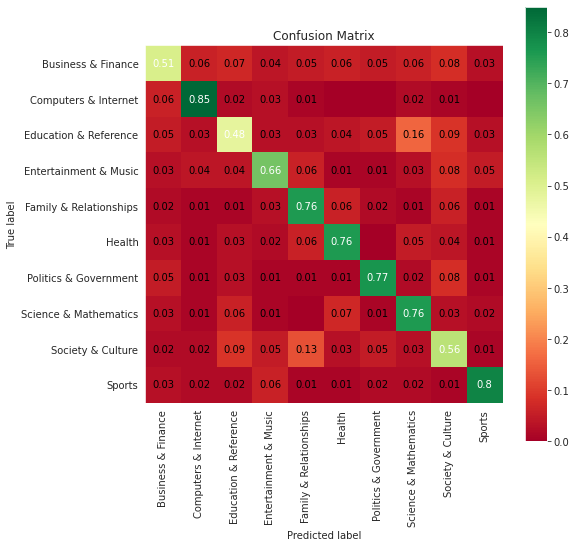

In [ ]:
# Create confusion matrix
create_confusion_matrix(references_list, predictions_list, categories)

Our BERT model achieved better scores for every class compared to our other models. As already seen in previous models, our BERT model also has the highest scores for `Sports` and `Computers & Internet`. On the other hand, all categories achieved a score of more than 50%, but `Education & Reference`. Here, as already in our second LSTM model, most posts of the category get classified as `Science & Mathematics`(this time 16% compared to the second LSTM with 18%). Given our best performing models, we can therefore conclude that `Business & Finance` as well as `Education & Reference` are the hardest categories to predict correctly, whereas our models all perform the best on posts from the categories `Sports` and `Computer & Internet`.

Now that we have created all our models, let's wrap their performance up in the next section.

## Evaluation of our different models

We've come a far way. Let's summarize the key metrics of our models in a dataframe in order to compare them a last time.

In [ ]:
# Create dataframes for metrics of models
metrics = pd.DataFrame([
    {'Model':'RNN without stop words', 'Accuracy': accuracy_rnn,
     'Precision': class_rep_rnn['macro avg']['precision'],
     'Recall': class_rep_rnn['macro avg']['recall'],
     'F1': class_rep_rnn['macro avg']['f1-score'],
     'Epochs': 50,
     'Parameters': sum(p.numel() for p in rnn_classifier.parameters())},
     {'Model':'RNN with stop words', 'Accuracy': accuracy_rnn_stopwords,
     'Precision': class_rep_rnn_stopwords['macro avg']['precision'],
     'Recall': class_rep_rnn_stopwords['macro avg']['recall'],
     'F1': class_rep_rnn_stopwords['macro avg']['f1-score'],
     'Epochs': 50,
     'Parameters': sum(p.numel() for p in rnn_classifier_stopwords.parameters())},
     {'Model':'RNN 2 without stop words - 3 layer RNN', 'Accuracy': accuracy_rnn_2,
     'Precision': class_rep_rnn_2['macro avg']['precision'],
     'Recall': class_rep_rnn_2['macro avg']['recall'],
     'F1': class_rep_rnn_2['macro avg']['f1-score'],
     'Epochs': 50,
     'Parameters': sum(p.numel() for p in rnn_classifier_2.parameters())},
     {'Model':'RNN 2 with stop words - 3 layer RNN', 'Accuracy': accuracy_rnn_stopwords_2,
     'Precision': class_rep_rnn_stopwords_2['macro avg']['precision'],
     'Recall': class_rep_rnn_stopwords_2['macro avg']['recall'],
     'F1': class_rep_rnn_stopwords_2['macro avg']['f1-score'],
     'Epochs': 50,
     'Parameters': sum(p.numel() for p in rnn_classifier_stopwords_2.parameters())},
     {'Model':'GRU', 'Accuracy': accuracy_gru,
     'Precision': class_rep_gru['macro avg']['precision'],
     'Recall': class_rep_gru['macro avg']['recall'],
     'F1': class_rep_gru['macro avg']['f1-score'],
     'Epochs': 50,
     'Parameters': sum(p.numel() for p in gru_classifier.parameters())},
     {'Model':'LSTM', 'Accuracy': accuracy_lstm,
     'Precision': class_rep_lstm['macro avg']['precision'],
     'Recall': class_rep_lstm['macro avg']['recall'],
     'F1': class_rep_lstm['macro avg']['f1-score'],
     'Epochs': 50,
     'Parameters': sum(p.numel() for p in lstm_classifier.parameters())},
     {'Model':'LSTM 2 - 2 layer LSTM', 'Accuracy': accuracy_lstm_2,
     'Precision': class_rep_lstm_2['macro avg']['precision'],
     'Recall': class_rep_lstm_2['macro avg']['recall'],
     'F1': class_rep_lstm_2['macro avg']['f1-score'],
     'Epochs': 50,
     'Parameters': sum(p.numel() for p in lstm_classifier_2.parameters())},
     {'Model':'BERT', 'Accuracy': bert_metrics[0]['accuracy'],
      'Precision': bert_metrics[1]['precision'],
      'Recall': bert_metrics[2]['recall'],
      'F1':bert_metrics[3]['f1'],
      'Epochs': 2,
      'Parameters': sum(p.numel() for p in bert.parameters())}
     ])

In [ ]:
# Round numbers and display dataframe
metrics[['Accuracy', 'Precision', 'Recall', 'F1']] = metrics[['Accuracy', 'Precision', 'Recall', 'F1']].round(3)
metrics

Model  Accuracy  Precision  Recall     F1  \
0                  RNN without stop words     0.462      0.437   0.459  0.418   
1                     RNN with stop words     0.499      0.493   0.497  0.475   
2  RNN 2 without stop words - 3 layer RNN     0.302      0.222   0.301  0.220   
3     RNN 2 with stop words - 3 layer RNN     0.522      0.540   0.520  0.518   
4                                     GRU     0.479      0.485   0.478  0.435   
5                                    LSTM     0.530      0.528   0.528  0.511   
6                   LSTM 2 - 2 layer LSTM     0.531      0.528   0.530  0.521   
7                                    BERT     0.693      0.691   0.693  0.691   

   Epochs  Parameters  
0      50     1949430  
1      50     1617830  
2      50     2015478  
3      50     1683878  
4      50     1619622  
5      50     1630246  
6      50     1663526  
7       2   108317962

Based on our modeling, we saw that a model that was trained on the texts with stop words performed better. Later we were able to beat our first benchmark model trained on text with stop words, with another RNN with 3 layers and the two LSTM models. The two LSTM models performed almost the same. However, our second LSTM was slightly better, and we consider this our best self-created model. However, in a case where we would have ended up with two models that would achieve identical results, we would choose the model with the lesser parameters, as we want to solve our problem as simple as possible. When it comes to our transfer learning BERT model, we saw that only with two epochs we achieved an overall accuracy of 69%. This is definitely something that is good. However, if we see the number of parameters in our BERT model, we see that it has more than 50 times more parameters than our best self-created model (LSTM 2). However, we have seen that the classification task of Yahoo Answers represents a complex task where our BERT model with its many parameters performed the best, and showed us the power of transfer learning. 

# Summary

In this notebook, we imported, cleaned, and analyzed a subset of the Yahoo Answers dataset. Afterward, we used pre-trained embeddings and preprocessed our data in order to build RNN's, a GRU, LSTM's and a BERT model (transfer learning) to classify the posts in the dataset to their category.

Throughout the notebook, we verified our assumption that the classification task builds a challenge.  During our inspection of the data, we saw that different posts that belong to a category could also belong to another category if we consider the text of the posts. Therefore, we can't rule out data quality issues of wrong labeling in the data set. Nevertheless, our best self-created model achieved an accuracy of 53.1% on the test data set, which can be considered satisfactory. Conclusively, we were able to gain the following insights that enable us to answer our initially stated questions:

* There are only minor patterns visible when quantitatively analyzing our data. A pattern could, however, be observed for certain categories by building n-grams.
* Stop words account for a large part of the words in the posts. However, these stop words build an important function in the contextualization of the text data. This was shown as our models that were built and trained on the text data with stop words performed much better than the models that were built and trained on the text without stop words.
* Our best-performing model (self-created) was the LSTM with 2 LSTM layers that was trained and built on the data set with stop words. It achieved an overall accuracy of 53.1% on the test data set, closely followed by the single-layer LSTM with 53%.
* The categories that achieved the best results in our best model are `Computers & Internet` (f1-score of 0.77) and `Sports` (f1-score of 0.71).
* Our BERT model achieved very good performance with an accuracy of 69.3% and outperformed all our other models. This, although it was only trained for 2 epochs. This demonstrated very well the power of transfer learning.




**Where to go from here:** In this notebook, we saw that a LSTM model with 2 LSTM layers performed the best on the dataset with stop words. Additionally, the BERT transfer learning model performed even better. It is, therefore, suggested to invest more time into one of these two models by tuning their hyperparameters as well as training and evaluating on the whole dataset. As Yahoo Answers is not active anymore, the purpose of these models represents only an educational character. However, a similar problem on a platform such as [Reddit](https://www.reddit.com/) could be performed the same. A resulting model should then be trained on getting as much true positive results as possible (optimize for true positive rate/sensitivity) and could be used to make suggestions about a category (where the question should be asked) during the creation of a question. This could help the users to have a question asked in the right section of the website and would for sure lead to a higher response rate. To do this, a pipeline for processing text data in real time would have to be created and the model as well as the pipeline would have to be deployed on the platform. 


**Reflection:**
As this notebook represents the last notebook in the module Computational Language Technologies, I find it appropriate to add a little reflection to this notebook. 

I learned a lot during the module, and I want to thank the lecturers for their contribution to this learning experience. I now know, not only how to process text data, but also how to appropriately analyze it, and create embeddings as well as models for different NLP tasks. The learning curve in this module was very high for me, which probably comes from the high effort and hours invested into the exercises. Especially challenging for me was the use of PyTorch. Not that it looks impossible to understand to me, but the expected "advanced" use of it already in this notebook without a more thorough introduction to it (with easier examples in earlier semesters), resulted in multiple research hours for me. Besides this, all the other modules which I attended until now used TensorFlow, which seems to me easier to understand due to the less verbose code. Nevertheless, I liked to use PyTorch and will for sure use it for later opportunities. Conclusively, I hope that my notebooks represented the stated effort and were of joy and insight while reading. Thank you! 

